<a href="https://colab.research.google.com/github/ahmad-PH/nag-notebooks/blob/master/NAG_tripletLossExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))


def detect_env():
    import os
    if 'content' in os.listdir('/'):
      return "colab"
    else:
      return "IBM"
  
def create_env():
  if detect_env() == "IBM":
    return IBMEnv()
  elif detect_env() == "colab":
    return ColabEnv()


class Env:
  def get_nag_util_files(self):
      import os
      
      print("\ngetting git files ...")
      if os.path.isdir(self.python_files_path):
        os.chdir(self.python_files_path)
        run_shell_command('git pull')
        os.chdir(self.root_folder)
      else:
        run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')
      print("done.")
      
  def get_csv_path(self):
    return self.get_csv_dir() + self.save_filename
  
  def get_models_path(self):
    return self.get_models_dir() + self.save_filename
  

class IBMEnv(Env):
    def __init__(self):
      self.root_folder = "/root/Derakhshani/adversarial"
      self.temp_csv_path = self.root_folder + "/temp"
      self.python_files_path = self.root_folder + "/nag-public"
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      
      import sys
      sys.path.append('./nag/nag_util')
    
    def get_csv_dir(self):
      return self.root_folder + "/textual_notes/CSVs/"
    
    def get_models_dir(self):
      return self.root_folder + "/models/"
    
    def setup(self):
      self.get_nag_util_files()
      
      import os; import torch;
      os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
      cuda_index = 1
      os.environ['CUDA_VISIBLE_DEVICES']=str(cuda_index)
#       defaults.device = torch.device('cuda:' + str(cuda_index))
#       print('cuda:' + str(cuda_index))
#       torch.cuda.set_device('cuda:1')
      
    def load_dataset(self, compressed_name, unpacked_name):
      pass

    def load_test_dataset(self, root_folder):
      pass
    
    def set_data_path(self, path):
      self.data_path = Path(self.root_folder + '/datasets/' + path)
    
        
class ColabEnv(Env):
    def __init__(self):
      self.root_folder = '/content'
      self.temp_csv_path = self.root_folder
      self.python_files_path = self.root_folder + '/nag-public'
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      self.torchvision_upgraded = False
      
    def get_csv_dir(self):
      return self.root_folder + '/gdrive/My Drive/DL/textual_notes/CSVs/'
    
    def get_models_dir(self):
      return self.root_folder + '/gdrive/My Drive/DL/models/'
        
    def setup(self):
        # ######################################################
        # # TODO remove this once torchvision 0.3 is present by
        # # default in Colab
        # ######################################################
        global torchvision_upgraded
        try:
            torchvision_upgraded
        except NameError:
          !pip uninstall -y torchvision
          !pip install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
          torchvision_upgraded = True
        else:
          print("torchvision already upgraded")
          
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        self.get_nag_util_files()
        
    def load_dataset(self, compressed_name, unpacked_name):
      if compressed_name not in os.listdir('.'):
        print(compressed_name + ' not found, getting it from drive')
        shutil.copyfile("/content/gdrive/My Drive/DL/{}.tar.gz".format(compressed_name), "./{}.tar.gz".format(compressed_name))

        gunzip_arg = "./{}.tar.gz".format(compressed_name)
        !gunzip -f $gunzip_arg

        tar_arg = "./{}.tar".format(compressed_name)
        !tar -xvf $tar_arg > /dev/null

        os.rename(unpacked_name, compressed_name)

    #     ls_arg = "./{}/train/n01440764".format(compressed_name)
    #     !ls $ls_arg

        !rm $tar_arg

        print("done") 
      else:
        print(compressed_name + " found")
        
    def load_test_dataset(self, root_folder):
      test_folder = root_folder + '/test/'
      if 'test' not in os.listdir(root_folder):
        print('getting test dataset from drive')
        os.mkdir(test_folder)
        for i in range(1,11):
          shutil.copy("/content/gdrive/My Drive/DL/full_test_folder/{}.zip".format(i), test_folder)
          shutil.unpack_archive(test_folder + "/{}.zip".format(i), test_folder)
          os.remove(test_folder + "/{}.zip".format(i))
          print("done with the {}th fragment".format(i))
      else:
        print('test dataset found.')
        
    def set_data_path(self, path):
      self.data_path = Path('./' + path)
        

In [2]:
%precision 2
env = create_env()
env.setup()


getting git files ...
Already up-to-date.

done.


In [3]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil

In [4]:
sys.path.append(env.python_files_path + '/' + env.python_files_dir)

from nag_util import *
import nag_util

In [5]:
from functools import partial
from torch.nn import init
from typing import Iterable
torch.Tensor.ndim = property(lambda x: len(x.shape))

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

class ListContainer():
  def __init__(self, items): self.items = listify(items)
  def __getitem__(self, idx):
    if isinstance(idx, (int, slice)): return self.items[idx]
    if isinstance(idx[0], bool):
      assert len(idx) == len(self)
      return [o for m,o in zip(idx, self.items) if m]
    return [self.items[i] for i in idx]
  
  def __len__(self): return len(self.items)
  def __iter__(self): return iter(self.items)
  def __setitem__(self, i, o): self.items[i] = o
  def __delitem__(self, i): del(self.items[i])
  def __repr__(self):
    res = f"{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}"
    if len(self)>10: res = res[:-1] + "...]"
    return res

def children(m): return list(m.children())

def append_stats_non_normal(hook, mod, inp, outp):
  if not hasattr(hook,'stats'): hook.stats = ([],[],[])
  means,stds,hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds .append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

def append_stats_normal(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

def get_hist(h):
  return torch.stack(h.stats[2]).t().float().log1p()

def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[:2].sum(0)/h1.sum(0)

class Hook():
  def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
  def __del__(self): self.remove()
  def remove(self): self.hook.remove()
    
class Hooks(ListContainer):
  def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms.children()])
  def __enter__(self, *args): return self
  def __exit__ (self, *args): self.remove()
  def __del__(self): self.remove()

  def __delitem__(self, i):
    self[i].remove()
    super().__delitem__(i)

  def remove(self):
    for h in self: h.remove()

def init_cnn_(m, f):
    if isinstance(m, nn.ConvTranspose2d):
      f(m.weight, a=0.1)
      if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
        
    #non-orthogonal
    if isinstance(m, nn.Linear):
      f(m.weight, a=0.)
      if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
        
    #orthogonal
#     if isinstance(m, nn.Linear):
#       init.orthogonal_(m.weight)
#       m.bias.data.zero_()

    for l in m.children(): init_cnn_(l, f)  
      
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x): 
    x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x
  
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        
        self.activation = activation
        if self.activation:
            self.relu = GeneralRelu(0, 0.2, 5)
        
        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return self.relu(self.BN2d(self.CT2d(input)))
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)


In [6]:
# mode = "sanity_check"
mode = "normal"
# mode = "div_metric_calc"

In [7]:
model = models.resnet50
# model = models.resnet152
# model = models.vgg16_bn
# model = torchvision.models.googlenet

In [8]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [9]:
batch_size = 16
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
# nag_util.set_globals(gpu_flag, batch_size)
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [10]:
model_name = model.__name__
z_dim = 10
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [11]:
# class Gen(nn.Module):
#   def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
#     super(Gen, self).__init__()

#     self.bs = None
#     self.z_dim = z_dim
#     self.gf_dim = gf_dim
#     self.y_dim = y_dim
#     self.df_dim = df_dim
#     self.image_shape = image_shape

#     self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
#     self.z_.bias.data.fill_(0)
#     self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

#     self.half = max(self.gf_dim // 2, 1) 
#     self.quarter = max(self.gf_dim // 4, 1)
#     self.eighth = max(self.gf_dim // 8, 1)
#     # sixteenth = max(self.gf_dim // 16, 1)
    
#     self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
#     self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
#     self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
#     self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
#     self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

#   def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
#     h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
#     h_input = torch.cat([h_input, h_input_z], dim = 1)
#     output = deconv_layer(h_input)
#     assert output.shape[2:] == (expected_output_size, expected_output_size), \
#             "Unexpected output shape at randomized_deconv_layer. expected" + \
#             "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
#     return output
  
#   def forward_z(self, z):
#     self.bs = z.shape[0]
    
#     h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
#     assert h0.shape[2:] == (4, 4), "Unexpected shape, it shoud be (4,4)"

#     h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#     h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#     h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#     h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#     h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#     h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#     h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

#     ksi = 10.0
#     output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
#     # this coeff scales the output to be appropriate for images that are 
#     # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
#     # interval)
#     return output_coeff * torch.tanh(h7)
  
# #   # blind-selection
#   def forward(self, inputs):
#     self.bs = inputs.shape[0]

#     benign_preds_onehot = arch(inputs)
#     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
#     z = torch.zeros([self.bs, 1000]).cuda()
#     for i in range(self.bs):
#       random_label = self.randint(0,1000, exclude = benign_preds[i].item())
#       z[i][random_label] = 1.
    
#     z_out = self.forward_z(z)
    
#     return z_out, None, None, inputs, benign_preds_onehot, z

# #   #second-best selection: made validation so much worse
# #   def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     target_preds = torch.topk(benign_preds_onehot, 2, dim = 1).indices[:, 1:]
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     for i in range(self.bs):
# #       z[i][target_preds[i]] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
# #    def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     random_label = self.randint(0,1000, exclude = benign_preds.tolist())
# #     for i in range(self.bs):
# #       z[i][random_label] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
#   @staticmethod
#   def randint(low, high, exclude):
#     temp = np.random.randint(low, high - 1)
#     if temp == exclude:
#       temp = temp + 1
#     return temp
  
#   def forward_single_z(self, z):
#     return self.forward_z(z[None]).squeeze()
           
  
#   def make_triplet_samples(self, z, margin, r2, r3):
#     positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
#     negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     return positive_sample, negative_sample

#   def random_vector_surface(self, shape, r = 1.):
#     mat = torch.randn(size=shape).cuda()
#     norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
#     return (mat/norm) * r

  
#   def random_vector_volume(self, shape, inner_r, outer_r):
#     fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
#     fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
#     fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * fraction

#   def make_z(self, in_shape):
#     return torch.empty(in_shape).cuda().uniform_(-1,1)


In [12]:
# non-targeted Gen
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.half = max(self.gf_dim // 2, 1) 
    self.quarter = max(self.gf_dim // 4, 1)
    self.eighth = max(self.gf_dim // 8, 1)
    # sixteenth = max(self.gf_dim // 16, 1)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

  def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
    h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
    h_input = torch.cat([h_input, h_input_z], dim = 1)
    output = deconv_layer(h_input)
    assert output.shape[2:] == (expected_output_size, expected_output_size), \
            "Unexpected output shape at randomized_deconv_layer. expected" + \
            "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
    return output
  
  def forward_z(self, z):
    self.bs = z.shape[0]
    
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
    h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
    h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
    h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
    h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
    h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
    h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)

  #old triplet
#   def forward(self, inputs):
#     self.bs = inputs.shape[0]
#     z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
#     p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)
    
#     z_out = self.forward_z(z)
#     p_out = self.forward_z(p)
#     n_out = self.forward_z(n)
    
#     return z_out, p_out, n_out, inputs

  def forward(self, inputs):
    self.bs = inputs.shape[0]
    z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
    z_out = self.forward_z(z)
    
    return z, z_out, inputs
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

  
  def random_vector_volume(self, shape, inner_r, outer_r):
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)

In [13]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))

triplet_call_cnt = 0

def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  global triplet_call_cnt
  triplet_call_cnt += 1
  if triplet_call_cnt % 10 in [0,1] : #and anchor.shape[1] == 1000:
    print("a: ", end=""); print_big_vector(anchor[0])
    print("p: ", end=""); print_big_vector(positive[0])
    print("n: ", end=""); print_big_vector(negative[0])
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

In [14]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))

fool_loss_count = 0

def fool_loss(input, target):
  true_class = torch.argmax(target, dim=1).view(-1,1).long().cuda()
  target_probabilities = input.gather(1, true_class)
  epsilon = 1e-10
  result =  torch.mean(-1 * torch.log(1 - target_probabilities + epsilon))
  
  global fool_loss_count
  fool_loss_count += 1
  if fool_loss_count % 40 == 0:
    print("target probs {}, loss: {}: ".format(target_probabilities, result))
    
  return result


# def fool_loss(model_output, target_labels):
#   target_labels = target_labels.view(-1, 1).long().cuda()
#   target_probabilities = model_output.gather(1, target_labels)
#   epsilon = 1e-10
#   # highest possible fool_loss is - log(1e-10) == 23
#   result = torch.mean(-1 * torch.log(target_probabilities + epsilon))
  
#   global fool_loss_count
#   fool_loss_count += 1
#   if fool_loss_count % 20 == 0:
#     print("target probs {}, loss: {}: ".format(target_probabilities, result))
  
#   return result

def validation_(perturbations, clean_images):
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
  return (benign_preds != adversary_preds).float().mean()

# for hard-negative
def validation(gen_output, target):
  _, perturbations, clean_images = gen_output
  return validation_(perturbations, clean_images)

# for targeted 
# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _, _ = gen_output
#   return validation_(perturbations, clean_images)

# for normal triplet
# def validation(gen_output, target):
#   perturbations, _, _, clean_images = gen_output
#   return validation_(perturbations, clean_images)



In [15]:
# class FeatureLoss(nn.Module):
#     def __name__(self):
#       return "feature_loss"
  
#     def __init__(self, dis, layers, layer_weights):
#         super().__init__()
        
#         # define generator here 
#         self.dis = dis
#         self.diversity_layers = layers
#         self.hooks = hook_outputs(self.diversity_layers, detach=False)
#         self.weights = layer_weights
#         self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
# #         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
#     def make_features(self, x, clone=False):
#         y = self.dis(x)
#         return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
#     def forward(self, inp, target):
#       sigma_B, _, _, X_B, B_Y, z = inp

#       X_A = X_B + sigma_B
# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)

#       chosen_labels = z.argmax(dim=1)
#       fooling_loss =  fool_loss(A_Y, chosen_labels)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

# #       self.losses = [fooling_loss] + weighted_diversity_losses
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       self.losses = [fooling_loss]
#       self.metrics = dict(zip(self.metric_names, [fooling_loss]))

#       return sum(self.losses)
  
#     def add_perturbation_shuffled(self, inp, perturbation):
# #         j = torch.randperm(inp.shape[0])
#         j = derangement(inp.shape[0])
#         return inp.add(perturbation[j])

In [16]:
#non-targeted FeatureLoss
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        # define generator here 
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
#         self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_loss']# Maybe Gram
        self.metric_names = ["fool_loss"] + ['triplet_loss']# Maybe Gram
        self.triplet_weight = 10.
        self.triplet_weight_noise = 5.
        self.triplet_weight_sm = 5.
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
    def forward(self, inp, target):
      z_s, noises, X_B = inp

      X_A = self.add_perturbation(X_B, noises) 
#       X_S = self.add_perturbation_shuffled(X_B, noises) # Shuffled Addversarial Examples
  
      B_Y, _ = self.make_features(X_B)
      A_Y, A_feat = self.make_features(X_A)
#         _, S_feat = self.make_features(X_S)
      pos_softmax, neg_softmax = self.find_triplets(z_s, noises, X_B)

      fooling_loss =  fool_loss(A_Y, B_Y)

#         raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
      raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
      weighted_triplet_loss = raw_triplet_loss * self.triplet_weight

#         self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss]))
      self.losses = [fooling_loss] + [weighted_triplet_loss]
      self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))

      return sum(self.losses)
      
      
    def find_triplets(self, z_s, noises, X_B):
      print('new triplet call')
      #optimization ideas:
      # calculate z_s distances in a matrix and then just use that
      # remove NOT NEEDED lists

      #create embeddings
      embeddings = arch(X_B + noises)
      size = embeddings.shape[0]
      embedding_distances = [([0] * size) for _ in range(size)]
      for i in range(size):
        for j in range(size):
          embedding_distances[i][j] = cos_distance(embeddings[i], embeddings[j], dim = 0).item()
      
      # find positives
      positives = []
      p_i = [] # NOT NEEDED
      for i, (z, noise) in enumerate(zip(z_s, noises)):
        min_index = -1
        min_distance = float('+inf')
        for j in range(z_s.shape[0]):
          if i == j:
            continue
          distance = torch.norm(z_s[i] - z_s[j], 2)
          if  distance < min_distance:
            min_distance = distance
            min_index = j
        positives.append(embeddings[min_index])
        p_i.append(min_index)

      # find hard negatives
      negative_thresh = 3.
      hard_negatives = []
      nn = [] # NOTE 
      hn = [] # NOT NEEDED
      for i in range(z_s.shape[0]):
        negative_indexes = []
        for j in range(z_s.shape[0]):
          distance = torch.norm(z_s[i] - z_s[j], 2)
          if distance > negative_thresh:
            negative_indexes.append(j)
            
        if len(negative_indexes) == 0:
          print("no negative at index ", i, " resorting to max-distance z.")
          max_index = -1
          max_distance = float('-inf')
          for j in range(z_s.shape[0]):
            distance = torch.norm(z_s[i] - z_s[j], 2)
            if distance > max_distance:
              max_distance = distance
              max_index = j
          negative_indexes.append(max_index)
          
        # NOT NEEDED
        nn.append(negative_indexes)
        
        min_embedding_distance = float('+inf')
        min_embedding_ind = -1
        for j in negative_indexes:
          if embedding_distances[i][j] < min_embedding_distance:
            min_embedding_ind = j
            min_embedding_distance = embedding_distances[i][j]
        
        hard_negatives.append(embeddings[min_embedding_ind])
        hn.append(min_embedding_ind)
        
#       print('positive indexes:', p_i)
#       print('negative indexes:', nn)
#       print('hard negative indexes:', hn)
      pos_dist = [torch.norm(z_s[i] - z_s[p_i[i]]).item() for i in range(z_s.shape[0])]
      neg_dist = [torch.norm(z_s[i] - z_s[hn[i]]).item() for i in range(z_s.shape[0])]
      print('pos dist: ', pos_dist)
      print('neg dist: ', neg_dist)
      
      return torch.stack(positives, dim=0), torch.stack(hard_negatives, dim=0)
          
    
    
      # old triplet
#     def forward(self, inp, target):
#         sigma_B, sigma_pos, sigma_neg, X_B = inp

#         X_A = self.add_perturbation(X_B, sigma_B) 
#         X_A_pos = self.add_perturbation(X_B, sigma_pos)
#         X_A_neg = self.add_perturbation(X_B, sigma_neg) 
        
#         X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples
        
#         B_Y, _ = self.make_features(X_B)
#         A_Y, A_feat = self.make_features(X_A)
# #         _, S_feat = self.make_features(X_S)
#         pos_softmax, _ = self.make_features(X_A_pos)
#         neg_softmax, _ = self.make_features(X_A_neg)
        
#         fooling_loss =  fool_loss(A_Y, B_Y)
      
# #         raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
#         raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#         weighted_triplet_loss = raw_triplet_loss * self.triplet_weight
    
# #         self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
# #         self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss]))
#         self.losses = [fooling_loss] + [weighted_triplet_loss]
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))

#         return sum(self.losses)

#     #use two types of triplet losses
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 
#       X_A_pos = self.add_perturbation(X_B, sigma_pos)
#       X_A_neg = self.add_perturbation(X_B, sigma_neg) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)
#       pos_softmax, _ = self.make_features(X_A_pos)
#       neg_softmax, _ = self.make_features(X_A_neg)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
      
#       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm
      
#       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
#       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

#       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

#       return sum(self.losses)

#     # just fooling and diversity
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

#       self.losses = [fooling_loss] + weighted_diversity_losses
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       return sum(self.losses)
  
  
    def add_perturbation(self, inp, perturbation):
        return inp.add(perturbation)
  
    def add_perturbation_shuffled(self, inp, perturbation):
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [17]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [18]:
# z_s = [
#   [-1] * 10,
#   [-0.7] * 10,
#   [0.5] * 10,
#   [1] * 10
# ]
# z_s = torch.tensor(z_s).cuda().detach()
# noises = gen.forward_z(z_s)

# for X_B, _ in learn.data.valid_dl:
#   break
# X_B = X_B[:len(z_s)]

# pos, neg = feat_loss.find_triplets(z_s, noises, X_B) 

In [19]:
env.save_filename = 'resnet50_35'
# env.save_filename = 'resnet50_17'
# env.save_filename = 'vgg16_32'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [20]:
learn = None; gen = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])
gen = Gen(z_dim=z_dim)
init_cnn(gen, True)

learn = Learner(data, gen, loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, csv_logger])

# load_starting_point(learn, model_name, z_dim)
# random_seed(42, True)

In [21]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

load_filename = 'resnet50_startpoint_0'
# load_filename = 'resnet50_33/resnet50_33_39'
# load_filename = 'investigate_resnet50_2/3/resnet50_5'
# load_filename = 'vgg16_30/vgg16_30_69'
# load_filename = 'vgg16_12-last'

learn.load('/root/Derakhshani/adversarial/models/' + load_filename)

/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GeneralRelu. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Gen. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type deconv_layer. It won't be checked for c

Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02397096,n02090379,n01729977,n02268853
Path: /root/Derakhshani/adversarial/datasets/dataset;

Test: None, model=Gen(
  (z_): Linear(in_features=10, out_features=7168, bias=True)
  (BN_): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (CT2d_1): deconv_layer(
    (CT2d): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (BN2d): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): GeneralRelu()
  )
  (CT2d_2): deconv_layer(
    

In [22]:
try:
  load_filename
except NameError:
  load_filename = None

print("the selected settings are : ")
print("\tmode: {} \n\tnetw-under-attack: {} \n\tload filename: {} \n\tsave filename: {}\n".format(
  mode, model.__name__, load_filename , env.save_filename
))
print("please MAKE SURE that the config is correct.")

the selected settings are : 
	mode: normal 
	netw-under-attack: resnet50 
	load filename: resnet50_startpoint_0 
	save filename: resnet50_35

please MAKE SURE that the config is correct.


In [23]:
# learn.lr_find(1e-6, 100)
# learn.recorder.plot()

In [24]:
# from distutils import dir_util 

# def investigate_initial_settings(n_settings, n_epochs, lr, wd, results_dir):
#   os.mkdir(env.get_csv_dir() + results_dir)
#   os.mkdir(env.get_models_dir() + results_dir)
  
#   for setting_ind in range(n_settings):
#     learn = None; gen = None; gc.collect()
#     gen = Gen(z_dim = z_dim)
#     init_cnn(gen, True)
    
#     tmp_csv_filename =  env.temp_csv_path + '/' + env.save_filename + '_' + str(setting_ind)
#     csv_logger = partial(ImmediateCSVLogger, filename=tmp_csv_filename)
    
#     learn = Learner(data, gen, loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, csv_logger])
#     saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=model.__name__ + "-best")
#     saver_every_epoch = SaveModelCallback(learn, every='epoch', name=model.__name__)

#     learn.fit(n_epochs, lr=lr, wd = wd, callbacks=[saver_best, saver_every_epoch])
    
#     shutil.copyfile(tmp_csv_filename + ".csv", env.get_csv_dir() + results_dir + '/' + str(setting_ind) + '.csv')
#     dir_util.copy_tree(env.data_path/"models", env.get_models_dir() + results_dir + '/' + str(setting_ind))
#     shutil.rmtree(env.data_path/"models")  

In [25]:
# results_dir = 'investigate_resnet50_2'
# investigate_initial_settings(10, 6, lr = 1e-2, wd = 0.001, results_dir = results_dir)
# # shutil.rmtree(env.get_models_dir() + results_dir)
# # shutil.rmtree(env.get_csv_dir() + results_dir)

In [26]:
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")

saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

# with Hooks(gen, append_stats_normal) as hooks:
#   learn.fit(1, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])
  
# 40 is too much, use just 20
learn.fit(40, lr=6e-2, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# # learn.fit(70, lr=1e-02, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# learn.fit(60, lr=1e-2, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# for i in range(10):
#   learn.fit_one_cycle(7, wd = 0.,max_lr=1., div_factor = 1000.) 
  
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/"models", env.get_models_path())
shutil.rmtree(env.data_path/"models")

epoch,train_loss,valid_loss,validation,fool_loss,triplet_loss,time
0,15.764493,15.808234,0.371000,1.637982,1.417025,05:04
1,15.731310,15.754393,0.386000,1.648657,1.410573,05:04
2,15.642527,15.782920,0.387000,1.633520,1.414940,04:56
3,15.750093,15.741201,0.385000,1.635356,1.410584,05:00


new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [2.027250051498413, 1.3557324409484863, 1.0918511152267456, 1.9278398752212524, 1.6467771530151367, 2.0453009605407715, 2.0967202186584473, 1.3557324409484863, 1.7552818059921265, 1.9323656558990479, 1.551776647567749, 2.0116934776306152, 2.0182361602783203, 1.0918511152267456, 1.9748761653900146, 1.551776647567749]
neg dist:  [3.4033539295196533, 2.991925001144409, 2.7541604042053223, 3.7257080078125, 3.2400736808776855, 3.345604658126831, 3.251584053039551, 3.494908571243286, 3.7257080078125, 3.3098630905151367, 3.0695598125457764, 3.251584053039551, 3.0942068099975586, 2.9059712886810303, 3.024141311645508, 3.847752571105957]
a: [205: 0.85, 206: 0.02, 224: 0.09, ]
p: [3: 0.02, 5: 0.08, 6: 0.06, 148: 0.63, 149: 0.03, 983: 0.14, ]
n: [572: 0.01, 659: 0.71, 666: 0.07, 809: 0.07, 883: 0.01, 968: 0.1

pos dist:  [1.5356355905532837, 1.8160954713821411, 1.656050682067871, 1.9141441583633423, 1.7503528594970703, 1.2861943244934082, 1.2861943244934082, 1.6062055826187134, 1.7503528594970703, 1.642293095588684, 2.106868028640747, 1.642293095588684, 1.6062055826187134, 1.5356355905532837, 2.404876708984375, 1.6802740097045898]
neg dist:  [2.967277765274048, 3.1257660388946533, 3.1354591846466064, 3.016981601715088, 3.0728161334991455, 3.1354591846466064, 3.016981601715088, 3.2859296798706055, 3.2437496185302734, 3.0728161334991455, 3.2859296798706055, 3.114302158355713, 3.114302158355713, 3.061779499053955, 3.3477625846862793, 3.449280261993408]
a: [351: 0.05, 352: 0.81, 353: 0.15, ]
p: [118: 0.02, 119: 0.97, ]
n: [891: 1.00, ]
func:cos_distance, ap_dist: -5.888952728128061e-05, an_dist: -0.002271268516778946
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
p

n: [411: 0.54, 443: 0.02, 455: 0.01, 539: 0.01, 549: 0.07, 591: 0.03, 619: 0.01, 687: 0.01, 735: 0.01, 741: 0.03, 750: 0.01, 878: 0.04, 885: 0.02, ]
func:cos_distance, ap_dist: -3.900181036442518e-05, an_dist: -0.0013437254820019007
new triplet call
no negative at index  3  resorting to max-distance z.
pos dist:  [2.0074572563171387, 1.6172449588775635, 1.6172449588775635, 1.742997646331787, 2.0613019466400146, 2.23850417137146, 1.3551148176193237, 1.742997646331787, 1.4033647775650024, 2.057288408279419, 1.989414930343628, 1.7669235467910767, 1.3551148176193237, 1.4885269403457642, 2.2996723651885986, 2.0613019466400146]
neg dist:  [3.2009854316711426, 3.107083797454834, 3.1261212825775146, 2.9495749473571777, 3.1504127979278564, 3.4635820388793945, 3.0329768657684326, 3.292588710784912, 3.1261212825775146, 3.4101126194000244, 3.0892722606658936, 3.1460342407226562, 3.685506820678711, 3.292588710784912, 3.3176889419555664, 3.0405383110046387]
new triplet call
no negative at index  1  

a: [850: 0.99, ]
p: [159: 0.02, 163: 0.01, 168: 0.02, 178: 0.04, 180: 0.03, 208: 0.15, 209: 0.41, 294: 0.12, 341: 0.02, ]
n: [215: 0.13, 216: 0.02, 217: 0.03, 218: 0.20, 230: 0.03, 231: 0.18, 232: 0.37, 264: 0.01, ]
func:cos_distance, ap_dist: -0.0002039106620941311, an_dist: -0.004348491318523884
new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.5307501554489136, 2.1154963970184326, 1.5307501554489136, 1.5059374570846558, 1.9476687908172607, 1.4904155731201172, 1.2327176332473755, 1.8282228708267212, 2.044563055038452, 1.2327176332473755, 1.5059374570846558, 1.3983128070831299, 2.1319260597229004, 1.4904155731201172, 2.0894947052001953, 1.812620759010315]
neg dist:  [3.0384857654571533, 3.105177402496338, 3.1193692684173584, 3.324767589569092, 3.3110311031341553, 3.2873687744140625, 2.8767249584198, 3.1193692684173584, 3.1458561420440674, 2.650970220565796, 3.1210014820098877, 3.324767589569092, 3

p: [409: 0.01, 415: 0.02, 443: 0.01, 506: 0.01, 545: 0.03, 572: 0.02, 591: 0.01, 659: 0.02, 679: 0.02, 725: 0.01, 762: 0.01, 809: 0.01, 849: 0.02, 868: 0.06, 905: 0.06, 950: 0.01, 954: 0.17, 967: 0.01, 968: 0.01, 969: 0.01, ]
n: [658: 0.98, ]
func:cos_distance, ap_dist: -0.008482049219310284, an_dist: -0.0007245588349178433
new triplet call
no negative at index  8  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.8191136121749878, 1.8596947193145752, 1.6040961742401123, 1.5123764276504517, 2.0055344104766846, 1.9053014516830444, 1.4224661588668823, 1.8937519788742065, 1.5123764276504517, 1.4224661588668823, 1.6040961742401123, 1.5871334075927734, 2.0055344104766846, 1.5871334075927734, 1.7458645105361938, 1.7929445505142212]
neg dist:  [3.1969857215881348, 3.095121145248413, 3.55416202545166, 3.0729987621307373, 3.9438765048980713, 3.9438765048980713, 3.3230745792388916, 3.190917730331421, 2.927091121673584, 3.045504570007324, 3.00332522

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.748530387878418, 1.5545603036880493, 1.8721892833709717, 1.63462233543396, 1.5643538236618042, 1.990142583847046, 1.8330541849136353, 1.4087579250335693, 1.6902326345443726, 1.4087579250335693, 1.871036171913147, 0.9423708319664001, 0.9423708319664001, 1.7086050510406494, 1.1581679582595825, 1.5643538236618042]
neg dist:  [2.765655755996704, 3.0346972942352295, 3.024799346923828, 3.1029202938079834, 3.0346972942352295, 3.1241445541381836, 3.240960121154785, 3.1241445541381836, 3.2984392642974854, 2.85025954246521, 2.9378013610839844, 2.8301994800567627, 3.240960121154785, 3.233686923980713, 2.8928723335266113, 3.52264666557312]
a: [223: 0.02, 491: 0.08, 621: 0.03, 665: 0.01, 671: 0.01, 7

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
pos dist:  [2.046928644180298, 1.8270455598831177, 2.064183473587036, 1.9077507257461548, 1.4385128021240234, 1.8222304582595825, 1.8222304582595825, 2.0506961345672607, 1.891291856765747, 1.7595633268356323, 1.6052101850509644, 1.4385128021240234, 1.891291856765747, 1.988456130027771, 2.1101157665252686, 1.9077507257461548]
neg dist:  [2.9252238273620605, 3.0213119983673096, 3.416832447052002, 3.3242568969726562, 2.936155319213867, 3.416832447052002, 3.1158549785614014, 3.668466567993164, 3.0928726196289062, 3.33895206451416, 3.630056858062744, 3.2606558799743652, 3.0144855976104736, 3.2606558799743652, 3.0213119983673096, 3.1158549785614014]
new triplet call
no negative at index  5  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [2.3948967456817627, 1.04406642

new triplet call
pos dist:  [2.2082114219665527, 2.0076823234558105, 2.236513137817383, 1.945371150970459, 1.945371150970459, 2.159231424331665, 2.070997953414917, 2.1128318309783936, 2.2949185371398926, 2.392402172088623, 2.3220198154449463, 2.0076823234558105, 2.239438533782959, 1.6435457468032837, 1.931404709815979, 1.6435457468032837]
neg dist:  [3.487955331802368, 3.1659345626831055, 3.0005054473876953, 3.2793092727661133, 3.3898439407348633, 3.1291637420654297, 3.3465871810913086, 3.1755402088165283, 3.0589067935943604, 3.9004011154174805, 3.267155170440674, 3.0114896297454834, 3.6828768253326416, 3.025582790374756, 3.2793092727661133, 3.175945997238159]
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.9718070030212402, 1.9288649559020996, 1.8696796894073486, 1.0476497411727905, 2.20

new triplet call
no negative at index  2  resorting to max-distance z.
pos dist:  [1.4497082233428955, 2.093864679336548, 1.7617135047912598, 1.5434455871582031, 1.7499182224273682, 1.7617135047912598, 1.5434455871582031, 2.4656107425689697, 1.967494249343872, 1.8386867046356201, 1.8813015222549438, 2.1075665950775146, 1.6781374216079712, 2.1521353721618652, 1.4497082233428955, 1.6781374216079712]
neg dist:  [3.5349972248077393, 3.1007940769195557, 2.815621852874756, 3.367779493331909, 3.3082242012023926, 3.2214605808258057, 3.572539806365967, 3.1763200759887695, 3.0082602500915527, 3.1763200759887695, 3.0082602500915527, 3.2462539672851562, 3.0388400554656982, 3.0492496490478516, 3.3710100650787354, 3.061246871948242]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.6863504648208618, 1.975

no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.812719702720642, 1.773052453994751, 1.3666067123413086, 1.4098458290100098, 1.7484776973724365, 1.6701771020889282, 1.7417703866958618, 1.6454392671585083, 1.7110592126846313, 1.6499302387237549, 1.6454392671585083, 1.7484776973724365, 1.8895281553268433, 1.7896935939788818, 1.4098458290100098, 1.3666067123413086]
neg dist:  [2.8693017959594727, 2.9979100227355957, 2.9979100227355957, 2.8928046226501465, 3.0297248363494873, 2.926766872406006, 3.436781644821167, 3.066580295562744, 3.376786947250366, 3.066580295562744, 2.886847972869873, 3.0780529975891113, 3.4651098251342773, 3.4663071632385254, 3.3590097427368164, 3.0864038467407227]
new triplet call
no

new triplet call
no negative at index  2  resorting to max-distance z.
pos dist:  [1.6721562147140503, 1.3019065856933594, 1.7297604084014893, 2.1896450519561768, 2.1167759895324707, 1.748069405555725, 1.9153908491134644, 1.5989667177200317, 1.3594053983688354, 1.9153908491134644, 1.3019065856933594, 1.3897655010223389, 1.6721562147140503, 2.166343927383423, 2.2694759368896484, 1.3594053983688354]
neg dist:  [3.0267515182495117, 3.14479398727417, 2.979361057281494, 3.160691976547241, 3.4439516067504883, 3.4439516067504883, 3.0539486408233643, 3.5602757930755615, 3.0338621139526367, 3.1062376499176025, 3.1603500843048096, 3.249704360961914, 3.160691976547241, 3.296271562576294, 3.1062376499176025, 3.059142589569092]
new triplet call
pos dist:  [1.2338762283325195, 1.6499912738800049, 2.061448097229004, 2.2282369136810303, 1.9088736772537231, 1.2338762283325195, 1.7041486501693726, 1.9088736772537231, 1.764955997467041, 1.4980976581573486, 1.986697793006897, 1.6999584436416626, 1.9808750

pos dist:  [1.6564326286315918, 1.8966481685638428, 1.2671098709106445, 1.6564326286315918, 1.556720495223999, 1.556720495223999, 1.540727972984314, 1.2767943143844604, 2.000291585922241, 1.5865191221237183, 1.8422646522521973, 0.8749435544013977, 0.8749435544013977, 1.590410590171814, 1.4646457433700562, 1.3023536205291748]
neg dist:  [3.339353322982788, 3.1434221267700195, 2.4207956790924072, 3.172489643096924, 3.1434221267700195, 2.933772325515747, 3.049283981323242, 2.8071393966674805, 3.339353322982788, 2.8105249404907227, 3.5426411628723145, 2.7063307762145996, 2.3399569988250732, 2.8165643215179443, 3.0074315071105957, 3.2918999195098877]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no ne

new triplet call
no negative at index  3  resorting to max-distance z.
pos dist:  [2.015880823135376, 2.2973413467407227, 2.389115571975708, 1.5485154390335083, 2.0375940799713135, 1.2390698194503784, 2.212368965148926, 1.9710830450057983, 1.2390698194503784, 1.386917233467102, 1.9897390604019165, 2.1177139282226562, 2.025045156478882, 1.386917233467102, 1.6078822612762451, 2.015880823135376]
neg dist:  [3.0117287635803223, 3.6490249633789062, 3.176344156265259, 2.9753971099853516, 3.1885881423950195, 3.2135727405548096, 3.197000503540039, 3.0117287635803223, 3.0897858142852783, 3.613477945327759, 3.047271490097046, 3.6490249633789062, 3.24617075920105, 3.275442600250244, 3.080418348312378, 3.0897858142852783]
new triplet call
pos dist:  [1.7723149061203003, 1.8108577728271484, 1.8656947612762451, 1.6613937616348267, 1.8211442232131958, 2.065525770187378, 2.0487325191497803, 1.6792047023773193, 1.6792047023773193, 2.4482688903808594, 1.6613937616348267, 2.090916156768799, 1.77231490612

new triplet call
no negative at index  9  resorting to max-distance z.
pos dist:  [2.2699506282806396, 1.92438542842865, 1.8423808813095093, 1.7557610273361206, 2.051381826400757, 1.9925293922424316, 1.885541319847107, 1.7557610273361206, 1.61932373046875, 1.9605954885482788, 1.9037963151931763, 1.6036559343338013, 1.61932373046875, 1.92438542842865, 1.5486794710159302, 1.5486794710159302]
neg dist:  [3.0216195583343506, 3.1440048217773438, 3.072885036468506, 3.1440048217773438, 3.0343189239501953, 3.2608728408813477, 3.0663931369781494, 3.0343189239501953, 3.0216195583343506, 2.8421099185943604, 3.2958056926727295, 3.073395252227783, 3.0498342514038086, 3.318523645401001, 3.0324831008911133, 3.087902784347534]
new triplet call
no negative at index  7  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.8857886791229248, 1.7908021211624146, 1.9810737371444702, 1.4606305360794067, 1.6598598957061768, 1.4913949966430664, 1.5440517663955688, 1

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
pos dist:  [1.3704943656921387, 1.246681571006775, 2.110034704208374, 1.7622551918029785, 0.9136930704116821, 1.4483126401901245, 1.9159464836120605, 1.3704943656921387, 1.646674633026123, 1.8610854148864746, 1.999311089515686, 1.7622551918029785, 2.3146579265594482, 1.4483126401901245, 0.9136930704116821, 1.246681571006775]
neg dist:  [2.8920631408691406, 2.9832687377929688, 3.2146835327148438, 3.261728048324585, 3.369133234024048, 2.869450569152832, 3.209569215774536, 2.776008129119873, 3.1932647228240967, 3.4218974113464355, 3.369133234024048, 3.223078966140747, 3.0861477851867676, 3.060678482055664, 3.063269853591919, 3.010608673095703]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  7  resorting to max-dista

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.8607378005981445, 1.5622403621673584, 1.5088987350463867, 1.8139771223068237, 1.9079883098602295, 1.9718462228775024, 1.8607378005981445, 1.5022656917572021, 1.5088987350463867, 1.6098411083221436, 1.6098411083221436, 1.9111334085464478, 2.058617353439331, 2.041102886199951, 1.5022656917572021, 2.1401588916778564]
neg dist:  [2.9249746799468994, 3.074854850769043, 3.067720890045166, 3.097217082977295, 3.125840663909912, 2.847872495651245, 3.0607423782348633, 3.0107505321502686, 2.9936368465423584, 3.0607423782348633, 3.0074591636657715, 3.125840663909912, 3.1981849670410156, 3.1435346603393555, 2.9751768112182617, 3.2015318870544434]
new triplet call
no negative at index  3  resorting to max-distance z.
pos dist:  [1.7787201404571533, 1.71216

new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [2.135220527648926, 1.642977237701416, 2.024923324584961, 1.7024694681167603, 1.1272810697555542, 1.5449059009552002, 1.900896668434143, 1.8889329433441162, 1.2716089487075806, 1.2716089487075806, 1.9555535316467285, 1.1272810697555542, 1.9545634984970093, 1.6595526933670044, 1.642977237701416, 1.5449059009552002]
neg dist:  [3.6474955081939697, 3.2160847187042236, 3.603302001953125, 3.0252768993377686, 2.9541866779327393, 3.3340706825256348, 3.1437931060791016, 3.081216812133789, 3.1942543983459473, 3.1437931060791016, 3.344892740249634, 2.9744858741760254, 3.1383068561553955, 3.081216812133789, 3.3340706825256348, 3.3682844638824463]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
pos dist:  [1.171457290649414, 2.287252902984619, 1.9362983703613281, 1.7600127458572388, 1.42

new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.7099483013153076, 1.6448144912719727, 1.9938397407531738, 1.7091172933578491, 1.404118537902832, 1.7099483013153076, 1.4239753484725952, 1.7958019971847534, 2.2314398288726807, 1.404118537902832, 1.5168365240097046, 1.704421043395996, 1.3924500942230225, 1.3924500942230225, 1.725460171699524, 1.7958019971847534]
neg dist:  [3.0042836666107178, 3.0290653705596924, 3.034365653991699, 2.917301654815674, 2.811664342880249, 2.7263376712799072, 3.0042836666107178, 3.0290653705596924, 3.43942928314209, 2.8040783405303955, 2.752237558364868, 3.7566988468170166, 2.819523811340332, 3.2475259

no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.017529249191284, 1.7233308553695679, 1.9355603456497192, 1.7233308553695679, 1.646743893623352, 1.670702338218689, 1.8131407499313354, 1.670702338218689, 1.3623361587524414, 1.3623361587524414, 1.131287932395935, 2.091440439224243, 1.7537835836410522, 1.9240959882736206, 1.676584005355835, 1.131287932395935]
neg dist:  [3.588073968887329, 3.1394007205963135, 3.3837711811065674, 2.827636480331421, 2.645179271697998, 2.912966251373291, 3.2708771228790283, 3.0145797729492188, 3.271713972091675, 3.4197700023651123, 3.1646568775177, 3.3153462409973145, 3.120319128036499, 3.2708771228790283, 2.726402997970581, 2.718784809112549]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.7730787992477417, 1.638291597366333, 2.012817144393

new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.3985472917556763, 0.7340635657310486, 1.7801660299301147, 1.2969629764556885, 1.4383105039596558, 2.2059192657470703, 2.4931881427764893, 1.7801660299301147, 2.024174690246582, 0.7340635657310486, 1.484327793121338, 1.4705435037612915, 1.2969629764556885, 2.0835516452789307, 1.4383105039596558, 1.7805880308151245]
neg dist:  [3.303809881210327, 3.150052785873413, 3.1934990882873535, 2.989766836166382, 3.1461832523345947, 3.2205724716186523, 3.768084764480591, 2.809551954269409, 3.2860450744628906, 2.966226577758789, 2.965883731842041, 3.303809881210327, 2.688048839569092, 3.8348677158355713, 3.0012102127075195, 3.1088945865631104]
new triplet call
no negative at index  5  resorting to max

new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.975973129272461, 1.6396249532699585, 1.9932098388671875, 1.39109206199646, 1.39109206199646, 1.4092293977737427, 1.8367429971694946, 2.277836322784424, 1.697624683380127, 1.6611857414245605, 1.6611857414245605, 1.8367429971694946, 1.7588025331497192, 1.9069311618804932, 1.5668376684188843, 1.688261866569519]
neg dist:  [3.004397392272949, 3.2775838375091553, 3.043607234954834, 2.9366509914398193, 3.0634231567382812, 3.0445873737335205, 3.263298988342285, 3.0634231567382812, 3.263298988342285, 3.004397392272949, 3.1246657371520996, 3.3133938312530518, 3.377913475036621, 3.043607234954834, 2.522033452987671, 3.1611013412475586]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  6  resorting to max-dista

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.652267336845398, 2.0847885608673096, 1.8058825731277466, 1.2071259021759033, 1.2483078241348267, 1.483773946762085, 1.5135176181793213, 1.8678736686706543, 1.7005608081817627, 2.0256502628326416, 1.652267336845398, 1.505212426185608, 1.2071259021759033, 2.028430700302124, 1.483773946762085, 1.8058825731277466]
neg dist:  [3.23425030708313, 3.20015287399292, 2.9019670486450195, 2.9210832118988037, 3.20015287399292, 3.2789018154144287, 3.0146448612213135, 3.0285379886627197, 3.3102500438690186, 3.0418219566345215, 3.2789018154144287, 3.15441632270813, 3.011502265930176, 2.834141731262207, 3.2598373889923096, 3.1842401027679443]
new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-dist

n: [440: 0.22, 515: 0.01, 562: 0.03, 619: 0.04, 626: 0.01, 737: 0.06, 818: 0.14, 819: 0.02, 898: 0.16, 904: 0.02, 905: 0.03, 907: 0.06, 920: 0.01, ]
func:cos_distance, ap_dist: -0.02907828986644745, an_dist: -0.009422190487384796
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.0490078926086426, 1.9292901754379272, 1.8034361600875854, 1.605728268623352, 1.6675149202346802, 1.2906720638275146, 1.9065310955047607, 1.7815797328948975, 1.2934222221374512, 1.8671560287475586, 1.5379881858825684, 1.2906720638275146, 1.8671560287475586, 1.8137120008468628, 1.887221097946167, 1.6675149202346802]
neg dist:  [2.9679245948791504, 3.6375739574432373, 3.103583812713623, 3.365776300430298, 2.8494811058044434, 3.283907175064087, 2.9608845710754395, 3.

n: [409: 0.02, 826: 0.97, ]
func:cos_distance, ap_dist: -0.10338194668292999, an_dist: -0.0003302033874206245
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.5829321146011353, 1.567386269569397, 1.9648561477661133, 1.276383638381958, 1.6983295679092407, 1.567386269569397, 1.8311851024627686, 1.4511545896530151, 1.833540439605713, 2.0044946670532227, 1.276383638381958, 1.6316983699798584, 1.833540439605713, 1.4511545896530151, 1.754192590713501, 1.5829321146011353]
neg dist:  [3.0242295265197754, 2.9779467582702637, 3.030863046646118, 2.7966902256011963, 3.2939577102661133, 2.9310295581817627, 3.2471706867218018, 3.444962739944458, 3.2224948406219482, 3.2939577102661133, 3.2893288135528564, 3.220076322555542, 3.2893288135528564, 3.28914213180542, 2.659888505935669, 3.0846123695373535]
new t

no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.04150128364563, 1.4897396564483643, 1.9786094427108765, 2.094581365585327, 1.793743371963501, 1.8962785005569458, 1.4897396564483643, 1.8555576801300049, 2.0734572410583496, 1.6859519481658936, 2.0788414478302, 1.4458173513412476, 1.9279495477676392, 1.4458173513412476, 1.793743371963501, 2.155838966369629]
neg dist:  [3.262377977371216, 3.0311765670776367, 2.910222053527832, 3.0588884353637695, 2.910222053527832, 3.252950429916382, 2.9352455139160156, 3.1457619667053223, 3.121635675430298, 3.0588884353637695, 3.121635675430298, 3.0311765670776367, 3.2485952377319336, 2.9835705757141113, 2.9026219844818115, 2.967120409011841]
a: [502: 0.07, 514: 0.05, 630: 0.03, 788: 0.83, ]
p: [464: 0.69, 584: 0.04, 597: 0.02, 709: 0.02, 748: 0.08, 774: 0.02, 777: 0.01, ]
n: [515: 0.01, 522: 0.11, 602: 0.01, 621: 0.01, 645: 0

n: [749: 0.99, ]
func:cos_distance, ap_dist: -0.00039119672146625817, an_dist: -0.00526476139202714
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.9152921438217163, 1.8436185121536255, 1.802384853363037, 1.998518705368042, 1.7890690565109253, 1.5238112211227417, 1.5238112211227417, 1.9051413536071777, 1.5258140563964844, 1.7890690565109253, 1.5651394128799438, 2.1201348304748535, 1.5258140563964844, 1.83183753490448, 1.7195358276367188, 2.0657565593719482]
neg dist:  [3.037696123123169, 3.1695315837860107, 3.1133131980895996, 3.465501070022583, 2.9231338500976562, 2.738284111022949, 2.885124683380127, 3.1695315837860107, 3.2161707878112793, 3.1133131980895996, 3.3062376976013184, 3.1085917949676514, 2.9337704181671143, 3.2196052074432373, 3.0619747638702393, 3.2161707878112793]
a: [705: 0

n: [21: 0.01, 88: 0.02, 134: 0.02, 144: 0.01, 446: 0.02, 549: 0.01, 557: 0.03, 701: 0.23, 795: 0.10, 812: 0.03, 895: 0.05, 904: 0.01, 908: 0.17, 917: 0.01, 921: 0.01, ]
func:cos_distance, ap_dist: -0.006486929953098297, an_dist: -0.02319403737783432
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.5975662469863892, 1.214124321937561, 1.214124321937561, 1.7610691785812378, 1.7149609327316284, 1.8973302841186523, 1.5975662469863892, 1.6164065599441528, 1.3627384901046753, 1.3627384901046753, 2.0698728561401367, 1.9837943315505981, 1.4513484239578247, 2.227940320968628, 1.9722868204116821, 1.8973302841186523]
neg dist:  [3.453326463699341, 3.1626219749450684, 2.6601717472076416, 3.0046942234039307, 3.015542507171631, 3.064277410507202, 3.251577377319336, 3.112185001373291, 3.0046942234039307, 2.9534189701080322, 3.269413948059082, 3.3369152545928955, 3.062338352203369, 3.1826539039611816, 3.298286199

n: [411: 1.00, ]
func:cos_distance, ap_dist: -0.003290521912276745, an_dist: -0.0069982209242880344
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.6727625131607056, 2.222843885421753, 2.0713984966278076, 2.1420488357543945, 1.7085952758789062, 2.12311053276062, 1.3854634761810303, 1.3854634761810303, 2.0713984966278076, 1.7726811170578003, 1.7635176181793213, 1.8074146509170532, 2.0683860778808594, 2.0469558238983154, 1.4278497695922852, 1.8074146509170532]
neg dist:  [3.1795849800109863, 3.129617929458618, 3.016310930252075, 3.142789840698242, 2.8013458251953125, 3.0936505794525146, 2.9426040649414062, 3.064894676208496, 3.099384069442749, 3.114835023880005, 3.085789680480957, 3.0278069972991943, 3.1599278450012207, 3.1599278450012207, 2.999079704284668, 3.142789840698242]
a: [490: 0.99, ]
p: [467: 1.00, ]
n: [27: 0.11, 327: 0.03, 988: 0.01

n: [462: 0.01, 489: 0.02, 523: 0.02, 600: 0.02, 621: 0.16, 695: 0.03, 704: 0.01, 754: 0.01, 772: 0.01, 792: 0.02, 840: 0.38, 882: 0.19, ]
func:cos_distance, ap_dist: -0.00568409264087677, an_dist: -0.003116276580840349
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.9013123512268066, 1.7755711078643799, 1.9252912998199463, 2.040558338165283, 1.7373011112213135, 1.3709288835525513, 1.9155628681182861, 1.3709288835525513, 1.9159742593765259, 1.9013123512268066, 1.990900993347168, 1.9143743515014648, 1.7502771615982056, 1.7373011112213135, 1.9785534143447876, 2.2570183277130127]
neg dist:  [3.4493746757507324, 3.0395498275756836, 3.018378973007202, 2.7993149757385254, 2.919371604919433

n: [170: 0.25, 182: 0.02, 184: 0.02, 192: 0.47, 202: 0.03, 203: 0.02, 225: 0.01, 233: 0.01, 235: 0.02, 676: 0.03, ]
func:cos_distance, ap_dist: -0.0340554304420948, an_dist: -0.01955942064523697
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [0.9478777647018433, 1.293654441833496, 1.7999376058578491, 1.293654441833496, 2.1982996463775635, 1.345199465751648, 1.6671905517578125, 1.345199465751648, 1.8368667364120483, 1.3383140563964844, 1.5939981937408447, 1.7205082178115845, 1.73836350440979, 1.7999376058578491, 1.8025645017623901, 0.9478777647018433]
neg dist:  [2.870518684387207, 3.216099262237549, 3.3463997840881348, 3.315058708190918, 3.315058708190918, 3.1659586429595947, 3.3463997840881348, 2.865715980529785, 3.1536097526550293, 2.7704577445983887, 3.048081636428833, 3.096313714981079, 

n: [688: 0.85, 754: 0.04, 905: 0.07, ]
func:cos_distance, ap_dist: -0.007069023791700602, an_dist: -0.032070714980363846
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [2.2666850090026855, 2.1182518005371094, 1.888679027557373, 1.9185996055603027, 1.888679027557373, 2.2915515899658203, 1.5097154378890991, 1.8425421714782715, 1.5097154378890991, 1.8425421714782715, 1.6348867416381836, 1.9787449836730957, 1.720329999923706, 1.693708896636963, 1.7154790163040161, 1.6348867416381836]
neg dist:  [3.32238507270813, 3.1311497688293457, 3.4028420448303223, 2.973991632461548, 3.2482306957244873, 3.296433687210083, 3.519472599029541, 3.03157377243042, 3.5889265537261963, 2.8892219066619873, 3.1523215770721436, 3.296433687210083, 3.0324459075927734, 3.084707736968994, 3.1555674076080322, 3.0324459075927734]
a: [128: 0.99, ]
p: [411: 0.02, 414: 0.07, 465: 0.83, ]
n: [149: 0.02, 190: 0.01, 203: 0.02, 222: 0.01,

p: [13: 0.01, 16: 0.07, 20: 0.35, 72: 0.14, 74: 0.05, 87: 0.03, 94: 0.02, 604: 0.08, 815: 0.11, ]
n: [432: 0.01, 558: 0.11, 683: 0.88, ]
func:cos_distance, ap_dist: -0.0009511071257293224, an_dist: -0.0007661997224204242
new triplet call
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.820243000984192, 1.4087073802947998, 1.917462944984436, 0.8305509686470032, 1.8376425504684448, 2.021594762802124, 2.028574228286743, 2.021594762802124, 1.3141851425170898, 1.8376425504684448, 1.6825288534164429, 0.8305509686470032, 1.9110026359558105, 1.4098014831542969, 1.4087073802947998, 1.3141851425170898]
neg dist:  [3.107900381088257, 3.049802303314209, 3.1058881282806396, 3.123676061630249, 3.0323610305786133, 3.1063084602355957, 3.2858760356903076, 3.020378828048706, 2.9127120971679688, 2.940277099609375, 3.25926780

n: [409: 0.05, 424: 0.04, 468: 0.41, 480: 0.01, 497: 0.01, 498: 0.04, 705: 0.01, 782: 0.01, 829: 0.05, 851: 0.03, 860: 0.02, 864: 0.01, 920: 0.02, ]
func:cos_distance, ap_dist: -0.003098124638199806, an_dist: -0.001151456031948328
new triplet call
no negative at index  9  resorting to max-distance z.
pos dist:  [1.620976448059082, 2.3875720500946045, 2.060652256011963, 1.2960114479064941, 1.7331860065460205, 1.3325090408325195, 1.4558494091033936, 2.160369396209717, 2.2387137413024902, 1.1696666479110718, 1.620976448059082, 2.015106201171875, 1.3325090408325195, 1.8030284643173218, 1.1696666479110718, 1.9630368947982788]
neg dist:  [3.056913375854492, 3.242175340652466, 3.7060387134552, 3.188330888748169, 3.7060387134552, 3.001474618911743, 3.3090505599975586, 3.1227517127990723, 3.172996997833252, 2.8638429641723633, 3.4087986946105957, 3.056913375854492, 3.0619397163391113, 3.001474618911743, 3.0619397163391113, 3.242175340652466]
a: [409: 0.02, 677: 0.44, 783: 0.35, ]
p: [409: 0.16,

new triplet call
no negative at index  11  resorting to max-distance z.
pos dist:  [1.6146810054779053, 1.6146810054779053, 1.6614559888839722, 1.865627646446228, 2.104785919189453, 1.8600460290908813, 2.258988857269287, 1.267598032951355, 2.065373659133911, 1.986106038093567, 1.6614559888839722, 1.6658188104629517, 1.8015639781951904, 1.8600460290908813, 1.267598032951355, 1.399573802947998]
neg dist:  [3.0796914100646973, 3.6231231689453125, 3.227189779281616, 3.520749568939209, 3.2708849906921387, 3.0380561351776123, 3.227189779281616, 3.1295571327209473, 3.183666467666626, 3.0160610675811768, 3.169673204421997, 2.965667486190796, 3.008951425552368, 3.7940852642059326, 3.0796914100646973, 3.6231231689453125]
target probs tensor([[0.23],
        [0.05],
        [0.01],
        [0.28],
        [0.92],
        [0.93],
        [0.90],
        [0.94],
        [0.86],
        [0.95],
        [1.00],
        [0.38],
        [0.99],
        [0.83],
        [0.05],
        [0.84]], device='c

new triplet call
pos dist:  [1.9860169887542725, 1.3732715845108032, 1.3479450941085815, 1.6249070167541504, 1.5582789182662964, 2.008357524871826, 1.7231848239898682, 1.6249070167541504, 1.8355581760406494, 1.9773955345153809, 1.417686104774475, 1.417686104774475, 1.6408820152282715, 1.5582789182662964, 1.3479450941085815, 1.7208834886550903]
neg dist:  [3.733502149581909, 3.1342179775238037, 3.1033215522766113, 3.3353679180145264, 3.032022714614868, 3.032022714614868, 3.733502149581909, 3.076206684112549, 3.398969888687134, 3.0959510803222656, 3.0979955196380615, 3.0959510803222656, 3.0122950077056885, 3.0827724933624268, 3.3960320949554443, 3.17411208152771]
new triplet call
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [2.126248598098755, 2.305290699005127, 1.7562693357467651, 1.6910109519958496, 1.7562693357467651, 1.38637375831604, 1.38637375831604, 1.9625121355056763, 1.7015033960342407, 1.6910109519958496,

new triplet call
no negative at index  1  resorting to max-distance z.
pos dist:  [1.3833552598953247, 1.4064595699310303, 1.0588873624801636, 1.6342706680297852, 2.0842247009277344, 1.9639369249343872, 2.1822102069854736, 1.4027683734893799, 2.3188202381134033, 2.1163482666015625, 1.768172264099121, 2.1249146461486816, 1.0588873624801636, 1.949389934539795, 1.3833552598953247, 1.90003502368927]
neg dist:  [3.035397529602051, 2.9024529457092285, 3.352750062942505, 3.0593583583831787, 3.634786605834961, 3.0171501636505127, 3.035397529602051, 3.01005220413208, 3.012927532196045, 3.352750062942505, 3.100461721420288, 3.228410482406616, 3.096287250518799, 3.482358932495117, 3.047454357147217, 3.1637725830078125]
new triplet call
no negative at index  4  resorting to max-distance z.
pos dist:  [1.6187572479248047, 1.9598852396011353, 1.898498296737671, 1.5343204736709595, 1.5343204736709595, 1.581782341003418, 1.6351900100708008, 1.9598852396011353, 1.6380925178527832, 1.6814296245574951, 1

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.3952293395996094, 1.8094323873519897, 1.8610955476760864, 1.3952293395996094, 1.7312126159667969, 1.7847802639007568, 1.8535325527191162, 1.194361925125122, 1.709754467010498, 1.194361925125122, 1.6252018213272095, 1.4859957695007324, 1.4276161193847656, 1.7215847969055176, 1.7312126159667969, 1.9186108112335205]
ne

new triplet call
no negative at index  5  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.653490424156189, 1.966070532798767, 2.188657760620117, 1.7098623514175415, 1.5903198719024658, 1.2222353219985962, 1.404860496520996, 1.404860496520996, 2.2667713165283203, 1.5903198719024658, 1.999489188194275, 1.2222353219985962, 1.7660930156707764, 1.6653789281845093, 1.8421398401260376, 1.9083662033081055]
neg dist:  [3.7924296855926514, 3.6406009197235107, 3.1032934188842773, 3.2249574661254883, 3.6406009197235107, 2.999762535095215, 3.319046974182129, 3.5083506107330322, 3.20048189163208, 3.4123713970184326, 2.926765203475952, 2.828021764755249, 3.017780065536499, 3.2249574661254883, 3.319046974182129, 3.029001474380493]
new triplet call
no negative at index  4  resorting to max-distance z.
pos dist:  [1.5523061752319336, 1.9729256629943848, 1.7248430252075195, 1.9260356426239014, 1.64742

new triplet call
no negative at index  13  resorting to max-distance z.
pos dist:  [1.5009987354278564, 2.188206672668457, 1.9687674045562744, 1.6554874181747437, 1.7700717449188232, 1.2196272611618042, 2.1140329837799072, 1.6554874181747437, 1.8526169061660767, 1.5009987354278564, 1.2196272611618042, 1.8245757818222046, 1.7700717449188232, 1.8245757818222046, 1.8773999214172363, 2.018656015396118]
neg dist:  [3.229480028152466, 3.089725971221924, 3.0893771648406982, 3.1268482208251953, 3.2000296115875244, 3.0029401779174805, 3.1666245460510254, 3.0518558025360107, 3.4260787963867188, 3.1666245460510254, 3.072927236557007, 3.122072696685791, 3.083934783935547, 2.7528460025787354, 3.2000296115875244, 3.0908944606781006]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.2032079696655273, 1.9225659370422363, 1.243192434310913, 1.7477539777755737, 1.9781591892242432, 1.8779832124710083, 1.987342834472

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.2532089948654175, 2.299220561981201, 1.7773990631103516, 1.6826235055923462, 1.7998625040054321, 1.6826235055923462, 2.2509095668792725, 2.0233139991760254, 1.240161657333374, 1.8352317810058594, 1.5033963918685913, 1.8600883483886719, 2.12819242477417, 1.8335483074188232, 1.240161657333374, 1.2532089948654175]
neg dist:  [3.395517349243164, 3.605604410171509, 2.9969935417175293, 3.8892741203308105, 2.7541017532348633, 2.8501853942871094, 3.5420408248901367, 2.9885056018829346, 3.2582790851593018, 3.5420408248901367, 2.8346073627471924, 3.0756094455718994, 3.213393449783325, 3.783888101577759, 3.605604410171509, 3.4622533321380615]
new triplet call
no negative at index  7  resorting to max

new triplet call
no negative at index  5  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.8389644622802734, 1.7395036220550537, 1.3517825603485107, 2.287801504135132, 2.204524517059326, 1.7395036220550537, 1.6320759057998657, 1.7639620304107666, 1.4773586988449097, 1.5268278121948242, 1.6682761907577515, 1.3093022108078003, 1.3517825603485107, 1.6682761907577515, 1.3093022108078003, 2.030639171600342]
neg dist:  [3.280704975128174, 3.3388450145721436, 3.6489171981811523, 3.3511781692504883, 3.30828857421875, 2.9592232704162598, 3.092456102371216, 3.333477735519409, 2.9605634212493896, 3.016284704208374, 2.947479724884033, 3.1943349838256836, 3.426530122756958, 3.333477735519409, 3.503535509109497, 3.0939018726348877]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
pos dist:  [1.790063738822937, 1.20252752304

pos dist:  [1.701775074005127, 1.4954355955123901, 1.0764657258987427, 1.2255408763885498, 1.5889018774032593, 1.3849252462387085, 2.1714916229248047, 2.007366418838501, 1.7441359758377075, 1.9508957862854004, 1.8541487455368042, 1.0764657258987427, 1.7060139179229736, 2.3317790031433105, 1.7060139179229736, 1.2255408763885498]
neg dist:  [2.602128744125366, 3.0545473098754883, 3.1660752296447754, 3.2544634342193604, 3.20959210395813, 3.0545473098754883, 3.493633270263672, 3.0222198963165283, 3.145019292831421, 3.5314533710479736, 3.514458179473877, 3.3342952728271484, 3.2544634342193604, 3.145019292831421, 3.0494515895843506, 3.196479320526123]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.715574860572815, 1.2110486030578613, 1.5008296966552734, 2.100846529006958, 1.7592179775238037, 2.2283318042755127, 1.715574860572815, 1.983482003211975, 1.5008296966552734, 1.8345049619674683, 1.2110486030

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.6484427452087402, 1.6988325119018555, 1.3435323238372803, 1.647908091545105, 1.647908091545105, 2.2571420669555664, 1.3435323238372803, 1.577810525894165, 1.6434872150421143, 1.577810525894165, 1.6282670497894287, 1.6664690971374512, 1.5795587301254272, 1.9333553314208984, 1.5795587301254272, 1.7479511499404907]
neg dist:  [3.2523062229156494, 3.2474074363708496, 2.7988169193267822, 3.259148120880127, 3.1620054244995117, 3.5971779823303223, 3.2686755657196045, 2.955075263977051, 2.869136333465576, 2.5988399982452393, 3.2815980911254883, 3.2474074363708496, 2.98152494430542, 3.2215006351470947, 3.0048890113830566, 3.5078461170196533]
new triplet call
no negative at index  0  resorting to ma

a: [275: 0.96, 276: 0.03, ]
p: [406: 0.11, 453: 0.01, 470: 0.02, 492: 0.04, 493: 0.11, 495: 0.10, 532: 0.02, 588: 0.01, 606: 0.01, 666: 0.33, 855: 0.01, ]
n: [489: 0.06, 718: 0.10, 743: 0.02, 821: 0.06, 839: 0.10, 888: 0.54, ]
func:cos_distance, ap_dist: -0.008290358819067478, an_dist: -0.0012767510488629341
new triplet call
pos dist:  [1.8126271963119507, 1.590253472328186, 2.1141905784606934, 1.4204285144805908, 1.9717655181884766, 2.059333086013794, 2.4492640495300293, 1.4204285144805908, 1.925653100013733, 1.5654644966125488, 1.8528046607971191, 1.7091585397720337, 1.7091585397720337, 1.5654644966125488, 1.9531776905059814, 1.751902461051941]
neg dist:  [3.396056890487671, 3.2586703300476074, 3.1094772815704346, 3.2223258018493652, 3.3834104537963867, 3.069530963897705, 3.1793570518493652, 3.0602381229400635, 3.2398788928985596, 3.434389591217041, 3.4003055095672607, 3.413149118423462, 3.6753628253936768, 3.7690815925598145, 3.101374387741089, 3.1793570518493652]
new triplet call
n

n: [470: 0.02, 532: 0.03, 572: 0.01, 588: 0.03, 606: 0.02, 613: 0.04, 641: 0.01, 651: 0.01, 746: 0.02, 750: 0.01, 762: 0.02, 808: 0.02, 849: 0.02, 868: 0.01, 907: 0.01, 923: 0.03, 959: 0.02, 966: 0.05, 969: 0.01, ]
func:cos_distance, ap_dist: -0.001656996551901102, an_dist: -0.02464786358177662
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.7759819030761719, 1.1032335758209229, 1.9310859441757202, 1.596993088722229, 1.4600653648376465, 1.8513964414596558, 1.4600653648376465, 1.6843035221099854, 1.4158262014389038, 2.261389970779419, 1.596993088722229, 1.3276679515838623, 1.6921546459197998, 1.3276679515838623, 1.651031732559204, 1.1032335758209229]
neg dist:  [3.3051676750183105, 

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.8284856081008911, 2.105534553527832, 2.067911386489868, 1.5594332218170166, 1.8858648538589478, 1.579343557357788, 2.120737314224243, 1.6718353033065796, 1.8464709520339966, 1.5594332218170166, 2.004889726638794, 1.8858648538589478, 1.5554444789886475, 1.579343557357788, 2.073948860168457, 1.5554444789886475]
neg dist:  [2.9428060054779053, 3.1816518306732178, 3.0910091400146484, 2.9173858165740967, 3.7422873973846436, 3.458054542541504, 3.3032169342041016, 3.1979758739471436, 3.5041048526763916, 3.0910091400146484, 3.287557363510132, 3.1979758739471436, 2.915313959121704, 2.7253599166870117, 3.2589271068573, 2.979919910430908]
a: [489: 0.01, 556: 0.20, 722: 0.05, 819: 0.01, 904: 0.51, ]

n: [412: 0.04, 427: 0.01, 428: 0.01, 463: 0.01, 478: 0.03, 488: 0.01, 489: 0.03, 519: 0.17, 539: 0.06, 559: 0.03, 565: 0.11, 637: 0.01, 695: 0.06, 790: 0.07, 791: 0.05, 792: 0.01, 858: 0.06, 905: 0.02, ]
func:cos_distance, ap_dist: -0.00895372312515974, an_dist: -0.014390656724572182
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.499329686164856, 1.612098217010498, 1.4385157823562622, 1.8279060125350952, 1.499329686164856, 1.831956148147583, 1.0636305809020996, 1.438

new triplet call
no negative at index  9  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.7243369817733765, 1.5128440856933594, 1.5759141445159912, 1.5759141445159912, 1.8355354070663452, 1.8041105270385742, 1.5128440856933594, 1.9386323690414429, 1.5386027097702026, 1.7243369817733765, 1.7337069511413574, 2.3433027267456055, 1.7631093263626099, 1.9501533508300781, 1.7328790426254272, 1.7328790426254272]
neg dist:  [3.197688102722168, 3.1618683338165283, 3.0682191848754883, 3.1028385162353516, 3.293720006942749, 3.444904327392578, 3.0682191848754883, 3.293720006942749, 3.3934130668640137, 2.644650459289551, 3.1618683338165283, 3.3515381813049316, 2.9515697956085205, 3.074423313140869, 3.197688102722168, 3.072213888168335]
a: [401: 0.13, 402: 0.07, 486: 0.03, 513: 0.01, 546: 0.08, 632: 0.01, 714: 0.01, 772: 0.36, 776: 0.01, 875: 0.08, 889: 0.09, ]
p: [408: 0.04, 586: 0.57, 609: 0.01, 661: 0.04, 803: 0.05, 847: 0.05, 864: 0.17, 867: 0.02,

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.7440564632415771, 1.748223900794983, 1.9386332035064697, 1.3943719863891602, 1.538089394569397, 1.376887559890747, 1.7796350717544556, 1.6283828020095825, 1.6511904001235962, 1.9640644788742065, 1.3943719863891602, 1.376887559890747, 1.660955548286438, 1.5815472

no negative at index  6  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.9490690231323242, 2.149658679962158, 1.37117338180542, 2.0801048278808594, 1.7451210021972656, 2.1019911766052246, 1.4116199016571045, 1.7647079229354858, 1.3683006763458252, 1.6733781099319458, 1.9068068265914917, 2.3031530380249023, 1.7647079229354858, 1.684397578239441, 1.37117338180542, 1.3683006763458252]
neg dist:  [3.0617544651031494, 3.33359432220459, 2.6484100818634033, 3.2130918502807617, 3.0127451419830322, 3.193026542663574, 2.715322971343994, 3.1709351539611816, 3.2130918502807617, 3.2023491859436035, 3.0124359130859375, 3.4127964973449707, 3.193026542663574, 3.1243557929992676, 2.7277731895446777, 3.2023491859436035]
new triplet call
no negative at index  2  resorting to max-distance z.
pos dist:  [1.5337777137756348, 1.0068776607513428, 1.8020118474960327, 2.385784149169922, 1.5600286722183228, 1.7198444604873657, 1.6729316711425781, 1.56002867221832

new triplet call
pos dist:  [1.654345989227295, 1.3677165508270264, 1.7572630643844604, 1.6613434553146362, 1.654345989227295, 1.3677165508270264, 1.9068185091018677, 1.6411011219024658, 0.7524283528327942, 1.8239456415176392, 1.595301866531372, 1.595301866531372, 0.7524283528327942, 1.96796715259552, 1.7881132364273071, 2.0394251346588135]
neg dist:  [3.0941739082336426, 3.049820899963379, 3.467231273651123, 3.1689953804016113, 3.014704942703247, 3.2172720432281494, 3.467231273651123, 3.2730214595794678, 3.104620933532715, 3.1338253021240234, 3.120948076248169, 3.049820899963379, 3.165079116821289, 3.014704942703247, 3.2172720432281494, 3.2751500606536865]
new triplet call
no negative at index  0  resorting to max-distance z.
pos dist:  [1.608688235282898, 1.9946331977844238, 1.524228572845459, 2.4159128665924072, 1.847516655921936, 2.0905165672302246, 2.0905165672302246, 2.018423557281494, 2.073592185974121, 1.1986424922943115, 1.8773400783538818, 1.1986424922943115, 1.78036189079284

pos dist:  [1.344330906867981, 1.3673826456069946, 1.7122915983200073, 2.109752893447876, 1.5772494077682495, 1.9713001251220703, 2.162346839904785, 1.2383270263671875, 2.1666834354400635, 2.1248083114624023, 1.8933809995651245, 1.7122915983200073, 1.6476240158081055, 2.3350026607513428, 1.5772494077682495, 1.2383270263671875]
neg dist:  [2.967860460281372, 2.9929709434509277, 2.9758481979370117, 3.553110361099243, 3.1206228733062744, 3.1328279972076416, 3.2256712913513184, 2.81906795501709, 3.4265074729919434, 3.3166706562042236, 3.1206228733062744, 2.9799938201904297, 2.983128547668457, 3.160679817199707, 3.050485610961914, 3.251131057739258]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.6454812288284302, 1.7111319303512573, 1.8113778829574585, 1.5011471509933472, 2.317998170852661, 1.5628046989440918, 2.2616491317749023, 1.5011471509933472, 1.6401923894882202, 2.069448709487915, 1.562804698

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.462095022201538, 1.6296231746673584, 1.767835259437561, 1.9695286750793457, 1.9016212224960327, 1.8122631311416626, 1.7071377038955688, 2.000858783721924, 1.462095022201538, 1.6296231746673584, 1.3927658796310425, 1.527781367301941, 1.5342600345611572, 1.5342600345611572, 1.3927658796310425, 1.527781367301941]
neg dist:  [2.9819374084472656, 3.240987777709961, 2.9203219413757324, 3.247272491455078, 2.802471399307251, 2.825296401977539, 3.27107572555542, 2.7128682136535645, 3.277113437652588, 2.935840368270874, 3.247272491455078, 3.398341417312622, 3.3165080547332764, 2.74081921577453

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.8506503105163574, 1.42954683303833, 1.7777369022369385, 1.4795050621032715, 1.657576322555542, 1.6948635578155518, 1.6561323404312134, 1.42954683303833, 2.189302682876587, 1.657576322555542, 2.019469976425171, 1.3719574213027954, 1.7777369022369385, 1.8386948108673096, 1.7921909093856812, 1.3719574213027954]
neg dist:  [2.8665032386779785, 3.4420740604400635, 3.7384793758392334, 2.9988532066345215, 2.9736127853393555, 3.4420740604400635, 2.8733017444610596, 3.0634572505950928, 3.0634572505950928, 3.2398557662963867, 3.0645298957824707, 3.2179243564605713, 3.2226572036743164, 3.2292842864990234, 3.2398557662963867, 2.8557074069976807]
new triplet call
no negative at index  3  resorting to m

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.6484487056732178, 1.7177760601043701, 1.5837455987930298, 1.5837455987930298, 1.7177760601043701, 1.6551562547683716, 1.4463547468185425, 1.9768704175949097, 1.8888424634933472, 1.842498779296875, 1.4463547468185425, 1.6484487056732178, 1.5410380363464355, 1.5875605344772339, 1.5410380363464355, 1.5875605344772339]
neg dist:  [3.480144500732422, 3.6812517642974854, 2.992563486099243, 2.944333553314209, 3.235656499862671, 2.94077467918396, 3.2525956630706787, 3.2525956630706787, 2.8353888988494873, 3.060511827468872, 2.777205228805542, 3.102144956588745, 2.689319610595703, 3.1190881

n: [93: 0.98, 96: 0.01, ]
func:cos_distance, ap_dist: -0.0029677334241569042, an_dist: -0.08115538209676743
new triplet call
pos dist:  [1.398713231086731, 1.8181124925613403, 2.482294797897339, 1.4174036979675293, 1.8090840578079224, 1.3447000980377197, 1.6799302101135254, 1.6228306293487549, 2.2490944862365723, 1.5576553344726562, 2.0469117164611816, 1.5803102254867554, 1.5576553344726562, 1.1661170721054077, 1.4174036979675293, 1.1661170721054077]
neg dist:  [3.0906405448913574, 3.254493236541748, 3.8756542205810547, 3.1548287868499756, 3.4485604763031006, 3.100313663482666, 3.100313663482666, 3.083785057067871, 3.1696414947509766, 3.098130226135254, 3.8756542205810547, 3.439560651779175, 3.1563878059387207, 3.5206470489501953, 3.439560651779175, 3.4321253299713135]
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.66554856300354, 2.202674388885498, 1.4609661102294922, 1.6565442085266113, 1.897

p: [58: 0.04, 63: 0.01, 113: 0.04, 114: 0.87, ]
n: [464: 0.03, 477: 0.01, 479: 0.09, 535: 0.02, 581: 0.08, 606: 0.01, 622: 0.02, 674: 0.01, 740: 0.01, 751: 0.02, 753: 0.10, 783: 0.09, 784: 0.02, 811: 0.04, 859: 0.03, 891: 0.02, 904: 0.01, ]
func:cos_distance, ap_dist: -0.002829786157235503, an_dist: -0.022658975794911385
new triplet call
no negative at index  4  resorting to max-distance z.
pos dist:  [2.290384292602539, 1.7424325942993164, 1.6012316942214966, 1.6366347074508667, 1.4301316738128662, 2.2156126499176025, 1.508100986480713, 1.5725603103637695, 1.508100986480713, 1.4301316738128662, 1.90851628780365, 2.175816535949707, 2.1272284984588623, 1.5725603103637695, 2.016643524169922, 1.6366347074508667]
neg dist:  [3.738647937774658, 3.317384958267212, 3.038189172744751, 3.0426347255706787, 2.979552984237671, 3.153596878051758, 3.038189172744751, 3.2927281856536865, 3.317384958267212, 3.16607403755188, 3.1001510620117188, 3.0598132610321045, 3.16607403755188, 3.1001510620117188, 

no negative at index  12  resorting to max-distance z.
pos dist:  [2.1434326171875, 1.4592523574829102, 2.274240016937256, 1.4592523574829102, 1.5294716358184814, 1.2735246419906616, 1.2546125650405884, 2.0418660640716553, 1.892006278038025, 2.1505537033081055, 1.5001816749572754, 1.2735246419906616, 1.5287351608276367, 1.2546125650405884, 2.1798582077026367, 1.892006278038025]
neg dist:  [3.0154340267181396, 2.839829683303833, 3.123217821121216, 3.309708833694458, 3.123217821121216, 3.0005156993865967, 3.249079465866089, 3.1236279010772705, 3.03757905960083, 3.1899521350860596, 3.340090751647949, 3.202017068862915, 2.6879661083221436, 3.2208023071289062, 3.340090751647949, 3.1752383708953857]
a: [401: 0.01, 412: 0.01, 489: 0.05, 560: 0.04, 645: 0.01, 652: 0.02, 727: 0.01, 731: 0.02, 743: 0.02, 755: 0.01, 768: 0.01, 776: 0.01, 791: 0.01, 805: 0.03, 875: 0.02, 879: 0.01, 981: 0.16, ]
p: [277: 0.08, 278: 0.06, 280: 0.85, ]
n: [401: 0.01, 414: 0.02, 419: 0.01, 423: 0.02, 424: 0.10, 455: 0

no negative at index  5  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.5708422660827637, 2.225588083267212, 1.9579609632492065, 1.6756713390350342, 1.6048845052719116, 1.6775163412094116, 1.4164060354232788, 1.5284231901168823, 1.527798056602478, 1.5553779602050781, 2.1252784729003906, 1.527798056602478, 1.6048845052719116, 1.8187973499298096, 1.4164060354232788, 2.2468364238739014]
neg dist:  [3.355167865753174, 3.0892081260681152, 3.0314064025878906, 2.972992181777954, 2.762665033340454, 2.8255932331085205, 3.1404669284820557, 2.673060417175293, 3.3001866340637207, 3.1721649169921875, 3.1404669284820557, 2.7912654876708984, 3.1572329998016357, 3.1721649169921875, 3.1572329998016357, 3.362229347229004]
a: [147: 0.04, 148: 0.93, ]
p: [151: 0.02, 158: 0.01, 195: 0.01, 234: 0.01, 236: 0.01, 237: 0.15, 295: 0.07, 297: 0.03, 341: 0.02, 344: 0.01, 363: 0.02, 385: 0.03, 556: 0.05, 669: 0

n: [61: 0.01, 107: 0.01, 109: 0.14, 112: 0.02, 599: 0.01, 700: 0.01, 721: 0.02, 850: 0.04, 947: 0.01, 951: 0.04, 955: 0.05, 958: 0.02, 961: 0.04, 973: 0.02, 982: 0.02, 987: 0.07, 998: 0.02, ]
func:cos_distance, ap_dist: -0.0013934350572526455, an_dist: -0.09979107975959778
new triplet call
no negative at index  6  resorting to max-distance z.
pos dist:  [1.527258038520813, 2.3931355476379395, 1.9205278158187866, 1.8512718677520752, 2.2520980834960938, 1.827203631401062, 1.8110599517822266, 2.0523393154144287, 2.059346914291382, 1.527258038520813, 1.3735402822494507, 1.8683866262435913, 1.3735402822494507, 1.7594534158706665, 1.7594534158706665, 1.8110599517822266]
neg dist:  [3.0156235694885254, 3.0539679527282715, 3.1843276023864746, 3.090001106262207, 3.1614277362823486, 3.2311015129089355, 2.816438674926758, 3.01062273979187, 3.2361459732055664, 3.2361459732055664, 3.165435791015625, 3.1614277362823486, 3.1843276023864746, 3.6564557552337646, 3.0539679527282715, 3.0156235694885254]


no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.5273370742797852, 1.5914661884307861, 1.5914661884307861, 1.6440707445144653, 1.6073803901672363, 2.3238136768341064, 1.6440707445144653, 1.8329240083694458, 1.719386339187622, 1.8035099506378174, 1.8011928796768188, 1.5060842037200928, 1.6073803901672363, 1.7500035762786865, 1.5060842037200928, 2.003112554550171]
neg dist:  [2.8938469886779785, 2.940581798553467, 2.9030086994171143, 2.8356404304504395, 3.1205694675445557, 3.3491170406341553, 3.016113519668579, 3.1205694675445557, 2.8794445991516113, 2.9670400619506836, 3.0092062950134277, 2.9075100421905518, 3.0551013946533203, 3.3491170406341553, 3.0551013946533203, 3.2614800930023193]
a: [326: 1.00, ]
p: [620: 0.43, 681: 0.54, ]
n: [483: 0.85, 664: 0.02, 698: 0.03, 782: 0.01, 851: 0.01, 904: 0.01, ]
func:cos_distance, ap_dist: -0.0009450774523429573, an_dist:

new triplet call
no negative at index  5  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.915837049484253, 1.1677085161209106, 1.9868006706237793, 1.9082918167114258, 2.0443825721740723, 1.4834442138671875, 1.4288098812103271, 2.025554656982422, 1.4288098812103271, 1.1677085161209106, 1.427690029144287, 2.255112648010254, 1.4834442138671875, 1.7002534866333008, 1.5195120573043823, 2.363692283630371]
neg dist:  [3.0028533935546875, 3.0548958778381348, 3.398810863494873, 3.096086025238037, 3.111334800720215, 2.934997081756592, 3.1669986248016357, 3.1765339374542236, 3.0455753803253174, 3.0696940422058105, 3.2263007164001465, 3.096086025238037, 3.1669986248016357, 3.250094413757324, 2.913335084915161, 3.2263007164001465]
a: [45: 0.01, 69: 0.03, 328: 0.01, 419: 0.04, 529: 0.02, 539: 0.01, 577: 0.02, 584: 0.02, 605: 0.02, 636: 0.01, 700: 0.14, 709: 0.06, 721: 0.04, 748: 0.07, 850: 0.02, 999: 0.10]
p: [429: 0.01, 489: 0.02, 518: 0.01, 556: 0.

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.7935339212417603, 1.5984530448913574, 1.2500699758529663, 1.6433517932891846, 1.4888818264007568, 1.6433517932891846, 1.2042268514633179, 1.943556308746338, 1.5499935150146484, 1.2042268514633179, 1.9491640329360962, 1.4888818264007568, 1.7545965909957886, 1.9491640329360962, 2.3401293754577637, 2.102342367172241]
neg dist:  [3.082803964614868, 2.959473133087158, 2.8959131240844727, 2.7576582431793213, 2.810185670852661, 2.7925209999084473, 3.279740333557129, 3.4572150707244873, 3.1002743244171143, 2.7210395336151123, 3.4572150707244873, 3.573117733001709, 3.1064233779907227, 3.082803964614868, 3.1064233779907227, 3.1002743244171143]
a: 

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
pos dist:  [1.4796171188354492, 2.1059253215789795, 1.8261995315551758, 1.9947476387023926, 1.6026512384414673, 1.9554334878921509, 2.2696590423583984, 1.4866188764572144, 1.4866188764572144, 1.5820726156234741, 1.732357144355774, 1.9554334878921509, 1.5277845859527588, 2.187398672103882, 1.5277845859527588, 1.4796171188354492]
neg dist:  [3.0845253467559814, 3.172524929046631, 2.8442771434783936, 3.5506844520568848, 2.9247703552246094, 3.415175676345825, 3.656844139099121, 3.3386342525482178, 3.3478169441223145, 3.2560694217681885, 3.027846097946167, 3.2560694217681885, 3.6193923950195312, 3.5336081981658936, 3.1235949993133545, 3.172524929046631]
new triplet call
no negative at index  13  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.732299566268921, 1.3895010948181152, 1.2616071701049805, 2.2280991077423096, 

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.8257603645324707, 1.4036229848861694, 2.1082587242126465, 1.187926173210144, 1.187926173210144, 1.4580296277999878, 2.118288516998291, 1.472113013267517, 1.5664715766906738, 1.734810471534729, 1.7762327194213867, 1.7494561672210693, 1.6856707334518433, 1.4036229848861694, 1.4744353294372559, 1.5664715766906738]
neg dist:  [2.908344030380249, 3.01749324798584, 3.097334623336792, 3.08632230758667, 3.029243230819702, 3.019714593887329, 3.01749324798584, 2.713315963745117, 3.3271093368530273, 3.0666725635528564, 2.9824676513671875, 2.8180980682373047, 3.014030933380127, 2.8854281902313232, 3.1674318313598633, 3.0666725635528564]
new triplet call
no negative at index  14  resorting to max-dis

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
pos dist:  [1.761222004890442, 1.8262863159179688, 1.6884957551956177, 1.3620824813842773, 1.36258864402771, 2.0253219604492188, 1.868552565574646, 1.36258864402771, 1.7551538944244385, 1.3620824813842773, 1.5635753870010376, 2.0671653747558594, 1.400496244430542, 1.400496244430542, 1.9018176794052124, 1.8956220149993896]
neg dist:  [3.0892391204833984, 3.132690191268921, 2.8781986236572266, 3.010885238647461, 2.8466451168060303, 3.0861802101135254, 3.0720486640930176, 2.4958386421203613, 2.8781986236572266, 3.277179002761841, 3.1454203128814697, 3.0859217643737793, 3.132690191268921, 3.1718616485595703, 3.2748072147369385, 3.1454203128814697]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-di

Better model found at epoch 0 with validation value: 0.3709999918937683.
new triplet call
pos dist:  [2.1981329917907715, 2.5968925952911377, 2.2114484310150146, 1.156044840812683, 2.2750959396362305, 1.4189400672912598, 1.9618223905563354, 1.7697710990905762, 1.156044840812683, 1.4189400672912598, 2.2750959396362305, 2.1562089920043945, 2.0519556999206543, 1.5796847343444824, 2.1594724655151367, 2.063112497329712]
neg dist:  [3.978635311126709, 3.3464999198913574, 3.437887191772461, 3.2185940742492676, 3.1476011276245117, 3.146756649017334, 3.804797410964966, 3.388122081756592, 3.094270944595337, 3.6116864681243896, 3.6116864681243896, 3.041848659515381, 3.5205769538879395, 3.053863286972046, 3.2313382625579834, 3.2313382625579834]
new triplet call
no negative at index  5  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.90929114818573, 1.8450912237167358, 1.6258935928344727, 1.8506954908370972, 2.259653091430664, 1.408657431602478, 1.9

new triplet call
pos dist:  [1.8170653581619263, 1.755779504776001, 1.736451506614685, 1.736451506614685, 2.153782606124878, 1.9455307722091675, 1.8628915548324585, 2.0294060707092285, 1.9563337564468384, 1.9369341135025024, 2.153782606124878, 2.048839807510376, 1.8170653581619263, 2.4463765621185303, 1.9455307722091675, 1.8128241300582886]
neg dist:  [3.0623254776000977, 3.1803767681121826, 3.145988941192627, 3.0727665424346924, 3.0345816612243652, 3.1803767681121826, 3.145988941192627, 3.2587220668792725, 3.089433193206787, 3.289572238922119, 3.1767101287841797, 3.820248603820801, 3.1982526779174805, 3.820248603820801, 3.10597562789917, 3.0749685764312744]
new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.4870816469192505, 1.7934056520462036, 1.1551227569580078, 1.880663275718689, 1.95319

new triplet call
pos dist:  [1.2914890050888062, 2.077988386154175, 1.3410354852676392, 2.0371100902557373, 1.3410354852676392, 1.9804482460021973, 1.869840383529663, 1.7094312906265259, 2.208293914794922, 2.077988386154175, 1.768925428390503, 1.2914890050888062, 2.079249382019043, 1.8143688440322876, 1.711197018623352, 2.1447787284851074]
neg dist:  [3.200592041015625, 3.0421769618988037, 3.77761173248291, 3.0594282150268555, 3.049258232116699, 3.054826498031616, 3.1525256633758545, 3.2826554775238037, 3.281125545501709, 3.0594282150268555, 3.009812116622925, 3.156787633895874, 3.0954771041870117, 3.220743417739868, 3.2859084606170654, 3.200592041015625]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.5098119974136353, 1.785177230834961, 1.7090879678726196, 1.9559249877929688, 1.509471178

new triplet call
pos dist:  [1.7151137590408325, 2.0408029556274414, 2.23246693611145, 1.6578660011291504, 2.0493557453155518, 1.7151137590408325, 1.6518388986587524, 1.4071120023727417, 1.6518388986587524, 2.1807706356048584, 2.2090206146240234, 1.9322835206985474, 1.684619665145874, 1.4071120023727417, 1.6480344533920288, 1.6480344533920288]
neg dist:  [3.1298277378082275, 3.455115556716919, 3.291858196258545, 3.0243043899536133, 3.038900375366211, 3.029069423675537, 3.028613328933716, 3.060396671295166, 3.123765707015991, 3.20465350151062, 3.0322721004486084, 3.672510862350464, 3.467616081237793, 3.123765707015991, 3.672510862350464, 3.0899391174316406]
new triplet call
pos dist:  [1.9077223539352417, 1.8365293741226196, 1.9093108177185059, 1.8365293741226196, 1.5176411867141724, 1.5176411867141724, 2.102308511734009, 2.187523365020752, 2.3648035526275635, 1.9093108177185059, 1.2152916193008423, 2.169626235961914, 1.4838426113128662, 2.1649951934814453, 1.9077223539352417, 1.2152916

new triplet call
no negative at index  1  resorting to max-distance z.
pos dist:  [1.4286658763885498, 1.908508062362671, 1.5740337371826172, 2.2051079273223877, 1.7026212215423584, 2.2395474910736084, 2.335209846496582, 1.8505008220672607, 2.2887301445007324, 1.908508062362671, 1.5740337371826172, 2.132110595703125, 1.4286658763885498, 1.8268381357192993, 1.7204149961471558, 2.17850923538208]
neg dist:  [3.0417771339416504, 2.9152252674102783, 3.067127227783203, 3.6591668128967285, 3.101173162460327, 3.221203088760376, 3.221203088760376, 3.31485652923584, 3.1606967449188232, 3.15277099609375, 3.6591668128967285, 3.934810161590576, 3.118924617767334, 3.3507847785949707, 3.534400224685669, 3.3507847785949707]
new triplet call
no negative at index  13  resorting to max-distance z.
pos dist:  [1.7970547676086426, 2.118537425994873, 1.6920113563537598, 2.259019374847412, 2.1639342308044434, 1.570175051689148, 1.4860684871673584, 2.364105224609375, 1.4860684871673584, 2.229057788848877, 1.5

new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.2136166095733643, 1.884130597114563, 2.004967451095581, 1.8389744758605957, 1.6945067644119263, 1.8389744758605957, 2.0177412033081055, 1.8042323589324951, 2.0447745323181152, 1.6840362548828125, 2.041630268096924, 1.7672618627548218, 2.0290300846099854, 1.7027894258499146, 1.2136166095733643, 1.6945067644119263]
neg dist:  [3.0251944065093994, 3.4488306045532227, 3.0360629558563232, 3.0991334915161133, 2.7045817375183105, 3.404388427734375, 3.450570583343506, 3.0360629558563232, 3.0724849700927734, 3.0405852794647217, 3.0251944065093994, 2.984457492828369, 3.404388427734375, 2.86895751953125, 2.948258399963379, 2.967150926589966]
new triplet call
no negative at index  1  resorting to m

new triplet call
no negative at index  15  resorting to max-distance z.
pos dist:  [1.8422890901565552, 1.762859582901001, 1.7469580173492432, 2.0913727283477783, 1.7007497549057007, 1.1606707572937012, 1.5548948049545288, 1.1606707572937012, 2.237208127975464, 1.433641791343689, 1.4665868282318115, 2.25308895111084, 2.1751935482025146, 1.4665868282318115, 1.677551031112671, 1.433641791343689]
neg dist:  [3.0173914432525635, 3.0172524452209473, 3.169677734375, 3.3789608478546143, 3.4775335788726807, 3.2475881576538086, 3.3789608478546143, 3.0172524452209473, 3.024169683456421, 3.0187957286834717, 3.008852958679199, 3.143120765686035, 3.0187957286834717, 3.10404634475708, 3.0142953395843506, 2.8904800415039062]
new triplet call
no negative at index  8  resorting to max-distance z.
pos dist:  [1.9596151113510132, 1.7867387533187866, 2.0968751907348633, 1.3136991262435913, 1.7720844745635986, 2.198734998703003, 1.6037002801895142, 1.3462789058685303, 1.5990715026855469, 1.6024259328842163

n: [411: 0.01, 452: 0.01, 578: 0.01, 601: 0.42, 689: 0.24, 904: 0.03, 906: 0.04, ]
func:cos_distance, ap_dist: -0.0007104917895048857, an_dist: -0.009466392919421196
new triplet call
pos dist:  [1.7117953300476074, 1.627288579940796, 2.133209228515625, 1.8721472024917603, 1.9688217639923096, 1.9688217639923096, 1.8721472024917603, 2.133209228515625, 1.7759430408477783, 1.7117953300476074, 2.0018622875213623, 1.9183262586593628, 1.627288579940796, 2.1319172382354736, 1.9316840171813965, 1.9792450666427612]
neg dist:  [3.255460500717163, 3.200864553451538, 3.2498397827148438, 3.0235788822174072, 3.3752787113189697, 3.634639263153076, 3.2307913303375244, 3.237147331237793, 3.0411972999572754, 3.3737878799438477, 3.335005521774292, 3.200864553451538, 3.0448319911956787, 3.0892117023468018, 3.3546926975250244, 3.0411972999572754]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.8243852853775024, 1.713

p: [39: 0.10, 40: 0.05, 43: 0.01, 46: 0.06, 47: 0.27, 48: 0.01, 382: 0.01, 489: 0.01, 904: 0.05, 987: 0.02, 998: 0.04, ]
n: [412: 0.01, 414: 0.04, 419: 0.01, 482: 0.01, 487: 0.01, 515: 0.02, 528: 0.01, 570: 0.06, 605: 0.03, 606: 0.03, 643: 0.02, 707: 0.03, 746: 0.01, 770: 0.02, 796: 0.05, 811: 0.02, 848: 0.01, 863: 0.01, 882: 0.05, 897: 0.02, 904: 0.01, 999: 0.01]
func:cos_distance, ap_dist: -0.015017683617770672, an_dist: -0.030822262167930603
new triplet call
no negative at index  14  resorting to max-distance z.
pos dist:  [1.894396424293518, 2.2434117794036865, 1.2234138250350952, 2.156456708908081, 1.8940727710723877, 1.509264588356018, 1.2234138250350952, 2.136629104614258, 1.412814974784851, 1.4714123010635376, 1.4714123010635376, 1.412814974784851, 1.687844157218933, 1.8283345699310303, 1.509264588356018, 1.556711196899414]
neg dist:  [3.0453896522521973, 3.3653316497802734, 3.0145461559295654, 3.0720038414001465, 3.198744297027588, 3.3166000843048096, 3.0054104328155518, 3.072

n: [153: 0.14, 154: 0.01, 155: 0.12, 193: 0.01, 200: 0.04, 204: 0.38, 212: 0.02, 216: 0.02, 229: 0.01, 338: 0.01, ]
func:cos_distance, ap_dist: -0.008284123614430428, an_dist: -0.007733202073723078
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.6383908987045288, 1.212869644165039, 1.511513352394104, 2.068232774734497, 1.5903894901275635, 1.5712871551513672, 1.7360939979553223, 1.212869644165039, 2.0924291610717773, 2.068232774734497, 1.605653166770935, 1.8180840015411377, 1.5903894901275635, 1.5712871551513672, 1.7611689567565918, 1.809012770652771]
neg dist:  [3.158076524734497, 2.7503833770751953, 2.9786674976348877, 3.1398987770080566, 3.0319368839263916, 3.3329641819000244, 3.1022677421569824, 3.0585663318634033, 3.115737199783325, 3.127351760864258, 3.0765976905822754, 3.0858163833618164, 2.7299487590789795, 3.1398987770080566, 3.076597

p: [419: 0.02, 443: 0.07, 509: 0.02, 585: 0.02, 611: 0.06, 631: 0.02, 680: 0.39, 804: 0.02, 849: 0.02, 898: 0.07, 899: 0.03, ]
n: [419: 0.02, 459: 0.13, 615: 0.38, 638: 0.09, 639: 0.02, 655: 0.12, 733: 0.02, 806: 0.11, 842: 0.01, ]
func:cos_distance, ap_dist: -0.01699427142739296, an_dist: -0.026823218911886215
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.4650144577026367, 2.054702043533325, 2.228058099746704, 2.1262869834899902, 1.840527892112732, 1.144147515296936, 1.3881313800811768, 1.5346245765686035, 1.4650144577026367, 2.019497871398926, 1.9652965068817139, 2.0946762561798096, 1.9274312257766724, 1.821360468864441, 1.3881313800811768, 1.144147515296936]
neg dist:  [2.9686360359191895, 3.2220864295959473, 3.3030028343200684, 3.001222610473633, 3.0654025077819824, 3.08470463752746

n: [419: 0.02, 457: 0.02, 611: 0.02, 614: 0.01, 638: 0.01, 639: 0.02, 641: 0.02, 642: 0.01, 655: 0.02, 667: 0.05, 697: 0.02, 722: 0.01, 762: 0.01, 775: 0.01, 819: 0.05, 834: 0.02, 836: 0.01, 929: 0.01, 982: 0.04, ]
func:cos_distance, ap_dist: -0.009193566627800465, an_dist: -0.042211320251226425
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.8529375791549683, 1.514494776725769, 1.1010429859161377, 1.514494776725769, 1.9956930875778198, 2.2349061965942383, 1.9410760402679443, 1.6417980194091797, 1.6417980194091797, 1.717449426651001, 1.3693945407867432, 1.3693945407867432, 1.1010429859161377, 1.7825969457626343, 1.8529375791549683, 2.0521700382232666]
neg dist:  [2.9772891998291016, 2.9573705196380615, 3.403075695037842, 3.067251205444

p: [175: 0.05, 182: 0.50, 189: 0.24, 191: 0.19, ]
n: [69: 0.05, 455: 0.02, 539: 0.10, 640: 0.11, 643: 0.01, 709: 0.03, 714: 0.10, 721: 0.02, 746: 0.01, 748: 0.04, 768: 0.06, 805: 0.04, 893: 0.02, ]
func:cos_distance, ap_dist: -0.0421835333108902, an_dist: -0.01182389073073864
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.700783371925354, 1.240375280380249, 1.7240806818008423, 1.2216254472732544, 1.4770559072494507, 1.7684845924377441, 1.2905219793319702, 1.767653226852417, 1.240375280380249, 1.9003551006317139, 1.7620269060134888, 1.8763004541397095, 1.2216254472732544, 1.2905219793319702, 1.767653226852417, 2.330157518386841]
neg dist:  [3.1341991424560547, 3.117546558380127, 3.0823605060577393, 3.38602876663208, 2.826174020767212, 2.782942533493042, 3.117546558380127, 2.972771167755127

n: [87: 0.08, 174: 0.05, 175: 0.02, 182: 0.02, 186: 0.01, 193: 0.02, 194: 0.23, 196: 0.01, 198: 0.04, 204: 0.04, 229: 0.02, 244: 0.01, 249: 0.02, 250: 0.01, 261: 0.03, 265: 0.01, 281: 0.01, 358: 0.02, 359: 0.05, 722: 0.02, 904: 0.01, ]
func:cos_distance, ap_dist: -0.0009413447696715593, an_dist: -0.0013010365655645728
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
pos dist:  [2.179816484451294, 1.7039976119995117, 2.3569416999816895, 1.8343818187713623, 2.118614912033081, 1.7575323581695557, 1.0224517583847046, 2.2362899780273438, 2.0535547733306885, 1.413411259651184, 2.380230188369751, 1.8343818187713623, 1.9916902780532837, 1.897344708442688, 1.0224517583847046, 1.7575323581695557]
neg dist:  [3.1723432540893555, 2.869197368621826, 3.203904867172241, 3.3904993534088135, 3.2643983364105225, 3.3904993534088135, 2.772110939025879, 3.4465761184692383, 3.286933660507202, 3.655458450317383, 3.1825246810913086, 3

n: [74: 0.01, 75: 0.04, 76: 0.01, 77: 0.02, 302: 0.71, 303: 0.02, 307: 0.11, 310: 0.04, ]
func:cos_distance, ap_dist: -0.0007251610513776541, an_dist: -0.0044510518200695515
new triplet call
no negative at index  2  resorting to max-distance z.
pos dist:  [2.101212501525879, 2.159411907196045, 1.7064383029937744, 1.8808684349060059, 1.695926547050476, 2.146494150161743, 0.9210810661315918, 1.5464653968811035, 1.896166443824768, 1.5464653968811035, 1.695926547050476, 2.099053382873535, 1.7064383029937744, 1.8310922384262085, 0.9210810661315918, 2.159411907196045]
neg dist:  [3.398442268371582, 3.0189528465270996, 2.9177956581115723, 3.1530637741088867, 3.056969404220581, 3.181497573852539, 3.1416218280792236, 3.379283905029297, 3.1432461738586426, 3.034581184387207, 3.0189528465270996, 3.011775016784668, 3.056969404220581, 3.331754207611084, 3.087928295135498, 3.037721633911133]
a: [407: 0.74, 675: 0.04, 734: 0.12, 864: 0.03, 867: 0.04, ]
p: [143: 0.99, ]
n: [422: 0.84, 543: 0.01, 561: 

n: [408: 0.01, 569: 0.27, 621: 0.04, 654: 0.01, 661: 0.01, 675: 0.03, 717: 0.01, 734: 0.01, 751: 0.01, 752: 0.02, 781: 0.02, 791: 0.01, 817: 0.01, 864: 0.18, 867: 0.11, 981: 0.01, ]
func:cos_distance, ap_dist: -0.004715818911790848, an_dist: -0.004096494521945715
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
pos dist:  [2.196098804473877, 1.6821706295013428, 2.131880760192871, 1.4896717071533203, 2.307114362716675, 1.5780500173568726, 1.5430423021316528, 2.4600532054901123, 1.5577688217163086, 1.957525372505188, 1.700938105583191, 1.5430423021316528, 1.4896717071533203, 2.265284538269043, 1.7554851770401, 1.5577688217163086]
neg dist:  [3.0607872009277344, 3.245323419570923, 3.127361297607422, 2.749154567718506, 3.2032811641693115, 3.132263422012329, 3.1206037998199463, 3.2220375537872314, 2.8970441818237305, 3.0952179431915283, 3.0607872009277344, 3.1818244457244873, 3.160855770111084, 3.132263422012329, 3.

n: [904: 0.89, ]
func:cos_distance, ap_dist: -0.08562865108251572, an_dist: -0.004861175548285246
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.9502577781677246, 2.113556146621704, 2.0873258113861084, 1.2560597658157349, 1.6454274654388428, 1.2560597658157349, 1.9094159603118896, 1.7091953754425049, 1.7651818990707397, 1.630151629447937, 1.9094159603118896, 1.836342453956604, 1.6454274654388428, 1.674904465675354, 1.749903678894043, 1.5702074766159058]
neg dist:  [3.112488031387329, 3.112488031387329, 3.2379798889160156, 3.0444588661193848, 2.7728426456451416, 3.111156702041626, 3.0488994121551514, 2.984750986099243, 2.880213975906372, 2.973426580429077, 3.0380501747131348, 3.24114727973938, 3.0488994121551514, 2.7488443851470947, 3.2

no negative at index  13  resorting to max-distance z.
pos dist:  [1.714480996131897, 1.5233993530273438, 1.7253739833831787, 1.6601512432098389, 1.9534133672714233, 1.641981840133667, 1.548591136932373, 1.1233410835266113, 1.5175877809524536, 1.0534366369247437, 1.641981840133667, 1.1233410835266113, 1.7324676513671875, 1.0534366369247437, 1.5175877809524536, 2.1748874187469482]
neg dist:  [3.041307210922241, 3.0058844089508057, 3.292233943939209, 2.881350040435791, 2.7167763710021973, 2.693363904953003, 3.344770669937134, 2.955355405807495, 3.3485920429229736, 3.0069022178649902, 3.3604753017425537, 3.041307210922241, 3.6937990188598633, 2.9190919399261475, 3.084472894668579, 3.6937990188598633]
a: [973: 0.02, 991: 0.28, 993: 0.58, 994: 0.03, 995: 0.02, 996: 0.03, 997: 0.01, ]
p: [530: 0.85, 556: 0.10, 651: 0.01, 811: 0.01, ]
n: [658: 1.00, ]
func:cos_distance, ap_dist: -0.004525965545326471, an_dist: -0.002044347580522299
new triplet call
no negative at index  3  resorting to max-di

new triplet call
no negative at index  12  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.4576867818832397, 1.8341630697250366, 1.8286809921264648, 1.3895984888076782, 2.09835147857666, 1.3895984888076782, 1.8948924541473389, 1.4268966913223267, 1.7487202882766724, 1.5181773900985718, 1.8341630697250366, 1.5960509777069092, 1.5402384996414185, 1.4576867818832397, 1.4268966913223267, 1.6329376697540283]
neg dist:  [3.1056365966796875, 3.4161441326141357, 3.0416834354400635, 3.119433641433716, 3.2066493034362793, 3.0359249114990234, 3.5653607845306396, 3.4161441326141357, 3.0444183349609375, 3.3056695461273193, 3.041248321533203, 3.5653607845306396, 2.9799561500549316, 3.4688286781311035, 3.0012154579162598, 2.942023992538452]
target probs tensor([[0.98],
        [0.13],
        [0.99],
        [1.00],
        [0.95],
        [1.00],
        [0.04],
        [0.98],
        [0.04],
        [0.97],
        [0.69],
        [0.54],
        [

new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.1617485284805298, 1.8474972248077393, 1.5966508388519287, 1.3917454481124878, 1.1617485284805298, 2.043360710144043, 1.3906322717666626, 1.5765631198883057, 1.5495489835739136, 1.570937156677246, 1.3917454481124878, 1.4978069067001343, 1.570937156677246, 1.8385765552520752, 1.9989761114120483, 1.5765631198883057]
neg dist:  [3.077204942703247, 3.0776994228363037, 3.4566590785980225, 2.9931936264038086, 2.744716167449951, 3.5450427532196045, 3.012911081314087, 3.077204942703247, 3.486953020095825, 3.428741931915283, 3.497418165206909, 3.0715041160583496, 3.1567797660827637, 3.486953020095825, 4.011873722076416, 2.750962972640991]
a: [868: 0.12, 923: 0.03, 924: 0.70, 949: 0.02, 965: 0.03, ]
p: [461: 0.44, 490: 0.02, 524: 0.49, 787: 0.03, ]
n: [545: 0.02, 581: 0.02, 604: 0.01, 605: 0.01, 618: 0.04,

new triplet call
no negative at index  8  resorting to max-distance z.
pos dist:  [1.86090087890625, 1.5228244066238403, 2.07979416847229, 1.7204307317733765, 1.6086173057556152, 2.077882766723633, 1.5629656314849854, 1.7204307317733765, 1.56479012966156, 1.9931156635284424, 1.5629656314849854, 1.7612303495407104, 1.5228244066238403, 1.6675244569778442, 1.9041577577590942, 1.8400064706802368]
neg dist:  [3.1359126567840576, 3.0601861476898193, 3.6574318408966064, 3.4412577152252197, 3.7324016094207764, 3.356820821762085, 3.051909923553467, 3.15608811378479, 2.718031644821167, 3.6574318408966064, 3.0982980728149414, 3.384451150894165, 3.356820821762085, 3.0430564880371094, 3.34372615814209, 3.5344672203063965]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.1532052755355835, 1.2219517230987549, 1.1532052755355835, 2.133608818054199, 1.87572753

new triplet call
pos dist:  [1.1379796266555786, 1.716996669769287, 1.75301194190979, 1.7973963022232056, 1.3710300922393799, 1.6248657703399658, 1.3710300922393799, 1.5594905614852905, 1.9226232767105103, 2.094975233078003, 2.0314486026763916, 1.1379796266555786, 1.5594905614852905, 1.472385287284851, 1.6248657703399658, 1.472385287284851]
neg dist:  [3.439681053161621, 3.0474023818969727, 3.2013766765594482, 3.8219165802001953, 3.122668504714966, 3.4954276084899902, 3.040715456008911, 3.059575080871582, 3.00728440284729, 3.8219165802001953, 3.2547249794006348, 3.2547249794006348, 3.489823818206787, 3.419437885284424, 3.393723964691162, 3.1391522884368896]
new triplet call
no negative at index  12  resorting to max-distance z.
pos dist:  [1.7932698726654053, 1.7517719268798828, 1.8917535543441772, 1.8475050926208496, 1.8605080842971802, 1.8430564403533936, 2.0744857788085938, 1.884876012802124, 1.645207166671753, 1.7932698726654053, 1.9568660259246826, 2.0239391326904297, 1.4603658914

new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.1853060722351074, 1.9541162252426147, 2.197537660598755, 1.3552908897399902, 1.981770396232605, 1.9322175979614258, 1.9055155515670776, 2.0011239051818848, 1.3552908897399902, 2.055030107498169, 1.5250358581542969, 1.7116320133209229, 2.055030107498169, 1.5250358581542969, 1.8505949974060059, 1.660724401473999]
neg dist:  [3.155780792236328, 3.2145822048187256, 3.039267063140869, 2.7548272609710693, 3.203047037124634, 3.1657309532165527, 3.3354885578155518, 3.1657309532165527, 2.7147014141082764, 3.1944305896759033, 3.0702364444732666, 3.0702364444732666, 3.0227553844451904, 3.039267063140869, 3.0407912731170654, 2.8465535640716553]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  8  resorting to ma

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.9126949310302734, 1.3827054500579834, 1.6779698133468628, 1.3827054500579834, 1.8091505765914917, 1.9365547895431519, 1.8714357614517212, 1.6779698133468628, 1.955350399017334, 1.7299842834472656, 2.024113655090332, 2.183523416519165, 1.7833408117294312, 1.7833408117294312, 1.682759165763855, 2.301234483718872]
neg dist:  [3.1898152828216553, 3.197385311126709, 2.745483160018921, 3.3870773315429688, 3.257779121398926, 3.115147590637207, 3.1950597763061523, 3.1669814586639404, 3.1950597763061523, 3.197385311126709, 3.2302281856536865, 3.2279367446899414, 3.1254870891571045, 3.162458896636963, 2.9931671619415283, 3.162458896636963]
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  10  resorting to max-

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.015254497528076, 1.2225655317306519, 1.797012209892273, 1.519142985343933, 1.7365570068359375, 1.2303316593170166, 1.798814296722412, 1.2225655317306519, 2.054009199142456, 1.5342557430267334, 1.7665388584136963, 1.477621078491211, 1.797012209892273, 1.8412686586380005, 1.2303316593170166, 1.508036494255066]
neg dist:  [2.9660587310791016, 3.3414499759674072, 3.1287484169006348, 3.1524391174316406, 3.3091578483581543, 3.099625825881958, 3.141010284423828, 3.0566861629486084, 3.0938305854797363, 2.880277395248413, 3.1287484169006348, 2.893789052963257, 3.124556064605713, 3.0520241260528564, 3.141010284423828, 2.3409008979797363]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  4  resorting to max-di

new triplet call
no negative at index  12  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.7430400848388672, 1.6553826332092285, 1.8054282665252686, 2.0187838077545166, 1.437272071838379, 1.9676661491394043, 1.6549270153045654, 1.6865565776824951, 1.9840525388717651, 1.437272071838379, 2.2667596340179443, 1.4555271863937378, 1.4555271863937378, 1.6553826332092285, 1.6549270153045654, 1.7372311353683472]
neg dist:  [3.5251712799072266, 3.183400869369507, 3.1625912189483643, 3.089885711669922, 3.3013648986816406, 3.4278724193573, 3.300175428390503, 3.128148317337036, 3.204373598098755, 3.089885711669922, 3.084599494934082, 3.300175428390503, 2.8899760246276855, 2.7400832176208496, 3.03008770942688, 3.3414089679718018]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.8926689624786377, 1.5095797777175903, 1.1454054117202759, 1.7303496599197388, 2.112973690032959, 1.8479299545288086, 1.8800456523895264, 1.7303496599197388, 1.4293423891067505, 1.8699387311935425, 2.08687424659729, 1.8930896520614624, 1.9001632928848267, 1.9404330253601074, 1.794100046157837, 1.1454054117202759]
neg dist:  [3.696784257888794, 3.1693215370178223, 2.617809534072876, 3.0732038021087646, 2.919999837875366, 3.122879981994629, 3.3074889183044434, 3.0187160968780518, 3.011725902557373, 3.3074889183044434, 3.0876200199127197, 3.2110729217529297, 3.3148550987243652, 3.122879981994629, 3.2110729217529297, 2.969679355621338]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
pos dist:  [1.6574586629867554, 1.73827028

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.7505031824111938, 1.291576862335205, 1.291576862335205, 2.409658670425415, 1.565768837928772, 1.5097570419311523, 1.5303425788879395, 1.8226227760314941, 1.6821850538253784, 1.5097570419311523, 1.8226227760314941, 2.0512197017669678, 1.565768837928772, 1.7113208770751953, 1.7887983322143555, 1.5303425788879395]
neg dist:  [3.0141263008117676, 2.9706521034240723, 2.853835344314575, 3.4037516117095947, 3.1203012466430664, 3.0141263008117676, 3.030900239944458, 2.8635356426239014, 3.0664989948272705, 2.928910970687866, 3.1095962524414062, 2.983006000518799, 3.1019411087036133, 3.1203012466430664, 3.0889337062835693, 2.678046941757202]
new

new triplet call
no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.2624106407165527, 2.0534093379974365, 1.8683892488479614, 1.871934175491333, 2.161677122116089, 1.9808837175369263, 1.6766074895858765, 1.3745694160461426, 1.6766074895858765, 2.266230583190918, 1.4176437854766846, 1.8122087717056274, 1.857556939125061, 1.4176437854766846, 1.2624106407165527, 1.3745694160461426]
neg dist:  [3.032133102416992, 3.1963741779327393, 3.035517930984497, 3.210533618927002, 3.232800245285034, 3.231630802154541, 3.055422306060791, 3.1639835834503174, 3.035517930984497, 3.532320499420166, 2.991436243057251, 3.117702007293701, 2.8330235481262207, 2.870715379714966, 3.1963741779327393, 3.055422306060791]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  15  resorting to max-di

n: [24: 0.01, 272: 0.03, 425: 0.03, 448: 0.20, 489: 0.05, 637: 0.03, 716: 0.02, 791: 0.01, 815: 0.02, 825: 0.04, 839: 0.03, 888: 0.03, 912: 0.03, ]
func:cos_distance, ap_dist: -0.002900028368458152, an_dist: -0.009313583374023438
new triplet call
no negative at index  13  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.88303804397583, 1.7620925903320312, 1.7620925903320312, 1.9101468324661255, 1.9687740802764893, 1.5560246706008911, 1.897178053855896, 2.0462093353271484, 2.055128574371338, 1.9667783975601196, 1.7833755016326904, 1.593100905418396, 1.8411400318145752, 1.7432743310928345, 1.5560246706008911, 1.593100905418396]
neg dist:  [3.1886167526245117, 3.0127949714660645, 3.187969207763672, 3.044919013977051, 3.254497528076172, 3.1634035110473633, 3.3769330978393555, 3.137037754058838, 3.137037754058838, 3.016261339187622, 3.0127949714660645, 3.2100906372070312, 3.1886167526245117, 2.9410994052886963, 3.0971994400024414, 2.888276100

n: [489: 0.04, 518: 0.04, 569: 0.01, 573: 0.07, 751: 0.09, 752: 0.05, 791: 0.01, 805: 0.01, 817: 0.01, 890: 0.02, 904: 0.04, 981: 0.01, ]
func:cos_distance, ap_dist: -0.05303768068552017, an_dist: -0.04753465950489044
new triplet call
no negative at index  13  resorting to max-distance z.
pos dist:  [1.4788156747817993, 1.5505174398422241, 1.531398892402649, 2.2684710025787354, 1.619147539138794, 2.0420074462890625, 1.7769931554794312, 1.9109134674072266, 1.5860919952392578, 1.8831970691680908, 1.531398892402649, 1.9109134674072266, 1.5505174398422241, 1.4788156747817993, 1.5860919952392578, 1.8831970691680908]
neg dist:  [3.0103557109832764, 3.201397180557251, 3.444382905960083, 3.1431801319122314, 3.294637680053711, 3.2953238487243652, 3.220980167388916, 3.2953238487243652, 3.2612452507019043, 3.0103557109832764, 3.484799861907959, 3.412041664123535, 3.083503246307373, 2.7236995697021484, 3.1431801319122314, 3.2612452507019043]
new triplet call
no negative at index  0  resorting to m

n: [163: 0.98, ]
func:cos_distance, ap_dist: -0.005483678542077541, an_dist: -0.0004865004448220134
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.7914048433303833, 1.1537305116653442, 1.9501378536224365, 2.4558022022247314, 2.0180866718292236, 1.978926658630371, 1.5544407367706299, 1.3826195001602173, 1.1537305116653442, 1.8039556741714478, 1.783012866973877, 1.3826195001602173, 1.5544407367706299, 1.455026626586914, 1.9501378536224365, 1.455026626586914]
neg dist:  [3.0500693321228027, 2.8509302139282227, 3.1157386302948, 3.1249685287475586, 3.198204517364502, 2.997873544692993, 3.3215668201446533, 3.0370867252349854, 3.078674793243408, 3.074533462524414, 3.099567174911499, 3.052931547164917, 3.198204517364502, 3.099567174911499, 3.176055431365967, 2.887897491455078]
new triplet call
no negative at index  0  resorting to max-distance z.
no

n: [453: 0.01, 493: 0.11, 553: 0.01, 556: 0.01, 565: 0.01, 619: 0.02, 789: 0.02, 794: 0.21, 824: 0.02, 894: 0.34, ]
func:cos_distance, ap_dist: -0.0012899183202534914, an_dist: -0.008235162124037743
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.7076033353805542, 1.4535150527954102, 1.8528770208358765, 1.9568434953689575, 1.5539051294326782, 1.7349506616592407, 1.374038577079773, 1.7018728256225586, 2.1659414768218994, 1.7349506616592407, 1.984789252281189, 1.8586914539337158, 1.5170464515686035, 1.4535150527954102, 1.7018728256225586, 1.374038577079773]
neg dist:  [3.2461280822753906, 2.991384506225586, 3.275982141494751, 3.180987596511841, 3.07858943939209, 3.1064727306365967, 2.796625852584839, 3.271820306777954, 3.271820306777954, 3.3091323375701904, 3.2461280822753906, 3.30913233757

n: [313: 0.02, 315: 0.98, ]
func:cos_distance, ap_dist: -0.001116873580031097, an_dist: -0.025713149458169937
new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.7562854290008545, 1.2538572549819946, 1.9242222309112549, 1.5414230823516846, 1.730974793434143, 2.0303704738616943, 1.7578576803207397, 2.1435275077819824, 1.2538572549819946, 1.5414230823516846, 2.0303704738616943, 1.7562854290008545, 2.3052797317504883, 1.9296749830245972, 1.9296749830245972, 1.9753644466400146]
neg dist:  [3.0746569633483887, 3.86030912399292, 3.0746569633483887, 3.1082112789154053, 3.0870449542999268, 3.0760738849639893, 2.8201489448547363, 3.4168150424957275, 3.4168150424957275, 3.1334853172302246, 2.914342164993286, 2.950798273086548, 3.1082112789154053, 3.199749708175659, 3.0015993118286133, 3.216273307800293]
new triplet call
no negative at index  0  resorting 

a: [118: 0.76, 119: 0.03, 121: 0.16, ]
p: [530: 1.00, ]
n: [365: 0.04, 367: 0.02, 368: 0.15, 369: 0.12, 370: 0.02, 374: 0.05, 375: 0.01, 379: 0.02, 381: 0.36, 382: 0.01, 383: 0.04, 724: 0.07, 839: 0.01, ]
func:cos_distance, ap_dist: -0.0004056580946780741, an_dist: -0.0021486575715243816
new triplet call
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.4781545400619507, 1.5604721307754517, 1.5604721307754517, 1.798952579498291, 1.8275502920150757, 1.7935514450073242, 1.7284594774246216, 1.798952579498291, 1.7881726026535034, 1.4314827919006348, 1.4781545400619507, 2.0401878356933594, 1.8357347249984741, 1.4314827919006348, 2.135361433029175, 1.7881726026535034]
neg dist:  [3.0039596557617188, 3.3102500438690186, 3.6350231170654297, 3.0428555011749268, 3

new triplet call
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.7875624895095825, 2.199672222137451, 1.597650408744812, 1.720361351966858, 1.4861223697662354, 2.0254061222076416, 2.0254061222076416, 1.597650408744812, 1.3025684356689453, 1.4258038997650146, 1.844377875328064, 2.3008716106414795, 1.3025684356689453, 1.4258038997650146, 1.6018348932266235, 1.6044589281082153]
neg dist:  [3.2118868827819824, 3.5904784202575684, 3.5904784202575684, 3.154463529586792, 3.1976709365844727, 3.0176796913146973, 3.265381336212158, 3.1976709365844727, 2.8440589904785156, 2.865372896194458, 3.168546199798584, 3.020848035812378, 2.8743045330047607, 3.1068825721740723, 3.020848035812378, 3.0113985538482666]
a: [161: 0.01, 162: 0.03, 263: 0.33, 264: 0.56, ]
p: [411: 0.05, 443: 0.02, 446: 0.03, 549: 0.01, 591: 0.10, 606: 0.01, 697: 0.01, 749: 0.03, 750: 0.05, 797: 0.07, 837

new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.7695931196212769, 1.5317254066467285, 1.434305191040039, 2.1077966690063477, 1.4882774353027344, 1.434305191040039, 1.7823455333709717, 2.019113779067993, 1.422919750213623, 2.058058977127075, 1.6887470483779907, 1.8574343919754028, 1.422919750213623, 2.1951045989990234, 1.5317254066467285, 1.7016630172729492]
neg dist:  [3.4724371433258057, 3.1224517822265625, 3.3752150535583496, 3.2227272987365723, 3.0316035747528076, 3.1550440788269043, 2.9734981060028076, 3.2227272987365723, 2.98354172706604, 2.6644296646118164, 3.0316035747528076, 2.8304851055145264, 2.677755355834961, 3.0292110443115234, 3.4724371433258057, 3.1550440788269043]
a: [770: 0.93, 774: 0.02, 788: 0.03, ]
p: [25: 0.66, 26:

new triplet call
pos dist:  [2.2865543365478516, 1.6001408100128174, 1.8980138301849365, 1.2247669696807861, 1.9293129444122314, 1.9498307704925537, 1.2247669696807861, 1.727799415588379, 2.0398335456848145, 1.838442325592041, 1.610637903213501, 1.3100844621658325, 1.6001408100128174, 1.3100844621658325, 2.0059051513671875, 1.9293129444122314]
neg dist:  [3.2691540718078613, 3.28303861618042, 3.04374623298645, 3.2107245922088623, 3.047328233718872, 3.0668485164642334, 3.161606550216675, 3.2791359424591064, 3.288989782333374, 3.5747480392456055, 3.1423370838165283, 3.284467935562134, 3.113337278366089, 3.2691540718078613, 3.047328233718872, 3.5464203357696533]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
pos dist:  [1.702755093574524, 1.6016145944595337, 0.9605761170387268, 1.1613473892211914, 1.702755093574524, 0.9605761170387268, 1.2632635831832886, 1.4

new triplet call
pos dist:  [1.8695365190505981, 1.5311092138290405, 2.0341663360595703, 1.4937962293624878, 2.052436113357544, 1.4826143980026245, 1.7299106121063232, 1.9558944702148438, 1.4826143980026245, 1.9754624366760254, 1.5756298303604126, 1.5756298303604126, 1.815692663192749, 1.4937962293624878, 1.7764559984207153, 2.0014796257019043]
neg dist:  [3.359576940536499, 3.346346378326416, 3.4640557765960693, 3.2503628730773926, 3.0240793228149414, 3.288633108139038, 3.99985933303833, 3.288633108139038, 3.0849320888519287, 3.359576940536499, 3.4640557765960693, 3.0253005027770996, 3.5040907859802246, 3.0240793228149414, 3.0850043296813965, 3.5040907859802246]
new triplet call
no negative at index  9  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.8709616661071777, 1.9885480403900146, 1.9565143585205078, 1.8373088836669922, 1.9084892272949219, 2.2813656330108643, 1.7255231142044

new triplet call
pos dist:  [1.2544364929199219, 1.537858009338379, 1.3916481733322144, 2.4343647956848145, 1.7974857091903687, 1.076722264289856, 1.076722264289856, 1.7974857091903687, 1.9219865798950195, 1.6323133707046509, 2.0910418033599854, 1.9340101480484009, 1.9340101480484009, 1.2544364929199219, 1.443139672279358, 2.0651016235351562]
neg dist:  [3.2176389694213867, 3.2168736457824707, 3.022250175476074, 3.0742340087890625, 3.0742340087890625, 3.2760305404663086, 3.3300983905792236, 3.4416933059692383, 3.2420742511749268, 3.4416933059692383, 3.067863702774048, 3.335584878921509, 3.116051197052002, 3.067863702774048, 3.1200244426727295, 3.140801191329956]
new triplet call
no negative at index  14  resorting to max-distance z.
pos dist:  [1.9032925367355347, 1.3866697549819946, 1.9387634992599487, 1.7655160427093506, 1.8574044704437256, 1.3010870218276978, 2.087120294570923, 1.8574044704437256, 1.907850980758667, 1.832896113395691, 1.3010870218276978, 1.3866697549819946, 1.596202

new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
pos dist:  [1.5956206321716309, 2.2431156635284424, 1.3935000896453857, 1.5759626626968384, 1.465811848640442, 2.1189064979553223, 1.8274608850479126, 1.8995789289474487, 1.5915549993515015, 1.41995108127594, 1.5759626626968384, 2.1314027309417725, 1.3935000896453857, 1.465811848640442, 1.8388054370880127, 1.41995108127594]
neg dist:  [3.1805667877197266, 3.5491786003112793, 3.3176445960998535, 3.101062774658203, 3.129647970199585, 3.3897511959075928, 2.9948558807373047, 3.195624589920044, 2.941751718521118, 3.46604323387146, 3.3926753997802734, 3.293844223022461, 3.3049097061157227, 3.3897511959075928, 3.3176445960998535, 3.3268566131591797]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
pos dist:  [2.0386135578155518, 1.7795532941818237, 1.5932132005691528, 1.5428004264831543, 1.37262

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
pos dist:  [1.4313327074050903, 1.6654973030090332, 1.9408341646194458, 1.7500793933868408, 1.9324549436569214, 1.5989797115325928, 1.5475993156433105, 1.3556909561157227, 1.5475993156433105, 2.0078284740448, 2.191972255706787, 1.855337381362915, 1.4313327074050903, 1.3556909561157227, 2.1761133670806885, 1.6654973030090332]
neg dist:  [3.1551365852355957, 3.064734697341919, 2.9369683265686035, 3.1622936725616455, 3.0630459785461426, 3.2695889472961426, 2.9319701194763184, 3.0551681518554688, 3.0307013988494873, 3.0460023880004883, 3.180398941040039, 3.0460023880004883, 3.103527069091797, 3.1551365852355957, 3.07887601852417, 3.1622936725616455]
new triplet call
no negative at index  3  resorting to max-distance z.
pos dist:  [1.876154899597168, 1.7780741453170776, 1.9167661666870117, 1.612231731414795, 1.3555189371109009, 1.6392232179641724, 1.3555189371109009, 

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.7278969287872314, 1.617201566696167, 1.617201566696167, 2.1183509826660156, 1.7316604852676392, 1.6970964670181274, 1.4474215507507324, 1.4362179040908813, 1.729811191558838, 1.4362179040908813, 1.6970964670181274, 2.0723447799682617, 1.8116960525512695, 1.729811191558838, 1.8398082256317139, 1.9931881427764893]
neg dist:  [2.8787834644317627, 3.2111315727233887, 3.196913480758667, 3.482475996017456, 3.196913480758667, 3.022495746612549, 2.924280881881714, 2.8974668979644775, 3.1511623859405518, 3.1509580612182617, 2.5488860607147217, 3.482475996017456, 3.2075281143188477, 3.0075347423553467, 3.0051608085632324, 3.096029043197632]
new triplet call
no negative at index  10  resorting to max-distance z.
pos dist:  [1.8400795459747314, 1.7963432

new triplet call
no negative at index  9  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.7216811180114746, 1.8766703605651855, 2.045262575149536, 1.8252350091934204, 1.7527233362197876, 1.4639828205108643, 1.3176321983337402, 1.471483826637268, 1.471483826637268, 1.344637393951416, 1.8675997257232666, 1.3176321983337402, 2.430100917816162, 1.4639828205108643, 1.4242432117462158, 1.8310896158218384]
neg dist:  [3.6423451900482178, 3.440974473953247, 3.0561270713806152, 3.0090994834899902, 3.474489688873291, 3.0603208541870117, 3.0201680660247803, 3.0561270713806152, 3.297516107559204, 2.9308290481567383, 3.041632652282715, 2.710822105407715, 3.569568157196045, 3.427457094192505, 3.0603208541870117, 3.569568157196045]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
pos dist:  [1.7045279741287231, 1.7045279741287231, 1.899823546409607, 1.740024209022522, 2.015813

new triplet call
no negative at index  7  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.3652057647705078, 2.1706080436706543, 2.1706080436706543, 1.5859566926956177, 1.5859566926956177, 2.233149528503418, 1.6991093158721924, 1.993934988975525, 1.4262733459472656, 1.7438546419143677, 1.3652057647705078, 1.4262733459472656, 1.449033498764038, 1.508235216140747, 1.594097375869751, 1.6991093158721924]
neg dist:  [3.5838048458099365, 3.5838048458099365, 3.2349798679351807, 3.451493501663208, 3.174604654312134, 3.103332042694092, 3.154463052749634, 2.91703462600708, 3.2557709217071533, 2.8179385662078857, 3.6173624992370605, 3.449183940887451, 3.103472948074341, 3.4678971767425537, 2.7243142127990723, 3.449183940887451]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  14  resorting to max-di

new triplet call
pos dist:  [1.79042387008667, 1.554171085357666, 1.5946005582809448, 1.3183529376983643, 1.554171085357666, 1.7701747417449951, 1.8913547992706299, 2.020768880844116, 2.396456003189087, 1.3207656145095825, 2.2979211807250977, 1.986724615097046, 1.5946005582809448, 1.7701747417449951, 1.3183529376983643, 2.020768880844116]
neg dist:  [3.099947214126587, 3.070154905319214, 3.138132095336914, 3.155324935913086, 3.330251455307007, 3.044945478439331, 3.07666277885437, 3.0449094772338867, 3.015371799468994, 3.1557462215423584, 3.155324935913086, 3.330251455307007, 3.2529284954071045, 3.5962119102478027, 3.144150733947754, 3.099947214126587]
new triplet call
pos dist:  [2.0445261001586914, 1.6121426820755005, 1.6483718156814575, 1.7906655073165894, 1.7948311567306519, 1.6004666090011597, 1.691685676574707, 1.6255849599838257, 1.5257536172866821, 2.1954801082611084, 1.5257536172866821, 1.9404670000076294, 1.7948311567306519, 1.6004666090011597, 1.636074185371399, 2.26047086715

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.5992374420166016, 2.0252439975738525, 1.366607666015625, 1.8767756223678589, 1.4823232889175415, 1.9312527179718018, 2.1886425018310547, 1.5213966369628906, 1.4493943452835083, 1.4493943452835083, 1.9152380228042603, 1.379543662071228, 1.366607666015625, 1.379543662071228, 1.7523627281188965, 2.004626512527466]
neg dist:  [2.9373302459716797, 3.264836072921753, 2.989147663116455, 3.02093768119812, 3.6571528911590576, 3.6571528911590576, 3.4772164821624756, 2.9032418727874756, 3.511326551437378, 3.208024263381958, 3.237793445587158, 2.778716564178467, 3.097722291946411, 3.0059096813201904, 3.2042319774627686, 3.519442319869995]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  11  resorting to max-dis

new triplet call
no negative at index  9  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [2.2284698486328125, 1.9869459867477417, 1.6016576290130615, 1.7826757431030273, 1.536669135093689, 1.6576097011566162, 2.3258602619171143, 1.7757877111434937, 1.8534841537475586, 1.6483405828475952, 1.7535486221313477, 2.2184576988220215, 1.7535486221313477, 1.5846412181854248, 2.2215964794158936, 1.536669135093689]
neg dist:  [3.1819868087768555, 3.043663263320923, 3.1338489055633545, 3.5199790000915527, 3.4794013500213623, 4.21339225769043, 3.260925531387329, 3.043663263320923, 3.260925531387329, 2.8781487941741943, 3.2439279556274414, 3.073493719100952, 2.910634756088257, 3.514497756958008, 3.000199317932129, 3.051800012588501]
new triplet call
no negative at index  14  resorting to max-distance z.
pos dist:  [1.8398938179016113, 2.0773303508758545, 2.217686891555786, 1.9820210933685303, 2.5103371143341064, 1.809332251548767, 1.7651591300964355, 1

n: [418: 0.05, 464: 0.07, 512: 0.07, 523: 0.01, 563: 0.26, 623: 0.12, 629: 0.04, 777: 0.04, 784: 0.01, 845: 0.11, 966: 0.02, ]
func:cos_distance, ap_dist: -0.004637391306459904, an_dist: -0.04552366957068443
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.502744197845459, 1.6949189901351929, 1.780098557472229, 1.7337733507156372, 1.8447599411010742, 2.034255266189575, 1.6949189901351929, 1.912963628768921, 1.658010721206665, 1.0459208488464355, 1.7337733507156372, 1.363498568534851, 1.656720519065857, 1.9707369804382324, 1.363498568534851, 1.0459208488464355]
neg dist:  [3.399517059326172, 2.85147762298584, 3.042070150375366, 3.220747947692871, 3.277236223220825, 3.093679428100586, 2.948076009750366, 3.1579301357269287, 3.0194602012634277, 3.093679428100586, 3.270454168319702, 3.042070150375366, 3.026370048522949, 3.0194602012634277, 2.721896

n: [444: 0.13, 671: 0.82, 970: 0.04, ]
func:cos_distance, ap_dist: -0.0013501347275450826, an_dist: -0.02198682725429535
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.167717456817627, 1.545533299446106, 1.80976402759552, 1.998303771018982, 2.1300017833709717, 1.6419354677200317, 1.782698154449463, 1.4995962381362915, 1.545533299446106, 1.80976402759552, 1.9142484664916992, 1.4995962381362915, 1.6058801412582397, 1.6058801412582397, 1.6419354677200317, 1.998303771018982]
neg dist:  [3.2828009128570557, 3.024449110031128, 2.970064163208008, 3.124185085296631, 3.0283854007720947, 3.3048574924468994, 3.139749050140381, 3.471891164779663, 2.918703079223633, 3.471891164779663, 3.2097082138061523, 2.884554862976074, 3.2985498905181885, 3.1535086631774902, 3.1271345615386963, 2.950988531112671]

p: [437: 0.02, 446: 0.04, 496: 0.01, 549: 0.02, 557: 0.21, 614: 0.01, 721: 0.03, 733: 0.02, 750: 0.01, 781: 0.08, 787: 0.01, 794: 0.02, 905: 0.02, 920: 0.01, 921: 0.02, ]
n: [151: 0.13, 208: 0.01, 248: 0.18, 249: 0.14, 250: 0.32, 257: 0.04, 904: 0.04, ]
func:cos_distance, ap_dist: -0.005490535404533148, an_dist: -0.00847033690661192
new triplet call
no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.1226952075958252, 1.7405250072479248, 1.5074807405471802, 1.608101725578308, 1.1226952075958252, 1.786669135093689, 1.4188281297683716, 2.2203574180603027, 1.4709277153015137, 2.2222769260406494, 1.5525555610656738, 1.4188281297683716, 1.5074807405471802, 1.5058141946792603, 2.0908727645874023, 1.4709277153015137]
neg dist:  [3.433152437210083, 3.4778411388397217, 3.1268556118011475, 3.241464614868164, 3.0660510063171387, 3.433152437210083, 3.362159490585327, 3.042234420776367, 3.155327558517456, 3.0793135166168213, 2.

p: [482: 0.01, 526: 0.02, 527: 0.01, 530: 0.01, 532: 0.02, 543: 0.02, 598: 0.26, 632: 0.07, 662: 0.02, 664: 0.05, 706: 0.03, 745: 0.03, 754: 0.06, 762: 0.04, 782: 0.02, 819: 0.01, 851: 0.03, 907: 0.01, ]
n: [125: 0.07, 302: 0.02, 305: 0.17, 306: 0.57, 307: 0.01, 314: 0.08, ]
func:cos_distance, ap_dist: -0.002329047303646803, an_dist: -0.0016435370780527592
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.117321252822876, 1.4286606311798096, 1.4286606311798096, 1.9139827489852905, 1.5419631004333496, 1.7002811431884766, 1.792585015296936, 1.6669135093688965, 1.8731430768966675, 2.367119550704956, 1.117321252822876, 1.7535172700881958, 1.7002811431884766, 1.9202693700790405, 1.7596653699874878, 1.9020159244537354]
neg dist:  [3.026822566986084, 3.138169288635254, 3.176166296005249, 2.8396785

n: [3: 0.02, 4: 0.06, 5: 0.07, 33: 0.01, 65: 0.01, 107: 0.01, 149: 0.60, 397: 0.01, 904: 0.06, 973: 0.02, 983: 0.05, ]
func:cos_distance, ap_dist: -0.0003400794812478125, an_dist: -0.0071211704052984715
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
pos dist:  [1.781569480895996, 1.4245789051055908, 1.1854302883148193, 2.151827096939087, 1.1854302883148193, 2.0390191078186035, 2.1346728801727295, 1.4195263385772705, 1.4245789051055908, 1.4195263385772705, 1.5394607782363892, 1.5030354261398315, 1.9861873388290405, 1.5394607782363892, 2.2350916862487793, 2.353975772857666]
neg dist:  [2.8258347511291504, 3.356980323791504, 3.5994372367858887, 3.480229616165161, 3.480229616165161, 2.7687466144561768, 3.1120216846466064, 3.356980323791504, 3.4898788928985596, 3.0090997219085693, 3.069766044616699, 3.248353958129883, 3.443202257156372, 3.2746145725250244, 3.6295573711395264, 3.09906268119812]
a: [479: 0.01, 511: 

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [0.8217602372169495, 2.369755506515503, 2.028499126434326, 1.6892917156219482, 0.8217602372169495, 1.959865927696228, 1.611393928527832, 1.7624168395996094, 1.81594717502594, 1.5031459331512451, 1.5031459331512451, 1.2236032485961914, 1.2236032485961914, 1.9358313083648682, 1.6892917156219482, 1.9709081649780273]
neg dist:  [2.839839458465576, 3.0327413082122803, 3.019411087036133, 3.50223708152771, 3.026217222213745, 3.0327413082122803, 3.190366744995117, 2.89652156829834, 3.1255557537078857, 3.217879295349121, 3.340306282043457, 3.1016457080841064, 3.190366744995117, 2.7945163249969482, 2.4226956367492676, 3.3244457244873047]
a: [492: 0.01, 539: 0.12, 591: 0.02, 741: 0.57, 748: 0.02, 893: 0.19, ]
p: [78: 0.05, 110: 0.02, 114: 0.01, 116: 0.14,

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.3653695583343506, 1.423654556274414, 1.3243017196655273, 1.3820509910583496, 1.4765193462371826, 1.3933640718460083, 1.3820509910583496, 1.3653695583343506, 1.5173300504684448, 1.5276139974594116, 1.5173300504684448, 1.423654556274414, 1.7481616735458374, 1.6991677284240723, 1.9800952672958374, 1.3243017196655273]
neg dist:  [3.3728840351104736, 3.0346434116363525, 2.934976100921631, 3.0802183151245117, 3.229829788208008, 3.229829788208008, 3.0450055599212646, 3.090327501296997, 3.08435320854187, 3.014387369155884, 2.949892997741699, 3.048647880554199, 2.978971242904663, 3.08435320854187, 3.402801513671875, 2.815500259399414]
new triplet call
no negative at index  4  resorting to max-distance z.
pos dist:  [2.134962797164917, 2.023499250411

new triplet call
no negative at index  9  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [2.0199551582336426, 1.250381350517273, 1.9805123805999756, 1.9774736166000366, 1.218475341796875, 1.76334810256958, 1.664740800857544, 1.664740800857544, 2.0854923725128174, 1.250381350517273, 1.218475341796875, 2.232729434967041, 1.7303725481033325, 1.8525582551956177, 1.8727483749389648, 2.193596839904785]
neg dist:  [3.248053789138794, 3.036027193069458, 3.3535375595092773, 3.036027193069458, 3.120732069015503, 3.26951265335083, 3.0608646869659424, 3.0913777351379395, 3.146834373474121, 2.9675850868225098, 3.146834373474121, 3.0608646869659424, 3.0991461277008057, 3.1178243160247803, 2.9897031784057617, 3.385828971862793]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  8  resorting to max-distance

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.8759247064590454, 1.5004926919937134, 1.664100170135498, 1.8703253269195557, 1.5004926919937134, 1.855231523513794, 1.8356250524520874, 1.8874903917312622, 1.8504694700241089, 1.724094271659851, 1.664100170135498, 1.93989098072052, 2.132460832595825, 1.855231523513794, 1.724094271659851, 1.8504694700241089]
neg dist:  [3.012570858001709, 2.920177936553955, 3.1108286380767822, 3.486407518386841, 3.0582752227783203, 2.9485061168670654, 3.1803503036499023, 3.1040444374084473, 3.305316209793091, 3.012570858001709, 3.3930225372314453, 3.337080955505371, 3.1108286380767822, 3.1759729385375977, 2.9938712120056152, 3.4425208568573]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  6  resorting to max-distanc

no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.4843875169754028, 1.5812044143676758, 1.607987403869629, 1.607987403869629, 1.4843875169754028, 1.205065369606018, 1.8769961595535278, 1.7867789268493652, 1.7014217376708984, 1.48933744430542, 1.7009912729263306, 1.6169171333312988, 1.48933744430542, 1.8610650300979614, 1.7257760763168335, 1.205065369606018]
neg dist:  [2.8997817039489746, 3.0795962810516357, 2.9806110858917236, 3.0601258277893066, 2.9235763549804688, 2.8969435691833496, 3.4544999599456787, 3.0601258277893066, 2.917243242263794, 2.8806533813476562, 3.0795962810516357, 2.85560083

no negative at index  4  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.354622483253479, 1.4292346239089966, 2.065575122833252, 1.5391024351119995, 1.4404590129852295, 1.5391024351119995, 1.4599796533584595, 1.434677243232727, 1.354622483253479, 1.997675895690918, 1.7765288352966309, 1.9253329038619995, 1.6623153686523438, 1.3362916707992554, 1.434677243232727, 1.3362916707992554]
neg dist:  [3.340955972671509, 3.1214210987091064, 3.048369884490967, 3.0512776374816895, 2.9934089183807373, 3.185713529586792, 3.0685460567474365, 2.8218984603881836, 3.0617098808288574, 3.1226601600646973, 2.770871639251709, 3.0436794757843018, 3.2289252281188965, 3.048369884490967, 3.1530323028564453, 3.185713529586792]
new triplet call
no negative at index  6  resorting to max-distance z.
pos dist:  [1.9314496517181396, 2.230227470397949, 2.2856156826019287, 1.6021860837936401, 1.448757529258728, 1.77

new triplet call
no negative at index  5  resorting to max-distance z.
pos dist:  [2.2135486602783203, 2.041017770767212, 1.7468249797821045, 1.9818824529647827, 1.822961449623108, 1.7708070278167725, 2.0026841163635254, 1.304701566696167, 1.7814364433288574, 2.0026841163635254, 1.0936956405639648, 1.7468249797821045, 1.0936956405639648, 1.9212043285369873, 1.7708070278167725, 2.136587619781494]
neg dist:  [3.039806365966797, 3.055130958557129, 3.115722417831421, 3.2221271991729736, 3.1052658557891846, 2.9343421459198, 3.0316321849823, 3.587883949279785, 3.291764259338379, 3.3691723346710205, 3.704502582550049, 3.1700856685638428, 3.291764259338379, 3.531050205230713, 3.1880569458007812, 3.115722417831421]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
pos dist:  [1.7617355585098267, 2.098407506942749, 1.195530652999878, 2.2499897480010986, 1.8925005197525024, 1.3591443300247192, 1.4820666313171387, 1.5075616

new triplet call
no negative at index  1  resorting to max-distance z.
pos dist:  [1.6540790796279907, 1.4499400854110718, 1.818257451057434, 1.8799041509628296, 1.4205628633499146, 1.770638346672058, 1.6573328971862793, 1.735268235206604, 2.0134775638580322, 1.4205628633499146, 1.4499400854110718, 1.5720902681350708, 1.6573328971862793, 1.9645999670028687, 1.9923251867294312, 2.0084927082061768]
neg dist:  [3.1280734539031982, 2.9686949253082275, 3.1539671421051025, 3.063283681869507, 3.294340133666992, 3.5745391845703125, 3.2644431591033936, 3.3278918266296387, 3.009859800338745, 3.218294620513916, 3.091886043548584, 3.460235118865967, 3.294340133666992, 3.2084553241729736, 3.0417733192443848, 3.05509614944458]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.3394620418548584, 1.88230347

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
pos dist:  [2.191441774368286, 1.2593172788619995, 1.6143454313278198, 1.6639612913131714, 2.0712451934814453, 1.5933175086975098, 1.7507747411727905, 1.92988121509552, 1.7507747411727905, 1.6143454313278198, 1.9653711318969727, 2.036604166030884, 1.2593172788619995, 2.183769464492798, 1.6548819541931152, 1.6548819541931152]
neg dist:  [2.916325092315674, 3.1697545051574707, 3.1183149814605713, 3.2596349716186523, 3.1347224712371826, 3.0647523403167725, 2.8790690898895264, 2.6948797702789307, 3.1606576442718506, 3.0698342323303223, 3.0205342769622803, 3.1347224712371826, 3.2977354526519775, 3.1606576442718506, 3.011427879333496, 3.086820363998413]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  7  resorting to ma

new triplet call
no negative at index  1  resorting to max-distance z.
pos dist:  [1.3377554416656494, 1.5122036933898926, 1.7937084436416626, 1.3377554416656494, 1.7120709419250488, 1.7120709419250488, 1.9412944316864014, 2.275099992752075, 2.2093350887298584, 1.5122036933898926, 1.7937084436416626, 1.599212884902954, 1.6595405340194702, 1.8557549715042114, 1.809927225112915, 1.9447581768035889]
neg dist:  [3.6107115745544434, 2.8162624835968018, 3.13675856590271, 3.1399857997894287, 3.206838607788086, 3.0100016593933105, 3.506173849105835, 3.506173849105835, 3.010932445526123, 3.0100016593933105, 3.1700611114501953, 3.2646350860595703, 3.4830222129821777, 3.147716522216797, 3.1670022010803223, 3.1950716972351074]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
pos dist:  [1.9930734634399414, 1.860012412071228, 1.3019661903381348, 1.941937804222107, 1.3019661903381348, 1.5389745235443115, 1.941937804222107, 1

new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.795311450958252, 2.03041410446167, 1.9335614442825317, 1.862720251083374, 1.9910316467285156, 2.273024797439575, 1.815460443496704, 1.795311450958252, 1.862720251083374, 1.845001459121704, 1.354849100112915, 1.9594051837921143, 1.354849100112915, 2.132399320602417, 1.8052868843078613, 1.9410759210586548]
neg dist:  [3.0207784175872803, 3.1756510734558105, 3.07580828666687, 3.1695494651794434, 3.1695494651794434, 3.0207784175872803, 2.983876943588257, 2.883514165878296, 3.2052664756774902, 2.782773733139038, 3.335922956466675, 3.1664061546325684, 3.076976776123047, 3.07580828666687, 3.1756510734558105, 3.0153615474700928]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  11  resorting to max-distance z

new triplet call
pos dist:  [1.3175327777862549, 2.0947422981262207, 1.9103548526763916, 2.3014140129089355, 1.9218635559082031, 1.9115524291992188, 1.561163306236267, 1.5748298168182373, 1.8668866157531738, 1.3175327777862549, 1.7375363111495972, 1.8668866157531738, 1.5062813758850098, 2.3886477947235107, 1.8695229291915894, 2.4886229038238525]
neg dist:  [3.09503436088562, 3.0256083011627197, 3.4975931644439697, 3.132145404815674, 3.3815438747406006, 3.086790084838867, 3.0523462295532227, 3.468982696533203, 3.8837997913360596, 3.288226842880249, 3.0523462295532227, 3.132145404815674, 3.186932325363159, 3.0590319633483887, 3.1235671043395996, 3.186932325363159]
new triplet call
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.547529935836792, 1.8286806

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.7396167516708374, 1.5466587543487549, 1.8547626733779907, 1.5466587543487549, 1.7809422016143799, 1.4800293445587158, 1.7963359355926514, 1.6910884380340576, 1.7963359355926514, 2.1433820724487305, 1.5642038583755493, 1.9448893070220947, 1.9066108465194702, 1.4800293445587158, 1.9497627019882202, 2.0639865398406982]
neg dist:  [2.9803383350372314, 3.1637637615203857, 3.1159231662750244, 3.056842803955078, 2.645003080368042, 3.5618338584899902, 3.050759792327881, 3.3838894367218018, 3.0299103260040283, 3.1712076663970947, 3.089998960494995, 3.0197041034698486, 3.050759792327881, 2.795053005218506, 3.0299103260040283, 3.4340474605560303]
a: [416: 0.05, 602: 0.53, 702: 0.39, ]
p: [825: 0.01, 991: 0.03, 996: 0.91, ]
n: [508: 0.62, 673: 0.04, 767: 0.02, 810: 0.08, 878: 0.13, ]
func:cos_distance, ap_d

a: [414: 0.01, 434: 0.01, 492: 0.02, 539: 0.09, 549: 0.07, 611: 0.01, 636: 0.06, 709: 0.03, 721: 0.06, 741: 0.03, 748: 0.08, 750: 0.03, 868: 0.02, 885: 0.01, 893: 0.09, 921: 0.01, ]
p: [584: 0.02, 591: 0.08, 600: 0.01, 616: 0.03, 623: 0.02, 636: 0.01, 748: 0.02, 772: 0.11, 828: 0.01, 904: 0.43, ]
n: [72: 0.02, 73: 0.10, 74: 0.03, 75: 0.08, 76: 0.06, 77: 0.09, 96: 0.01, 306: 0.01, 310: 0.13, 315: 0.01, 384: 0.05, 388: 0.08, 850: 0.01, 904: 0.09, ]
func:cos_distance, ap_dist: -0.06832688301801682, an_dist: -0.01007830910384655
Better model found at epoch 1 with validation value: 0.38600000739097595.
new triplet call
no negative at index  7  resorting to max-distance z.
pos dist:  [1.9978375434875488, 1.6832844018936157, 1.3929792642593384, 1.6086550951004028, 1.6832844018936157, 1.1456395387649536, 1.938493251800537, 1.938493251800537, 1.6019076108932495, 2.1168293952941895, 1.354774832725525, 1.9285640716552734, 1.1456395387649536, 1.894187569618225, 1.3929792642593384, 1.35477483272552

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.6081273555755615, 1.8164421319961548, 1.8164421319961548, 1.7655929327011108, 1.8143739700317383, 2.1252098083496094, 2.196782112121582, 1.7655929327011108, 1.8001590967178345, 2.092047929763794, 1.6081273555755615, 1.938227891921997, 1.2048050165176392, 1.798147201538086, 1.2048050165176392, 1.798147201538086]
neg dist:  [3.1617565155029297, 2.909282922744751, 2.9479711055755615, 3.0355658531188965, 3.0485877990722656, 3.219022512435913, 3.1045422554016113, 2.928852081298828, 2.821214199066162, 2.9479711055755615, 3.0523717403411865, 3.219022512435913, 3.0766844749450684, 3.1045422554016113, 3.0523717403411865, 3.0355658531188965]
a: [283: 0.01, 377: 0.01, 419: 0.15, 434: 0.04, 443: 0.02, 

new triplet call
no negative at index  7  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.1935906410217285, 2.169668674468994, 1.4098095893859863, 0.9280549883842468, 2.183154821395874, 1.281977891921997, 1.7414770126342773, 1.657171607017517, 1.6322576999664307, 0.9280549883842468, 1.7742282152175903, 1.9519603252410889, 1.657171607017517, 1.4237725734710693, 1.9899952411651611, 1.281977891921997]
neg dist:  [3.7455012798309326, 3.1842455863952637, 3.1036386489868164, 3.3462512493133545, 3.702901840209961, 3.0782766342163086, 3.3113889694213867, 2.9668641090393066, 3.337200880050659, 3.4392616748809814, 3.0539159774780273, 3.337200880050659, 3.09101939201355, 3.702901840209961, 3.330124855041504, 2.827822685241699]
a: [589: 0.04, 650: 0.01, 823: 0.89, 902: 0.02, ]
p: [424: 0.03, 454: 0.03, 468: 0.30, 510: 0.01, 555: 0.02, 569: 0.02, 627: 0.03, 637: 0.05, 656: 0.04, 704: 0.02, 716: 0.02, 860: 0.02, 874: 0.01, 920: 0.09, ]
n: [411: 0.01,

new triplet call
no negative at index  2  resorting to max-distance z.
pos dist:  [1.5553137063980103, 1.470274806022644, 1.470274806022644, 1.9218897819519043, 2.1291415691375732, 1.4247537851333618, 1.9100902080535889, 1.629799246788025, 1.4247537851333618, 1.629799246788025, 1.105522871017456, 2.251375436782837, 1.105522871017456, 2.172206163406372, 1.7669527530670166, 1.8474656343460083]
neg dist:  [3.2467386722564697, 3.0677762031555176, 2.878631830215454, 3.0638492107391357, 3.0677762031555176, 3.1329448223114014, 3.1168971061706543, 3.1672756671905518, 3.0638492107391357, 3.8240222930908203, 3.1933178901672363, 3.1168971061706543, 3.164883613586426, 3.4112541675567627, 3.4112541675567627, 3.194761276245117]
new triplet call
pos dist:  [1.5334258079528809, 1.8453232049942017, 1.9077048301696777, 1.702161431312561, 1.998821496963501, 2.6524672508239746, 1.5909351110458374, 1.7924619913101196, 1.5334258079528809, 2.2858128547668457, 2.191009998321533, 2.279456615447998, 1.702161431

new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [2.153641700744629, 1.5006786584854126, 1.966352939605713, 1.6427265405654907, 1.5286933183670044, 1.945932149887085, 2.0602657794952393, 1.551209807395935, 1.326981782913208, 1.5286933183670044, 1.5006786584854126, 1.326981782913208, 2.182262420654297, 1.633866786956787, 2.116147041320801, 1.633866786956787]
neg dist:  [3.1027910709381104, 3.0681445598602295, 3.135971784591675, 3.464334726333618, 3.015183687210083, 3.1361470222473145, 2.933906316757202, 3.135971784591675, 3.017198085784912, 3.15775203704834, 3.0563626289367676, 2.8722281455993652, 3.017198085784912, 3.0563626289367676, 3.1991987228393555, 3.015183687210083]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.5227665901184082, 1.6973567008972168

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [0.8920775651931763, 1.8856384754180908, 1.529897689819336, 0.8920775651931763, 1.386757254600525, 2.011512517929077, 2.1557395458221436, 2.096186399459839, 1.512090802192688, 1.480042815208435, 1.7128355503082275, 1.5000571012496948, 1.386757254600525, 1.529897689819336, 2.0939579010009766, 1.3664824962615967]
neg dist:  [3.1326279640197754, 3.301647901535034, 2.712891101837158, 2.943845510482788, 2.982361316680908, 3.1156418323516846, 3.1156418323516846, 3.283179759979248, 3.0129525661468506, 3.3637375831604004, 3.214901924133301, 2.948655128479004, 3.114670753479004, 3.028832197189331, 3.935699462890625, 2.7783138751983643]
new triplet call
no negative at index  0  resorting to max-distan

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.1984201669692993, 1.4419275522232056, 1.1984201669692993, 1.7613626718521118, 1.3332633972167969, 1.3332633972167969, 1.9644227027893066, 1.8319259881973267, 2.096310615539551, 1.6509119272232056, 1.6627132892608643, 1.5199909210205078, 1.950137734413147, 1.9640008211135864, 1.4490190744400024, 1.794502854347229]
neg dist:  [3.1076831817626953, 2.6819229125976562, 2.80306339263916, 3.061126470565796, 3.299879789352417, 3.551081418991089, 3.202288866043091, 3.0214016437530518, 3.568693161010742, 3.1076831817626953, 3.3139896392822266, 3.341982364654541, 3.202288866043091, 3.341982364654541, 2.972478151321411, 3.297243356704712]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  12  resorting to max-dis

new triplet call
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.2745873928070068, 2.1237704753875732, 1.7171496152877808, 2.1029624938964844, 1.7171496152877808, 1.8216758966445923, 1.8216758966445923, 2.232022762298584, 1.3956793546676636, 1.8932249546051025, 2.091249465942383, 1.629930019378662, 1.2745873928070068, 1.8932249546051025, 1.0054478645324707, 1.0054478645324707]
neg dist:  [3.314169406890869, 3.2952847480773926, 3.043537139892578, 3.1517322063446045, 3.3454477787017822, 3.2293803691864014, 3.3117096424102783, 3.1246283054351807, 3.1285006999969482, 3.027812957763672, 3.1285006999969482, 3.202333927154541, 3.0982704162597656, 3.12526798248291, 2.7883245944976807, 2.519697427749634]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
pos dist:  [1.634032130241394, 1.9199870824813843, 1.634032130241394, 2.191591501235962, 1.994

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.2529966831207275, 1.5111397504806519, 2.0258970260620117, 1.2529966831207275, 1.8913702964782715, 1.928219199180603, 1.1990139484405518, 1.5111397504806519, 2.0149614810943604, 1.4933501482009888, 1.935132622718811, 1.4933501482009888, 1.8913702964782715, 1.1990139484405518, 1.70772123336792, 1.6323494911193848]
neg dist:  [2.783689022064209, 3.187800168991089, 3.0611939430236816, 2.6001126766204834, 3.6408028602600098, 3.2726471424102783, 3.0168442726135254, 3.2313852310180664, 3.4911348819732666, 3.325249433517456, 3.2726471424102783, 2.619194269180298, 3.187572956085205, 3.187572956085205, 2.9430994987487793, 2.436758041381836]
new triplet call
no negative at index  0  resorting to ma

new triplet call
no negative at index  1  resorting to max-distance z.
pos dist:  [2.1959826946258545, 1.7843414545059204, 1.989189624786377, 1.8649342060089111, 2.3574695587158203, 1.7843414545059204, 1.7427269220352173, 2.187845230102539, 1.9564745426177979, 2.1339333057403564, 2.1304192543029785, 1.7427269220352173, 2.1304192543029785, 1.9564745426177979, 1.8649342060089111, 2.3107080459594727]
neg dist:  [3.0924880504608154, 2.819692850112915, 3.4158356189727783, 3.032658338546753, 3.224217414855957, 3.0379557609558105, 3.450809955596924, 3.0924880504608154, 3.4632418155670166, 3.2049508094787598, 3.0252773761749268, 3.5558104515075684, 3.2820920944213867, 3.450809955596924, 3.5558104515075684, 3.6055779457092285]
new triplet call
no negative at index  5  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.650111198425293, 1.4847285747528076, 2.1608970165252686, 2.106903553009033, 1.358669400215149, 1.6004292964935303, 1.505246996879577

new triplet call
no negative at index  1  resorting to max-distance z.
pos dist:  [1.8673672676086426, 1.5364326238632202, 1.7222877740859985, 1.7592159509658813, 1.9576164484024048, 2.0315887928009033, 1.5364326238632202, 1.9150391817092896, 1.9222521781921387, 1.592138648033142, 1.7247765064239502, 1.7222877740859985, 1.7592159509658813, 1.5066415071487427, 1.592138648033142, 1.5066415071487427]
neg dist:  [3.17687726020813, 2.7227537631988525, 3.008495569229126, 3.5757877826690674, 3.215273380279541, 3.5757877826690674, 3.17687726020813, 3.0724215507507324, 3.104189395904541, 3.008495569229126, 3.1150131225585938, 3.081743001937866, 3.104189395904541, 3.276028871536255, 3.49432635307312, 3.566322088241577]
new triplet call
pos dist:  [1.9723711013793945, 1.8870538473129272, 2.249856472015381, 2.0343759059906006, 2.0343759059906006, 1.8870538473129272, 2.2852821350097656, 2.129354953765869, 2.0057601928710938, 1.5174686908721924, 1.6934267282485962, 1.5174686908721924, 2.005760192871

new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [2.030560255050659, 1.6864842176437378, 1.327103614807129, 1.327103614807129, 1.9134645462036133, 1.9930356740951538, 1.804274559020996, 1.3723465204238892, 1.5406824350357056, 1.5406824350357056, 1.743412733078003, 1.5283621549606323, 2.234086513519287, 1.743412733078003, 1.9611146450042725, 1.7719032764434814]
neg dist:  [3.220430612564087, 3.236138105392456, 3.220430612564087, 2.6116724014282227, 3.171199083328247, 3.3028461933135986, 2.973015785217285, 3.113241672515869, 2.908540725708008, 3.171199083328247, 2.843508005142212, 3.2334957122802734, 3.2334957122802734, 3.240961790084839, 3.1399402618408203, 3.1202001571655273]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  7  resorting to max-distan

new triplet call
no negative at index  5  resorting to max-distance z.
pos dist:  [1.940617322921753, 1.3471691608428955, 1.940617322921753, 1.7980616092681885, 1.3471691608428955, 2.013698101043701, 2.2742648124694824, 2.112072467803955, 1.947291612625122, 1.595983862876892, 1.3626959323883057, 1.7980616092681885, 1.832951545715332, 2.1554079055786133, 1.832951545715332, 2.1852824687957764]
neg dist:  [3.0405385494232178, 3.0176758766174316, 3.264516830444336, 3.5447869300842285, 3.2345964908599854, 2.8805160522460938, 3.531843423843384, 3.199504852294922, 3.1090047359466553, 3.5033750534057617, 3.2192044258117676, 3.028082847595215, 3.0405385494232178, 3.069157600402832, 3.101581573486328, 3.2192044258117676]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
pos dist:  [1.812252402305603, 1.7759904861450195, 1.3343085050582886, 1.5270936489105225, 1.6225426197052002, 2.1487061977386475, 1.7289724349975586, 1.6

n: [778: 0.12, 826: 0.87, ]
func:cos_distance, ap_dist: -0.005310748238116503, an_dist: -0.005567639134824276
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.0143630504608154, 1.48807954788208, 2.083818197250366, 1.8628185987472534, 1.178383708000183, 1.440755844116211, 2.0102407932281494, 1.178383708000183, 1.8033586740493774, 1.6929939985275269, 1.7675495147705078, 2.309178113937378, 1.6929939985275269, 1.096288800239563, 1.096288800239563, 1.48807954788208]
neg dist:  [2.9290096759796143, 2.93621826171875, 3.2142956256866455, 3.6009414196014404, 3.2581851482391357, 2.8272147178649902, 3.023223876953125, 3.305406093597412, 3.010782480239868, 3.5532920360565186, 3.138251543045044, 3.0721383094787598, 3.0184926986694336, 3.420165777206421, 3.305406093597412, 2.8730392456054688]
new triplet

p: [412: 0.02, 427: 0.08, 653: 0.20, 747: 0.08, 756: 0.19, 811: 0.02, 877: 0.07, 882: 0.02, 897: 0.11, 999: 0.04]
n: [409: 0.01, 440: 0.01, 473: 0.01, 512: 0.03, 527: 0.01, 571: 0.02, 585: 0.01, 588: 0.01, 631: 0.05, 648: 0.21, 651: 0.01, 664: 0.01, 707: 0.01, 711: 0.04, 737: 0.03, 760: 0.03, 771: 0.01, 782: 0.03, 804: 0.02, 838: 0.01, 886: 0.07, 907: 0.02, ]
func:cos_distance, ap_dist: -0.008289733901619911, an_dist: -0.01306968368589878
new triplet call
no negative at index  0  resorting to max-distance z.
pos dist:  [1.6980314254760742, 2.0595200061798096, 2.2737202644348145, 2.1048171520233154, 1.4189608097076416, 1.854883074760437, 1.5442372560501099, 1.4189608097076416, 1.8304967880249023, 2.1048171520233154, 2.2203009128570557, 1.854883074760437, 2.0738019943237305, 2.162182331085205, 1.6884335279464722, 1.5442372560501099]
neg dist:  [2.984288215637207, 3.2066173553466797, 3.276395797729492, 3.264695167541504, 3.052394151687622, 3.0198416709899902, 3.055870532989502, 3.05587053

n: [384: 0.99, ]
func:cos_distance, ap_dist: -0.0020628164056688547, an_dist: -0.006494925823062658
new triplet call
no negative at index  1  resorting to max-distance z.
pos dist:  [1.9001332521438599, 1.7787212133407593, 1.7088801860809326, 1.9761948585510254, 1.304350733757019, 1.7088801860809326, 1.304350733757019, 1.8823401927947998, 1.924812912940979, 2.033142566680908, 1.1720185279846191, 1.8786731958389282, 1.6516319513320923, 1.1720185279846191, 1.8786731958389282, 1.7787212133407593]
neg dist:  [3.3570175170898438, 2.846296787261963, 3.3570175170898438, 3.375950574874878, 3.222773551940918, 3.186622142791748, 3.67004656791687, 3.1148626804351807, 3.0417423248291016, 3.0530989170074463, 3.137056350708008, 3.43107008934021, 3.563354015350342, 3.133598804473877, 3.222773551940918, 3.3806071281433105]
new triplet call
no negative at index  1  resorting to max-distance z.
pos dist:  [1.3768008947372437, 2.041412353515625, 2.019412040710449, 2.019412040710449, 1.5276440382003784, 1

n: [223: 0.02, 224: 0.01, 233: 0.01, 283: 0.03, 439: 0.01, 546: 0.02, 583: 0.02, 591: 0.01, 608: 0.30, 636: 0.05, 695: 0.02, 700: 0.01, 748: 0.01, 783: 0.02, 850: 0.08, 893: 0.01, ]
func:cos_distance, ap_dist: -0.0032151497434824705, an_dist: -0.0017178829293698072
new triplet call
no negative at index  7  resorting to max-distance z.
pos dist:  [1.5046621561050415, 1.8570730686187744, 1.6921330690383911, 1.7058086395263672, 1.7058086395263672, 2.1859214305877686, 1.653716802597046, 1.708317518234253, 1.8233388662338257, 1.653716802597046, 1.808430552482605, 1.8327388763427734, 1.5046621561050415, 1.8478755950927734, 1.708317518234253, 1.6921330690383911]
neg dist:  [3.0832736492156982, 3.3611013889312744, 3.054048776626587, 3.0656323432922363, 3.2682056427001953, 3.004059076309204, 3.265209197998047, 2.8487629890441895, 3.329606294631958, 3.3472471237182617, 3.2037172317504883, 3.2037172317504883, 3.529712677001953, 3.318204879760742, 3.3472471237182617, 3.2058732509613037]
new triple

n: [458: 0.02, 480: 0.17, 527: 0.01, 528: 0.01, 651: 0.01, 704: 0.01, 707: 0.05, 743: 0.01, 754: 0.05, 771: 0.03, 778: 0.13, 811: 0.04, 844: 0.02, 861: 0.01, 884: 0.01, 886: 0.01, 897: 0.01, 905: 0.02, ]
func:cos_distance, ap_dist: -0.028466282412409782, an_dist: -0.003344903700053692
new triplet call
no negative at index  10  resorting to max-distance z.
pos dist:  [1.1416840553283691, 1.3395434617996216, 1.3566668033599854, 1.7600734233856201, 1.3566668033599854, 1.3395434617996216, 1.7030915021896362, 1.9349058866500854, 1.4186482429504395, 2.0176563262939453, 1.1416840553283691, 1.121891975402832, 1.9628667831420898, 1.543352723121643, 1.121891975402832, 1.6421868801116943]
neg dist:  [3.4545767307281494, 3.0527632236480713, 3.219305992126465, 3.103964328765869, 3.006687641143799, 3.1410441398620605, 3.14045786857605, 3.3952083587646484, 3.103964328765869, 3.2596778869628906, 2.961585521697998, 3.277940511703491, 3.139272928237915, 3.0619781017303467, 3.139272928237915, 3.259677886

n: [45: 0.02, 67: 0.01, 112: 0.13, 116: 0.02, 125: 0.03, 282: 0.01, 328: 0.04, 824: 0.01, 911: 0.02, 987: 0.15, 991: 0.02, 998: 0.21, ]
func:cos_distance, ap_dist: -0.0019048532703891397, an_dist: -0.01675327867269516
new triplet call
no negative at index  12  resorting to max-distance z.
pos dist:  [1.509907603263855, 1.7816879749298096, 1.9454175233840942, 1.3142008781433105, 1.8029872179031372, 1.3142008781433105, 1.5503308773040771, 1.8029872179031372, 1.7816879749298096, 1.3645838499069214, 1.7101699113845825, 1.724926471710205, 1.5503308773040771, 1.3645838499069214, 1.8336135149002075, 1.7984881401062012]
neg dist:  [3.0819835662841797, 3.000617027282715, 3.000617027282715, 3.0909054279327393, 3.0909054279327393, 3.0717344284057617, 3.3265206813812256, 3.236933708190918, 3.3729536533355713, 3.3729536533355713, 3.512101888656616, 3.512101888656616, 2.788801908493042, 3.082094192504883, 3.3265206813812256, 3.2265326976776123]
a: [225: 0.05, 284: 0.94, ]
p: [56: 0.03, 60: 0.01, 61:

p: [387: 0.97, ]
n: [944: 0.08, 946: 0.92, ]
func:cos_distance, ap_dist: -0.03228573873639107, an_dist: -0.009992331266403198
new triplet call
no negative at index  1  resorting to max-distance z.
pos dist:  [1.8289731740951538, 1.942976951599121, 2.233868360519409, 1.972209095954895, 1.511387586593628, 2.1493537425994873, 1.9984848499298096, 1.8289731740951538, 2.2790277004241943, 2.408996343612671, 2.1115357875823975, 2.1204304695129395, 2.420109272003174, 1.8489502668380737, 1.9803919792175293, 1.511387586593628]
neg dist:  [3.2539966106414795, 2.988943099975586, 3.3233585357666016, 3.5849876403808594, 3.107571840286255, 3.308241605758667, 3.4657914638519287, 3.7531919479370117, 3.0003774166107178, 3.831719160079956, 3.161912202835083, 3.265542984008789, 3.1569955348968506, 3.632814645767212, 3.1569955348968506, 3.0003774166107178]
a: [182: 0.45, 184: 0.03, 185: 0.20, 186: 0.11, 189: 0.03, 192: 0.01, 193: 0.03, 852: 0.12, ]
p: [759: 0.99, ]
n: [23: 0.01, 34: 0.01, 36: 0.02, 39: 0.08

n: [47: 0.02, 51: 0.06, 222: 0.05, 254: 0.02, 279: 0.03, 341: 0.10, 342: 0.01, 343: 0.06, 452: 0.01, 556: 0.02, 600: 0.03, 611: 0.03, 719: 0.04, 753: 0.03, 772: 0.01, 904: 0.09, ]
func:cos_distance, ap_dist: -0.014998297207057476, an_dist: -0.06598149240016937
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.7592999935150146, 1.4143931865692139, 1.7254444360733032, 1.4143931865692139, 2.1260159015655518, 1.7254444360733032, 2.1636734008789062, 2.0962138175964355, 2.060178518295288, 2.0583202838897705, 1.7058460712432861, 2.191279649734497, 1.9889473915100098, 1.5037068128585815, 1.5037068128585815, 1.7058460712432861]
neg dist:  [3.0302891731262207, 3.129784107208252, 3.049912214279175, 2.8754706382751465, 3.208216905593872, 3.0470666885375977, 3.002878189086914, 3.5411746501922607, 3.002878189086914, 3.1286938190460205, 3.5411746501922607, 3.0841667652130127, 3.3957912921905518, 2.90905427932739

n: [482: 0.02, 485: 0.01, 527: 0.08, 548: 0.10, 598: 0.33, 632: 0.14, 664: 0.03, 745: 0.02, 754: 0.02, 782: 0.02, 848: 0.02, 851: 0.15, ]
func:cos_distance, ap_dist: -0.00020125508308410645, an_dist: -0.0013942742953076959
new triplet call
no negative at index  7  resorting to max-distance z.
pos dist:  [2.095374584197998, 1.4680871963500977, 2.0428338050842285, 1.48294198513031, 1.48294198513031, 1.7667741775512695, 1.984380841255188, 1.7347630262374878, 1.5207467079162598, 1.5207467079162598, 1.4680871963500977, 2.0428338050842285, 1.7976998090744019, 1.9661123752593994, 1.7976998090744019, 1.7347630262374878]
neg dist:  [3.42918062210083, 3.3535797595977783, 3.627392292022705, 3.5477471351623535, 3.957916259765625, 3.077791452407837, 3.077791452407837, 2.760179042816162, 3.1037447452545166, 3.201737642288208, 3.103264570236206, 3.4807839393615723, 3.068779945373535, 3.1550190448760986, 3.4807839393615723, 3.0684382915496826]
a: [151: 0.01, 161: 0.04, 162: 0.04, 164: 0.03, 182: 0.01,

n: [539: 0.05, 588: 0.01, 692: 0.02, 709: 0.02, 710: 0.73, 850: 0.06, ]
func:cos_distance, ap_dist: -0.09832075238227844, an_dist: -0.024919800460338593
new triplet call
no negative at index  12  resorting to max-distance z.
pos dist:  [2.1654016971588135, 1.7800869941711426, 1.3830955028533936, 1.4751595258712769, 1.7116358280181885, 1.8752714395523071, 1.9625393152236938, 1.3830955028533936, 2.2484943866729736, 1.9625393152236938, 2.034010648727417, 1.7116358280181885, 1.7962595224380493, 1.8752714395523071, 1.7645237445831299, 1.8436615467071533]
neg dist:  [3.0727522373199463, 3.0037949085235596, 3.016418695449829, 3.1900486946105957, 3.2246649265289307, 3.085871934890747, 3.2246649265289307, 3.0727522373199463, 3.1261115074157715, 3.1261115074157715, 3.3390331268310547, 3.0037949085235596, 2.887057304382324, 3.016418695449829, 3.0970072746276855, 3.0694851875305176]
a: [38: 0.03, 45: 0.01, 47: 0.15, 61: 0.02, 78: 0.05, 125: 0.03, 151: 0.01, 330: 0.02, 333: 0.02, 341: 0.09, 358: 0.

n: [468: 0.08, 498: 0.06, 538: 0.05, 557: 0.06, 562: 0.05, 624: 0.04, 682: 0.06, 708: 0.01, 718: 0.02, 727: 0.06, 743: 0.02, 791: 0.01, 829: 0.01, 905: 0.01, 919: 0.02, 920: 0.12, ]
func:cos_distance, ap_dist: -0.002197501715272665, an_dist: -0.03801098093390465
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.6719648838043213, 1.3846204280853271, 1.2459126710891724, 1.3955529928207397, 1.3955529928207397, 1.524985432624817, 1.9802404642105103, 1.6719648838043213, 1.6659455299377441, 1.3846204280853271, 1.6659455299377441, 1.5833815336227417, 1.524985432624817, 1.9074543714523315, 1.2459126710891724, 1.9959275722503662]
neg dist:  [3.3020691871643066, 3.0866808891296387, 2.8628458976745605, 3.018886089324951, 3.0473427772521973, 3.0312068462371826, 3.215052366256714, 3.205219268798828, 2.94

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
pos dist:  [1.715405821800232, 1.6585546731948853, 1.8652658462524414, 1.4361505508422852, 1.9415481090545654, 1.9467931985855103, 1.4957441091537476, 1.4957441091537476, 1.4361505508422852, 1.7924641370773315, 1.7924641370773315, 2.1025660037994385, 2.096216917037964, 2.378176689147949, 2.2505152225494385, 1.791263222694397]
neg dist:  [3.3253653049468994, 2.8876850605010986, 3.2522506713867188, 3.5177536010742188, 2.9609811305999756, 3.1272847652435303, 3.1272847652435303, 3.2041122913360596, 3.3647475242614746, 3.0318236351013184, 3.3088219165802, 3.0664265155792236, 3.3866324424743652, 3.1331734657287598, 3.0396552085876465, 3.019960880279541]
target probs tensor([[0.55],
        [0.33],
        [0.70],
        [0.94],
        [0.04],
        [0.06],
        [0.00],
        [0.06],
        [0.00],
        [1.00],
        [0.23],
        [0.01],
        [0.22]

new triplet call
no negative at index  6  resorting to max-distance z.
pos dist:  [1.847105860710144, 1.7316279411315918, 1.7383580207824707, 1.7463862895965576, 1.6561789512634277, 1.8998656272888184, 1.8975104093551636, 1.7463862895965576, 1.7316279411315918, 1.7050352096557617, 1.7684791088104248, 2.410771608352661, 1.7995249032974243, 1.6561789512634277, 1.7050352096557617, 1.7383580207824707]
neg dist:  [3.1127541065216064, 3.0676333904266357, 3.7785120010375977, 3.592578649520874, 3.2237346172332764, 3.0122294425964355, 2.827421188354492, 3.2851336002349854, 3.2261979579925537, 3.253941297531128, 3.2261979579925537, 3.2838876247406006, 3.0184695720672607, 3.055061101913452, 3.2851336002349854, 3.279301166534424]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [2.255863666534424, 1.628570795059204, 1.9292722940444946, 1.805401086807251, 1.335108757019043, 1.9358659982681274, 1.4181808233261108,

new triplet call
pos dist:  [2.3550736904144287, 2.242032766342163, 2.3339335918426514, 1.7871122360229492, 1.6034564971923828, 1.8536783456802368, 1.8606822490692139, 2.0778236389160156, 2.459352731704712, 2.242032766342163, 1.7871122360229492, 1.8606822490692139, 2.018235445022583, 1.9237948656082153, 1.6034564971923828, 1.9237948656082153]
neg dist:  [3.1041297912597656, 3.0001487731933594, 3.4264793395996094, 3.344883918762207, 3.237248420715332, 3.0669667720794678, 3.2253577709198, 3.104200601577759, 3.1309280395507812, 3.535475492477417, 3.363884210586548, 3.535475492477417, 3.539189100265503, 3.0558884143829346, 3.3744850158691406, 3.3406198024749756]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.9861299991607666, 1.6578565835952759, 1.6105518341064453, 2.267223596572876, 1.8425726890563965, 2.5869102478027344, 1.6105518341064453, 1.3823612928390503, 1.60360848903656, 1.820603609085083,

no negative at index  12  resorting to max-distance z.
pos dist:  [1.4409594535827637, 2.3513429164886475, 2.155653476715088, 1.2277910709381104, 2.4181535243988037, 1.9763119220733643, 1.2277910709381104, 1.5664970874786377, 2.1088690757751465, 1.3676671981811523, 1.3676671981811523, 1.4409594535827637, 1.8970390558242798, 1.5648962259292603, 1.934248447418213, 2.0943825244903564]
neg dist:  [2.9764456748962402, 3.0420966148376465, 3.0884640216827393, 3.1570098400115967, 3.347670555114746, 3.0884640216827393, 3.0951321125030518, 2.936619758605957, 3.0486152172088623, 3.3723645210266113, 3.0420966148376465, 3.1898069381713867, 2.898085594177246, 3.114297389984131, 3.7654454708099365, 3.114297389984131]
new triplet call
pos dist:  [1.8787117004394531, 1.4513393640518188, 1.2132905721664429, 1.4513393640518188, 1.8257335424423218, 2.0038459300994873, 1.0710896253585815, 1.9862675666809082, 1.0710896253585815, 1.8414686918258667, 1.8257335424423218, 1.8259013891220093, 2.060269355773926, 

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
pos dist:  [1.3932123184204102, 1.6893454790115356, 1.524106740951538, 1.8057917356491089, 1.3932123184204102, 1.5493956804275513, 2.1269619464874268, 1.9081816673278809, 1.7966549396514893, 1.524106740951538, 1.575003981590271, 1.7966549396514893, 1.575003981590271, 1.9081816673278809, 1.968775749206543, 2.1020588874816895]
neg dist:  [2.8091492652893066, 3.5248754024505615, 3.017207145690918, 2.7724857330322266, 3.0418286323547363, 3.1944172382354736, 3.081346273422241, 3.1085402965545654, 3.4886293411254883, 3.158489465713501, 3.017207145690918, 3.305779218673706, 3.1571617126464844, 3.5248754024505615, 3.1085402965545654, 3.4903955459594727]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.3910185098648071, 1.142214298248291, 1.2447513341903687, 1.142214298248291, 2.025

pos dist:  [1.5443164110183716, 1.7859348058700562, 2.143928050994873, 1.8273135423660278, 1.7798534631729126, 1.138344645500183, 1.604021668434143, 1.8531237840652466, 1.1357938051223755, 1.4277455806732178, 1.512528896331787, 1.7859348058700562, 1.1357938051223755, 1.138344645500183, 1.864517092704773, 1.512528896331787]
neg dist:  [3.049483299255371, 3.222813129425049, 2.7037620544433594, 3.0436947345733643, 3.3503615856170654, 2.9460206031799316, 3.1726250648498535, 3.049483299255371, 4.177426338195801, 4.056448459625244, 3.7536158561706543, 3.515469551086426, 3.5687239170074463, 3.3817880153656006, 3.54424786567688, 3.515469551086426]
new triplet call
pos dist:  [1.5263429880142212, 1.7045812606811523, 1.6447861194610596, 1.6984397172927856, 1.7379530668258667, 2.3854551315307617, 1.745656132698059, 1.4963971376419067, 1.4963971376419067, 2.251917600631714, 2.195016384124756, 1.6984397172927856, 1.5263429880142212, 1.5802288055419922, 2.021834373474121, 2.024414539337158]
neg dist

no negative at index  0  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.1802666187286377, 1.777940034866333, 1.8381686210632324, 1.4049394130706787, 1.7691664695739746, 1.6557531356811523, 2.4030444622039795, 1.5996342897415161, 1.8840175867080688, 1.5996342897415161, 1.635833978652954, 1.8209631443023682, 1.5618832111358643, 1.4049394130706787, 2.422290563583374, 1.1802666187286377]
neg dist:  [2.9583661556243896, 3.2914414405822754, 3.2664496898651123, 3.570002794265747, 2.9937400817871094, 3.0981931686401367, 3.231264352798462, 3.2664496898651123, 2.9358084201812744, 3.422027349472046, 3.33927321434021, 3.189445972442627, 3.092756509780884, 3.139650821685791, 3.4276645183563232, 2.769418239593506]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no neg

new triplet call
no negative at index  5  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.9018839597702026, 1.3904311656951904, 2.1835217475891113, 1.9848103523254395, 1.631250023841858, 1.5645593404769897, 2.066255807876587, 1.9018839597702026, 2.1303131580352783, 1.5645593404769897, 1.3904311656951904, 1.9519656896591187, 1.3985663652420044, 1.627364158630371, 1.6442362070083618, 1.9093430042266846]
neg dist:  [3.058074951171875, 3.0323002338409424, 3.1889610290527344, 3.108867883682251, 3.1723203659057617, 2.455002546310425, 3.407482624053955, 3.2086503505706787, 3.0176918506622314, 3.0323002338409424, 3.0854744911193848, 3.058074951171875, 2.9649481773376465, 2.993140935897827, 2.9243369102478027, 2.874159574508667]
new triplet call
no negative at index  3  resorting to 

no negative at index  7  resorting to max-distance z.
pos dist:  [1.9262137413024902, 1.815721035003662, 1.3296263217926025, 2.015542507171631, 1.3296263217926025, 1.5462814569473267, 1.9025225639343262, 1.5462814569473267, 2.015542507171631, 2.463768720626831, 1.7580718994140625, 1.8166704177856445, 2.02677583694458, 1.7247785329818726, 1.7247785329818726, 1.801603078842163]
neg dist:  [3.0391933917999268, 3.1855340003967285, 3.29620099067688, 3.124941349029541, 3.216125726699829, 3.130988597869873, 3.176929473876953, 2.8649003505706787, 3.216125726699829, 3.0665102005004883, 3.260251045227051, 3.0902998447418213, 3.4825096130371094, 3.0665102005004883, 3.29620099067688, 3.0391933917999268]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
pos dist:  [1.399204969406128, 1.8974815607070923, 1.5534409284591675, 1.399204969406128, 1.649585485458374, 1.7594741582870483, 2.03053617477417, 1.8591970205307007, 1.72916

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.8431904315948486, 1.4870792627334595, 2.2059166431427, 1.0916379690170288, 2.241637945175171, 1.7075554132461548, 1.7906664609909058, 1.8431904315948486, 1.5089718103408813, 1.4870792627334595, 2.2593371868133545, 1.7110764980316162, 1.0916379690170288, 1.8315865993499756, 1.7695344686508179, 1.9740478992462158]
neg dist:  [2.9650015830993652, 3.4040684700012207, 3.4040684700012207, 3.088932514190674, 3.0267446041107178, 2.8467578887939453, 3.007996082305908, 3.097028970718384, 3.322031259536743, 2.992095708847046, 3.1477556228637695, 2.9931435585021973, 3.349976062774658, 3.074674606323242, 3.0267446041107178, 3.0992560386657715]
new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  8  resorting to max-

new triplet call
no negative at index  15  resorting to max-distance z.
pos dist:  [1.9882103204727173, 1.7862496376037598, 1.8589165210723877, 1.8266363143920898, 1.8564788103103638, 1.3145725727081299, 1.734976887702942, 1.734976887702942, 1.8309667110443115, 1.8709213733673096, 1.5238184928894043, 1.6166328191757202, 2.1168899536132812, 1.6166328191757202, 1.3145725727081299, 1.8225308656692505]
neg dist:  [3.003422498703003, 3.0117485523223877, 3.0204687118530273, 3.414124011993408, 3.1959409713745117, 3.331089496612549, 3.11330509185791, 3.003422498703003, 3.2525439262390137, 3.0992138385772705, 3.2469289302825928, 3.0992138385772705, 3.3105289936065674, 3.4447412490844727, 3.066624879837036, 2.9564030170440674]
new triplet call
no negative at index  8  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.7655287981033325, 2.0229549407958984, 1.8929243087768555, 1.8226908445358276, 2.0490081310272217, 1.8216195106506348, 1.9927643537521

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.4699172973632812, 1.4648851156234741, 1.4648851156234741, 2.3092098236083984, 2.159886121749878, 1.5717737674713135, 1.5179760456085205, 1.8480174541473389, 1.2683775424957275, 1.7704776525497437, 1.5884931087493896, 1.8320825099945068, 1.5332380533218384, 1.7451385259628296, 1.2683775424957275, 1.5332380533218384]
neg dist:  [2.7592110633850098, 3.2440717220306396, 3.2205312252044678, 3.394186019897461, 3.0501041412353516, 3.6879725456237793, 3.196178674697876, 3.0466229915618896, 2.6442012786865234, 2.9000766277313232, 3.394186019897461, 3.354678153991699, 2.8003618717193604, 3.396700143814087, 3.15737247467041, 3.26847767829895]
new triplet call
no negative at index  5  resorting to max-distance z.
pos dist:  [1.3053303956985474, 1.9403287

new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.6922835111618042, 1.2604950666427612, 2.0071370601654053, 1.578360915184021, 1.6159100532531738, 2.2537574768066406, 1.605526328086853, 2.0741302967071533, 1.5557771921157837, 1.2604950666427612, 1.7267916202545166, 1.7205842733383179, 1.9708980321884155, 1.5541443824768066, 1.5541443824768066, 1.605526328086853]
neg dist:  [3.319577217102051, 3.1289145946502686, 3.1992461681365967, 2.6900601387023926, 2.9312195777893066, 3.3444924354553223, 3.3444924354553223, 3.1002421379089355, 3.39031982421875, 2.8325955867767334, 3.39031982421875, 3.1217944622039795, 3.129746198654175, 3.129746198654175, 3.0199553966522217, 3.1002421379089355]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-

new triplet call
pos dist:  [1.8045833110809326, 2.0113022327423096, 2.3619279861450195, 1.921128273010254, 1.872758150100708, 1.8045833110809326, 1.8140757083892822, 1.872758150100708, 2.567260503768921, 2.0649728775024414, 2.0253076553344727, 1.8373322486877441, 2.0018510818481445, 1.8140757083892822, 1.9328054189682007, 1.921128273010254]
neg dist:  [3.2768819332122803, 3.4359917640686035, 3.1251718997955322, 3.208692789077759, 3.501344680786133, 3.4058427810668945, 3.1462247371673584, 3.6756393909454346, 3.501344680786133, 3.031816244125366, 3.566244125366211, 3.5902440547943115, 3.606175661087036, 3.5047194957733154, 3.377946376800537, 3.491295576095581]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.3684505224227905, 1.3207150697

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.7145254611968994, 1.2476985454559326, 1.8986873626708984, 1.959327220916748, 1.8107472658157349, 1.2476985454559326, 1.2751563787460327, 1.46602201461792, 1.920871615409851, 1.7145254611968994, 1.9885574579238892, 1.5772587060928345, 1.8219900131225586, 1.8769255876541138, 1.2751563787460327, 1.8486672639846802]
neg dist:  [3.006310224533081, 2.8276846408843994, 3.419105052947998, 3.540964126586914, 2.850531578063965, 3.1294033527374268, 3.1529133319854736, 2.634518623352051, 2.9521844387054443, 3.548994302749634, 3.1529133319854736, 3.7723042964935303, 3.4612016677856445, 2.8986973762512207, 3.124537706375122, 3.0856292247772217]
new triplet call
no negative at index  0  resorting to max-

new triplet call
pos dist:  [1.906721591949463, 1.7454473972320557, 2.282356023788452, 1.8904513120651245, 2.288285493850708, 1.684701681137085, 1.8454861640930176, 2.282356023788452, 1.821224331855774, 1.684701681137085, 1.9950861930847168, 1.906721591949463, 2.046161651611328, 1.7454473972320557, 1.821224331855774, 1.7989171743392944]
neg dist:  [3.414111375808716, 3.2735655307769775, 3.0212292671203613, 3.329885482788086, 3.049103260040283, 3.6276400089263916, 3.0770838260650635, 3.4333133697509766, 3.0013582706451416, 3.0212292671203613, 3.051293134689331, 3.011249303817749, 3.04982328414917, 3.6276400089263916, 3.3036000728607178, 3.014387369155884]
a: [462: 0.05, 695: 0.01, 704: 0.02, 792: 0.03, 840: 0.78, ]
p: [348: 0.98, 349: 0.02, ]
n: [164: 0.99, ]
func:cos_distance, ap_dist: -0.012030191719532013, an_dist: -0.005609642714262009
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  12

n: [54: 0.13, 56: 0.44, 60: 0.05, 61: 0.23, 62: 0.08, 67: 0.02, 68: 0.01, ]
func:cos_distance, ap_dist: -0.00973510928452015, an_dist: -0.009148300625383854
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
pos dist:  [1.6807724237442017, 1.7964369058609009, 1.5586626529693604, 1.6807724237442017, 1.6923515796661377, 1.5586626529693604, 1.7470428943634033, 1.485565423965454, 1.956215739250183, 2.1200644969940186, 1.6387354135513306, 1.485565423965454, 2.2385003566741943, 2.2055583000183105, 1.956215739250183, 1.6387354135513306]
neg dist:  [3.2502975463867188, 3.113405466079712, 2.723944902420044, 3.0401837825775146, 3.175722360610962, 3.2502975463867188, 3.0319645404815674, 2.735564708709717, 3.1770715713500977, 3.2926008701324463, 3.0450782775878906, 3.0629844665527344, 3.0450782775878906, 3.3428192138671875, 3.0062286853790283, 3.372138023376465]
a: [412: 0.02, 419: 0.03, 438: 0.10, 441: 0.02, 464: 0.03, 473:

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.4108871221542358, 1.4262771606445312, 2.1355981826782227, 1.4262771606445312, 1.925305962562561, 2.271635055541992, 1.6544673442840576, 1.8678935766220093, 1.4108871221542358, 1.2288614511489868, 1.8235163688659668, 2.2448360919952393, 1.5427381992340088, 1.6544673442840576, 1.2288614511489868, 2.1355981826782227]
neg dist:  [3.4423160552978516, 2.780423641204834, 3.207031726837158, 2.754363775253296, 3.1602022647857666, 3.1695308685302734, 3.207031726837158, 3.384063243865967, 3.0286896228790283, 2.994767189025879, 3.131865978240967, 3.0165188312530518, 3.2497782707214355, 3.109151840209961, 2.904693603515625, 3.1296794414520264]
target probs tensor([[0.64],
        [0.99],
        [0.04],
        [0.32],
        [0.86],
        [0.00],
    

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.6660513877868652, 1.410629153251648, 1.6310149431228638, 1.970454454421997, 2.2345612049102783, 2.140949249267578, 1.0040510892868042, 1.0040510892868042, 1.410629153251648, 1.703242301940918, 1.7849817276000977, 2.112373113632202, 1.6310149431228638, 1.78909432888031, 1.9065563678741455, 1.6042029857635498]
neg dist:  [2.881930112838745, 3.5327086448669434, 3.0315818786621094, 3.1170687675476074, 3.265717029571533, 3.3906140327453613, 3.389587163925171, 3.20268177986145, 3.0072829723358154, 2.9967944622039795, 3.2699432373046875, 3.265717029571533, 3.0695881843566895, 2.9967944622039795, 3.0072829723358154, 3.8096418380737305]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-dis

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.601424217224121, 1.601424217224121, 1.9143823385238647, 1.8596638441085815, 2.10379958152771, 2.013113021850586, 1.9391897916793823, 1.8310513496398926, 1.690924882888794, 1.6685835123062134, 2.0594120025634766, 1.8596638441085815, 1.5521572828292847, 2.180100440979004, 1.690924882888794, 1.5521572828292847]
neg dist:  [3.5537233352661133, 2.946455240249634, 3.39475417137146, 3.2830584049224854, 3.203735113143921, 3.6236910820007324, 3.1258113384246826, 2.9915449619293213, 3.2830584049224854, 3.338256359100342, 3.527553081512451, 2.6926581859588623, 3.3672587871551514, 3.527553081512451, 2.9468252658843994, 3.027909517288208]
new triplet call
no negative at index  11  resorting to max-distance z.
no negative at index  12  resorting to max-di

new triplet call
no negative at index  10  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [2.560906171798706, 1.5748474597930908, 1.6858264207839966, 1.6707322597503662, 1.5748474597930908, 1.6294230222702026, 1.9778887033462524, 1.6580193042755127, 1.700269341468811, 1.9975285530090332, 1.0719470977783203, 1.6294230222702026, 2.2378270626068115, 1.6858264207839966, 1.6580193042755127, 1.0719470977783203]
neg dist:  [3.2027978897094727, 3.0122320652008057, 3.057675361633301, 3.9294111728668213, 3.0344269275665283, 3.052032232284546, 3.0884439945220947, 3.065850019454956, 3.2027978897094727, 3.599351167678833, 2.840630531311035, 3.0856518745422363, 3.5914249420166016, 2.86218523979187, 2.9963676929473877, 3.1313636302948]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.4453810453414917, 1.445381

no negative at index  14  resorting to max-distance z.
pos dist:  [1.6267709732055664, 1.6049855947494507, 1.42770254611969, 1.5921646356582642, 1.7966662645339966, 1.461775779724121, 1.6980454921722412, 1.7966662645339966, 1.9710683822631836, 1.785536289215088, 1.42770254611969, 1.6980454921722412, 1.5921646356582642, 1.6049855947494507, 1.6267709732055664, 2.1292669773101807]
neg dist:  [3.4271903038024902, 3.505627155303955, 3.190452814102173, 3.5465705394744873, 2.898240804672241, 3.0470128059387207, 3.056314706802368, 3.4271903038024902, 3.3802781105041504, 3.1462786197662354, 3.056314706802368, 3.0376951694488525, 3.0301055908203125, 3.5465705394744873, 2.9595372676849365, 3.5757322311401367]
new triplet call
pos dist:  [1.554123878479004, 1.1977654695510864, 1.611903429031372, 1.7752037048339844, 1.285234808921814, 1.101448893547058, 1.2718288898468018, 1.1977654695510864, 1.8251336812973022, 1.101448893547058, 1.285234808921814, 1.2718288898468018, 1.7752037048339844, 1.6639496

pos dist:  [1.691892147064209, 1.7876352071762085, 1.9122867584228516, 1.6714271306991577, 1.7876352071762085, 1.8567842245101929, 1.702589750289917, 1.6714271306991577, 1.613182544708252, 1.8278117179870605, 1.744903564453125, 2.079463481903076, 1.691892147064209, 1.613182544708252, 2.3644142150878906, 1.9862626791000366]
neg dist:  [2.9971933364868164, 3.8190083503723145, 3.1368696689605713, 3.008720636367798, 3.2478320598602295, 2.890648603439331, 3.098221778869629, 3.222226858139038, 3.0790035724639893, 2.9656078815460205, 3.013781785964966, 3.0254805088043213, 3.0249881744384766, 3.2916924953460693, 3.0254805088043213, 3.2478320598602295]
new triplet call
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.5608724355697632, 2.2528553009033203, 1.5608724355697632, 1.8034106492996216, 1.809493899345398, 1.787973165512085, 1.7750695943832397, 1.678139328956604, 1.8026536703109741, 1.8117045164108276, 1.8117045164

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
pos dist:  [1.5415916442871094, 2.0860795974731445, 1.585222840309143, 2.3940746784210205, 1.5219552516937256, 1.9071191549301147, 1.5415916442871094, 1.280820608139038, 1.750860571861267, 2.2834789752960205, 2.1330971717834473, 1.280820608139038, 1.750860571861267, 1.5121562480926514, 1.7943471670150757, 1.5219552516937256]
neg dist:  [3.149641513824463, 3.2970774173736572, 2.9987058639526367, 3.149641513824463, 3.3297553062438965, 3.3297553062438965, 3.397955894470215, 3.0113019943237305, 2.942596673965454, 3.1657052040100098, 3.0370867252349854, 3.0216152667999268, 3.1657052040100098, 3.2161753177642822, 3.0639889240264893, 3.1542747020721436]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.9674725532531738, 1.7535197734832764, 2.0329599380493164, 1.6639376878738403, 1.

new triplet call
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.0407638549804688, 2.0450613498687744, 2.109299898147583, 1.7879183292388916, 1.2153183221817017, 1.710634469985962, 1.6775083541870117, 1.8268777132034302, 1.6495566368103027, 1.6019259691238403, 1.7879183292388916, 1.8777368068695068, 2.0450613498687744, 1.8268777132034302, 1.2153183221817017, 2.148545503616333]
neg dist:  [3.557865619659424, 3.2382593154907227, 3.079779863357544, 3.0707435607910156, 3.4363322257995605, 3.3903088569641113, 3.427724599838257, 3.427724599838257, 3.2382593154907227, 3.0722246170043945, 3.079779863357544, 3.4376609325408936, 3.557865619659424, 3.0415923595428467, 2.924123525619507, 2.7239012718200684]
new triplet call
no negative at index  0  resorting to max-distance z.
pos dist:  [1.1671751737594604, 1.8648498058319092, 1.9800084829330444, 2.0843167304992676, 2.042754650115967, 1.8550310134887695, 1.655197143554687

no negative at index  15  resorting to max-distance z.
pos dist:  [1.6054900884628296, 1.8491729497909546, 1.7347220182418823, 1.6054900884628296, 1.600571632385254, 1.600571632385254, 2.042050838470459, 1.7786105871200562, 1.7347220182418823, 1.6095836162567139, 2.0593268871307373, 1.5790462493896484, 1.716317057609558, 1.6095836162567139, 1.8491729497909546, 1.5790462493896484]
neg dist:  [3.0486888885498047, 3.122668743133545, 3.3347558975219727, 2.866981267929077, 3.1580405235290527, 2.777240037918091, 3.1067655086517334, 3.1214218139648438, 3.165188789367676, 3.1580405235290527, 3.165188789367676, 3.004023790359497, 3.224829912185669, 3.1663055419921875, 2.8921289443969727, 2.5060737133026123]
new triplet call
no negative at index  3  resorting to max-distance z.
pos dist:  [2.1349704265594482, 1.9837135076522827, 2.2464113235473633, 1.8170477151870728, 1.4895861148834229, 1.5787768363952637, 1.4895861148834229, 1.7346642017364502, 1.9930378198623657, 1.9577476978302002, 2.1538984

new triplet call
no negative at index  7  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.7164692878723145, 1.5017974376678467, 1.741479516029358, 2.048093795776367, 1.7164692878723145, 1.7197543382644653, 1.979018211364746, 1.419684648513794, 1.838660717010498, 1.5548828840255737, 2.004967451095581, 1.979018211364746, 1.6530425548553467, 1.419684648513794, 1.6530425548553467, 2.0783333778381348]
neg dist:  [3.07136607170105, 3.326216220855713, 3.5209383964538574, 3.5032856464385986, 3.3059630393981934, 3.3219218254089355, 3.03777813911438, 2.9555065631866455, 3.5209383964538574, 3.03777813911438, 3.2051100730895996, 3.326216220855713, 3.148585319519043, 2.7765355110168457, 3.209581136703491, 3.785839319229126]
new triplet call
pos dist:  [1.3494724035263062, 2.373101234436035, 1.3494724035263062, 2.153210163116455, 2.359994649887085, 2.0965847969055176, 2.1604764461517334, 1.9435750246047974, 1.870344638824463, 1.870344638824463, 2.221

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.853408932685852, 1.4745832681655884, 1.6308553218841553, 1.745284914970398, 1.4357298612594604, 2.1584224700927734, 1.853408932685852, 1.4357298612594604, 1.4745832681655884, 1.929819107055664, 1.929819107055664, 1.2455838918685913, 1.9244893789291382, 1.2455838918685913, 1.8781179189682007, 1.6308553218841553]
neg dist:  [3.4351377487182617, 3.664794683456421, 2.855283737182617, 3.093329668045044, 2.9690592288970947, 3.093329668045044, 3.2543742656707764, 3.4351377487182617, 3.107051134109497, 3.2030487060546875, 3.1639912128448486, 2.9646410942077637, 3.3933029174804688, 2.722710371017456, 3.0939018726348877, 3.290605068206787]
new triplet call
no negative at index  11  resorting to max-distance z.
no negative at index  13  resorting to ma

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.8173654079437256, 1.9149960279464722, 1.7721731662750244, 1.8294273614883423, 1.9451895952224731, 1.3805454969406128, 1.8594001531600952, 1.8195384740829468, 1.756261944770813, 1.7973599433898926, 1.618192434310913, 1.7973599433898926, 1.3805454969406128, 1.7721731662750244, 1.9319672584533691, 1.618192434310913]
neg dist:  [3.8543717861175537, 3.331774950027466, 2.9080686569213867, 3.208677291870117, 3.0041518211364746, 3.055333137512207, 3.208677291870117, 2.9503819942474365, 3.0041518211364746, 2.99664306640625, 3.1678695678710938, 3.3970091342926025, 3.4288666248321533, 3.1303048133850098, 2.8438079357147217, 3.325354814529419]
new triplet call
no negative at index  13  resorting to max-distance z.
pos dist:  [1.8457034826278687, 1.517514

n: [89: 1.00, ]
func:cos_distance, ap_dist: -0.0006629590643569827, an_dist: -0.025612549856305122
new triplet call
no negative at index  11  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [2.0644402503967285, 1.8949824571609497, 1.6445082426071167, 2.1503164768218994, 1.6027183532714844, 1.7202785015106201, 1.3416123390197754, 1.8173675537109375, 2.1503164768218994, 2.2381575107574463, 2.122260808944702, 1.3416123390197754, 1.7738232612609863, 2.1705806255340576, 1.4637473821640015, 1.8949824571609497]
neg dist:  [3.1212844848632812, 3.3920063972473145, 3.4824488162994385, 3.3277196884155273, 3.376788854598999, 3.3277196884155273, 3.428632974624634, 3.1955275535583496, 3.373586654663086, 3.0549023151397705, 3.522897958755493, 2.8853695392608643, 3.1955275535583496, 3.0914485454559326, 2.5408947467803955, 3.070676803588867]
new triplet call
no negative at index  14  resorting to max-distance z.
pos dist:  [1.9187114238739014, 1.8242084980

n: [439: 0.02, 457: 0.14, 514: 0.03, 515: 0.22, 518: 0.02, 608: 0.11, 612: 0.02, 652: 0.08, 795: 0.01, 819: 0.02, 834: 0.03, 869: 0.01, 982: 0.02, ]
func:cos_distance, ap_dist: -0.0791109949350357, an_dist: -0.059488940984010696
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.1775176525115967, 1.772114872932434, 2.157924175262451, 1.518557071685791, 1.9072294235229492, 1.8913922309875488, 1.518557071685791, 1.6554675102233887, 1.8928580284118652, 1.7063490152359009, 1.6758261919021606, 1.9048583507537842, 1.1775176525115967, 1.718053936958313, 1.7827225923538208, 2.0776100158691406]
neg dist:  [3.0834083557128906, 3.043489933013916, 3.0238523483276367, 3.0037951469421387, 2.9896912574768066, 3.43507981300354, 2.7772443294525146, 2.9451935291290283, 3.2258522510528564, 2.777378559112549, 3.0

p: [415: 0.03, 424: 0.03, 498: 0.07, 530: 0.02, 582: 0.01, 762: 0.02, 781: 0.55, 860: 0.03, 919: 0.07, ]
n: [468: 1.00, ]
func:cos_distance, ap_dist: -0.009795229882001877, an_dist: -0.007048944942653179
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
pos dist:  [1.596022605895996, 1.9819003343582153, 1.596022605895996, 1.7622220516204834, 1.5223970413208008, 1.945284366607666, 1.8844629526138306, 1.285994529724121, 1.690116047859192, 1.8201863765716553, 1.285994529724121, 1.690116047859192, 1.7822155952453613, 1.7438099384307861, 1.8201863765716553, 1.7622220516204834]
neg dist:  [3.4936912059783936, 3.228473424911499, 3.1223835945129395, 3.1959407329559326, 2.627509117126465, 2.8901970386505127, 3.1959407329559326, 2.8902053833007812, 3.1921825408935547, 3.2478206157684326, 3.0314018726348877, 3.1554791927337646, 3.024038314819336, 3.076669216156006, 3.41

n: [337: 1.00, ]
func:cos_distance, ap_dist: -0.002515096915885806, an_dist: -0.0032691843807697296
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.9814977645874023, 1.7508410215377808, 1.7114441394805908, 1.7499617338180542, 1.518044114112854, 1.3863903284072876, 1.9174081087112427, 2.388500928878784, 1.3863903284072876, 1.7114441394805908, 1.3801820278167725, 1.3801820278167725, 1.7508410215377808, 1.7316166162490845, 1.518044114112854, 2.1869494915008545]
neg dist:  [3.094886302947998, 3.0752339363098145, 3.0239992141723633, 2.8954055309295654, 2.9587645530700684, 3.0485448837280273, 3.1688318252563477, 3.369943618774414, 3.1100082397460938, 3.1469578742980957, 3.1688318252563477, 3.350815773010254, 3.369943618774414, 2.962306261062622, 2.801274061203003, 3.094886302947998]
a: [140: 0.

new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.5309267044067383, 1.49306058883667, 1.9823331832885742, 2.257107734680176, 1.921099066734314, 1.9216102361679077, 1.448580265045166, 1.448580265045166, 1.558679461479187, 1.1870814561843872, 1.6172164678573608, 1.5556434392929077, 1.1870814561843872, 1.5556434392929077, 1.7193931341171265, 1.674952745437622]
neg dist:  [3.045018434524536, 3.015657663345337, 3.04945707321167, 3.0374677181243896, 3.2900471687316895, 3.109344244003296, 2.8389997482299805, 3.2900471687316895, 3.04945707321167, 2.917956829071045, 2.620140552520752, 2.8284835815429688, 3.082275629043579, 3.0151758193969727, 3.015657663345337, 3.0374677181243896]
a: [499: 0.02, 567: 0.10, 618: 0.01, 659: 0.06, 813: 0.07, 828: 0.17, 868: 0.01, 891: 0.02, 909: 0.10, 923: 0.02, 931: 0

new triplet call
no negative at index  15  resorting to max-distance z.
pos dist:  [2.089855670928955, 1.0681564807891846, 1.6590991020202637, 1.36994206905365, 1.9801563024520874, 2.156107187271118, 1.4691098928451538, 2.2399742603302, 1.332000494003296, 1.4715591669082642, 1.36994206905365, 1.332000494003296, 1.0681564807891846, 1.6590991020202637, 1.7606092691421509, 2.0067551136016846]
neg dist:  [3.171344518661499, 3.1222739219665527, 3.471104621887207, 3.275211811065674, 3.128904104232788, 3.171344518661499, 3.1746010780334473, 3.351452112197876, 3.0632147789001465, 3.120718240737915, 3.4070732593536377, 3.4405593872070312, 3.100099563598633, 3.327066421508789, 3.2368125915527344, 2.9952402114868164]
target probs tensor([[    0.94],
        [    0.00],
        [    0.21],
        [    1.00],
        [    0.00],
        [    0.01],
        [    0.98],
        [    0.49],
        [    1.00],
        [    0.99],
        [    0.98],
        [    0.99],
        [    0.77],
        [  

new triplet call
no negative at index  15  resorting to max-distance z.
pos dist:  [1.4820008277893066, 1.4820008277893066, 1.6059768199920654, 2.3646342754364014, 1.6059768199920654, 2.278033971786499, 1.518306851387024, 1.6186888217926025, 2.06685733795166, 1.3366270065307617, 1.712071180343628, 1.518306851387024, 1.9907798767089844, 1.6186888217926025, 1.8524532318115234, 1.3366270065307617]
neg dist:  [3.2407546043395996, 3.33198881149292, 3.6598641872406006, 3.4912784099578857, 3.093498468399048, 3.3444526195526123, 3.185281753540039, 3.5465457439422607, 3.116915225982666, 3.116915225982666, 3.2325992584228516, 3.0865328311920166, 3.190325975418091, 3.6598641872406006, 3.190325975418091, 2.837921619415283]
new triplet call
pos dist:  [1.5607569217681885, 1.6165424585342407, 1.6939295530319214, 1.641664981842041, 1.908944845199585, 1.5039821863174438, 1.8591387271881104, 1.6939295530319214, 1.6310234069824219, 1.5039821863174438, 1.9871835708618164, 1.641664981842041, 1.56075692176

new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.7219418287277222, 1.5474762916564941, 1.511984944343567, 1.511984944343567, 1.411863088607788, 1.9456307888031006, 1.740822672843933, 1.5474762916564941, 1.8698028326034546, 1.6385095119476318, 1.411863088607788, 2.6045522689819336, 1.7219418287277222, 1.8698028326034546, 2.157374858856201, 1.9505810737609863]
neg dist:  [3.03475022315979, 3.3594253063201904, 3.65401029586792, 3.3594253063201904, 2.952556848526001, 3.1545608043670654, 3.116070032119751, 3.1490561962127686, 3.0718681812286377, 2.9581892490386963, 2.8951332569122314, 3.1490561962127686, 3.528909683227539, 3.2163474559783936, 3.1545608043670654, 3.1081948280334473]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-di

new triplet call
pos dist:  [1.9932655096054077, 1.39673912525177, 1.7609003782272339, 1.39673912525177, 1.951520562171936, 1.7517726421356201, 2.427809238433838, 1.8665329217910767, 1.7517726421356201, 2.2004013061523438, 1.8665329217910767, 1.7609003782272339, 1.8327641487121582, 2.179030179977417, 1.0449228286743164, 1.0449228286743164]
neg dist:  [3.0384023189544678, 3.401956081390381, 3.401956081390381, 3.1964311599731445, 3.2180118560791016, 3.0384023189544678, 3.280296564102173, 3.111743450164795, 3.203821897506714, 3.0865867137908936, 3.23258113861084, 3.641292095184326, 3.3171401023864746, 3.0448553562164307, 3.153665542602539, 3.1121129989624023]
new triplet call
no negative at index  10  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.6105505228042603, 1.9038519859313965, 1.9038519859313965, 1.4842324256896973, 1.8759386539459229, 1.6860839128494263, 1.573445200920105, 1.573445200920105, 1.6343516111373901, 1.6343516111373901

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [2.2466416358947754, 1.5738608837127686, 0.9500373005867004, 1.8492573499679565, 1.7566988468170166, 1.4186997413635254, 1.4332267045974731, 1.8575479984283447, 1.7566988468170166, 1.4253116846084595, 1.732511043548584, 1.4253116846084595, 1.4186997413635254, 1.4332267045974731, 0.9500373005867004, 2.3116097450256348]
neg dist:  [3.218108892440796, 2.9246108531951904, 3.12316632270813, 3.424386739730835, 3.0018162727355957, 3.0041637420654297, 3.135277032852173, 3.135277032852173, 3.333003282546997, 3.0041637420654297, 3.2674849033355713, 2.9771649837493896, 3.194570541381836, 3.2129597663879395, 3.0568456649780273, 3.3268887996673584]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  11  resorting to 

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.7137688398361206, 1.915870189666748, 1.915870189666748, 1.4503930807113647, 1.7371526956558228, 2.2407960891723633, 1.7077516317367554, 1.82757568359375, 1.7827491760253906, 1.1743522882461548, 1.1743522882461548, 1.6604729890823364, 2.0867741107940674, 2.1008145809173584, 2.061098337173462, 1.4503930807113647]
neg dist:  [2.9535319805145264, 2.849799394607544, 2.90054988861084, 3.2844676971435547, 2.9558210372924805, 3.1556005477905273, 3.0088541507720947, 3.1416079998016357, 3.1416079998016357, 2.7154886722564697, 3.1434855461120605, 2.930872917175293, 3.2844676971435547, 3.018068790435791, 3.2032687664031982, 3.257319927215576]
new t

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.0530669689178467, 1.0947781801223755, 1.9889217615127563, 1.3665717840194702, 1.7061126232147217, 1.7597393989562988, 1.520102858543396, 1.0947781801223755, 1.9042130708694458, 1.804972529411316, 1.9420628547668457, 1.7137283086776733, 1.7061126232147217, 1.3665717840194702, 1.7985570430755615, 1.7597393989562988]
neg dist:  [3.249549150466919, 3.1023447513580322, 2.8278567790985107, 2.9178338050842285, 2.986725330352783, 3.061258554458618, 2.505754232406616, 3.013171911239624, 3.079596757888794, 3.0229110717773438, 3.0449564456939697, 3.2513785362243652, 3.0020298957824707, 3.1829471588134766, 3.013171911239624, 2.9178338050842285]
new triplet call
no negative at index  3  resorting to ma

new triplet call
pos dist:  [1.3790932893753052, 1.9334969520568848, 1.546226978302002, 1.546226978302002, 1.3790932893753052, 2.0717549324035645, 2.0878665447235107, 2.0717549324035645, 1.9334969520568848, 2.025113105773926, 1.576096534729004, 2.429226875305176, 1.843330979347229, 1.9710646867752075, 1.5067991018295288, 1.5067991018295288]
neg dist:  [3.097616195678711, 3.163186550140381, 3.3887598514556885, 3.31345272064209, 3.0883893966674805, 3.1651389598846436, 3.259406805038452, 3.759181022644043, 3.0759592056274414, 3.31253981590271, 3.5803909301757812, 3.2334561347961426, 3.2334561347961426, 3.142951726913452, 3.759181022644043, 3.553030252456665]
new triplet call
pos dist:  [1.7635363340377808, 1.977704405784607, 2.094421148300171, 1.1232870817184448, 2.4586918354034424, 1.1232870817184448, 2.01265549659729, 1.991898775100708, 1.6147587299346924, 1.6062567234039307, 2.257603883743286, 1.977704405784607, 1.6062567234039307, 2.2996397018432617, 2.3517143726348877, 2.008524417877

Better model found at epoch 2 with validation value: 0.3869999945163727.
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.4991819858551025, 1.6197597980499268, 1.6197597980499268, 1.6950968503952026, 2.262840747833252, 1.4991819858551025, 1.777109146118164, 1.6199753284454346, 2.1534197330474854, 1.6950968503952026, 1.2754937410354614, 1.2754937410354614, 2.066788673400879, 2.028522253036499, 1.8365538120269775, 2.170466661453247]
neg dist:  [2.9261529445648193, 3.2989823818206787, 2.8804385662078857, 3.1300458908081055, 3.2989823818206787, 3.0237998962402344, 3.035012722015381, 3.1287097930908203, 3.4167978763580322, 3.4754319190979004, 2.613286256790161, 3.482088565826416, 3.67793869972229, 3.1300458908081055, 3.1548852920532227, 3.0237998962402344]
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
pos dist:  [2.131032705307007, 1.387921690940857, 2.1826202869415283, 1.8047724962234497, 1.7348978519439697, 1.387921690940857, 2.008758544921875, 1.5687364339828491, 1.7348978519439697, 2.054016590118408, 1.706567406654358, 2.0425593852996826, 1.5687364339828491, 2.0441391468048096, 1.863082766532898, 1.8559826612472534]
neg dist:  [3.257319450378418, 2.5487935543060303, 3.3748090267181396, 2.9849259853363037, 3.2006137371063232, 2.810962200164795, 3.2652249336242676, 3.0574893951416016, 3.081252336502075, 3.228773832321167, 3.0347421169281006, 3.027095317840576, 3.5611472129821777, 3.5611472129821777, 3.2789058685302734, 3.135953664779663]
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  11  resorting to max-di

new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
pos dist:  [1.9598920345306396, 1.699613094329834, 2.135098695755005, 1.5467268228530884, 1.3038341999053955, 1.621024489402771, 1.5467268228530884, 2.024409055709839, 1.3038341999053955, 1.9598920345306396, 0.9999759197235107, 1.6338086128234863, 0.9999759197235107, 1.6419767141342163, 1.6419767141342163, 1.5959746837615967]
neg dist:  [3.577521562576294, 3.0420665740966797, 3.577521562576294, 3.0557429790496826, 2.928225517272949, 3.3248491287231445, 3.1654093265533447, 3.3248491287231445, 2.9967706203460693, 3.3400261402130127, 3.042348623275757, 3.039379358291626, 3.453372001647949, 3.5902271270751953, 3.0874814987182617, 3.5902271270751953]
new triplet call
pos dist:  [1.6512234210968018, 2.0846946239471436, 1.6512234210968018, 1.5071887969970703, 1.5663398504257202, 1.5071887969970703, 1.7383265495300293, 1.3895090818405151, 1.8744254112243652, 1.5663398504

no negative at index  4  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.8556208610534668, 1.340719223022461, 0.8754273056983948, 1.5178370475769043, 1.1178284883499146, 1.9966877698898315, 2.1264731884002686, 1.340719223022461, 1.5009514093399048, 1.1178284883499146, 0.8754273056983948, 1.699406385421753, 1.8589622974395752, 1.9265731573104858, 1.4304704666137695, 1.62534761428833]
neg dist:  [3.0541586875915527, 3.1421568393707275, 3.079603910446167, 3.1211624145507812, 2.8389813899993896, 3.031965732574463, 3.668220281600952, 3.112433671951294, 2.9961767196655273, 3.668220281600952, 2.901991128921509, 3.2465860843658447, 2.890272378921509, 3.031965732574463, 3.419933557510376, 2.65505313873291]
new triplet call
no negative at index  4  resorting to max-distance z.
no negat

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.8057022094726562, 1.7548110485076904, 1.727100133895874, 1.7548110485076904, 1.7120915651321411, 1.5310635566711426, 1.0993932485580444, 1.9451706409454346, 1.7879077196121216, 2.1646087169647217, 1.0993932485580444, 1.8057022094726562, 1.771742582321167, 1.881746768951416, 1.5310635566711426, 2.274043083190918]
neg dist:  [3.1504757404327393, 3.477107048034668, 2.958052158355713, 3.736537218093872, 3.235673427581787, 3.027949094772339, 3.1735856533050537, 3.1505939960479736, 3.331552505493164, 3.477107048034668, 2.959303855895996, 3.539449691772461, 3.0424537658691406, 3.90771746635437, 3.4303085803985596, 3.9006190299987793]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-dist

new triplet call
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.929969310760498, 2.0319840908050537, 1.3883106708526611, 1.5090609788894653, 2.0319840908050537, 1.350992202758789, 2.1367568969726562, 1.6652579307556152, 1.6652579307556152, 1.6202929019927979, 2.092628002166748, 1.753420352935791, 1.486586332321167, 1.350992202758789, 1.5159008502960205, 1.3883106708526611]
neg dist:  [3.6459429264068604, 3.481091260910034, 3.149374485015869, 3.085552930831909, 3.2372591495513916, 3.2372591495513916, 3.2533469200134277, 2.9645845890045166, 2.8215832710266113, 2.8042757511138916, 3.4144906997680664, 2.8749539852142334, 3.4934182167053223, 3.12273907661438, 3.1550183296203613, 3.0256526470184326]
new triplet call
pos dist:  [2.2770140171051025, 1.8038944005966187, 1.2483426332473755, 1.724853754043579, 1.850

pos dist:  [2.0566539764404297, 1.2355507612228394, 1.5132737159729004, 1.174718976020813, 1.8326250314712524, 1.6273795366287231, 2.0370843410491943, 1.6798157691955566, 1.9702609777450562, 1.7033426761627197, 1.8193013668060303, 2.0370843410491943, 1.2355507612228394, 1.174718976020813, 1.6273795366287231, 1.8326250314712524]
neg dist:  [3.011319160461426, 3.292635202407837, 2.8970088958740234, 2.883014678955078, 3.258840560913086, 3.0822253227233887, 3.459482431411743, 2.706925630569458, 3.459482431411743, 3.423813819885254, 3.7648985385894775, 3.172379732131958, 3.042706251144409, 3.258840560913086, 3.172379732131958, 3.1592698097229004]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
pos dist:  [1.904050588607788, 1.4657007455825806, 1.8304111957550049, 1.4657007455825806, 1.7040443420410156, 1.7040443420410156, 1.5347790718078613, 1.7531311511993408, 1.9072613716125488, 1.7830883264541626, 1.238141417503

n: [163: 0.01, 401: 0.01, 411: 0.02, 456: 0.02, 467: 0.03, 514: 0.03, 523: 0.01, 593: 0.03, 612: 0.01, 641: 0.01, 707: 0.03, 775: 0.02, 788: 0.08, 790: 0.14, 791: 0.01, 795: 0.03, 840: 0.03, 842: 0.04, 865: 0.03, 880: 0.01, 882: 0.01, 890: 0.01, ]
func:cos_distance, ap_dist: -0.0023142192512750626, an_dist: -0.03641293942928314
new triplet call
no negative at index  13  resorting to max-distance z.
pos dist:  [2.307189464569092, 1.6999082565307617, 1.8324368000030518, 2.0212576389312744, 1.8324368000030518, 2.2274694442749023, 1.9139604568481445, 1.4550799131393433, 2.0284578800201416, 2.079343318939209, 1.9139604568481445, 2.0212576389312744, 1.4550799131393433, 1.3773515224456787, 2.190239429473877, 1.3773515224456787]
neg dist:  [3.5376195907592773, 3.247335433959961, 3.0410592555999756, 3.247335433959961, 3.01410174369812, 3.3791403770446777, 3.2395401000976562, 3.3428056240081787, 3.3791403770446777, 3.891122341156006, 3.891122341156006, 3.019185781478882, 3.124636173248291, 2.897

p: [71: 1.00, ]
n: [238: 0.95, 239: 0.01, 240: 0.01, 241: 0.03, ]
func:cos_distance, ap_dist: -0.006048277951776981, an_dist: -0.02690344676375389
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.7608522176742554, 1.7608522176742554, 1.6020385026931763, 1.4066530466079712, 1.3529361486434937, 1.4320729970932007, 1.9899142980575562, 1.9942599534988403, 1.5079935789108276, 1.9378058910369873, 1.3529361486434937, 1.957278847694397, 1.4066530466079712, 1.8030288219451904, 1.962404489517212, 1.6487834453582764]
neg dist:  [3.0173301696777344, 3.620983362197876, 3.0173301696777344, 2.743947744369507, 2.8865694999694824, 3.025341749191284, 3.0258235931396484, 3.119293451309204, 3.0258235931396484, 3.176171064376831, 2.7841930389404297, 3.0119

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.6178414821624756, 1.06817626953125, 1.06817626953125, 2.256164312362671, 1.895208716392517, 1.4581646919250488, 1.4581646919250488, 1.775619387626648, 1.6178414821624756, 1.1714365482330322, 1.4364500045776367, 2.2546396255493164, 1.7408173084259033, 1.9778921604156494, 2.020721435546875, 1.1714365482330322]
neg dist:  [3.011671304702759, 2.797595500946045, 2.941976308822632, 3.280622959136963, 3.7183408737182617, 3.011671304702759, 2.8994531631469727, 2.9939746856689453, 3.274411916732788, 3.075148344039917, 3.278198480606079, 3.275756359100342, 2.690469741821289, 3.280622959136963, 3.0402371883392334, 3.205470323562622]
a: [415: 0.02, 450: 0.02, 509: 0.01, 523: 0.01, 561: 0.01, 582: 0.04

n: [60: 0.01, 61: 0.18, 62: 0.06, 118: 0.02, 410: 0.02, 489: 0.01, 700: 0.03, 828: 0.30, 987: 0.02, ]
func:cos_distance, ap_dist: -0.008640874177217484, an_dist: -0.00725925387814641
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
pos dist:  [1.6846932172775269, 1.6115498542785645, 1.927018165588379, 1.7793530225753784, 1.6846932172775269, 2.0030558109283447, 1.4606432914733887, 2.0301618576049805, 1.680495023727417, 1.927018165588379, 1.8775238990783691, 1.7494758367538452, 1.783176064491272, 1.4606432914733887, 1.6115498542785645, 1.6759244203567505]
neg dist:  [3.4700636863708496, 2.9893064498901367, 3.4700636863708496, 3.0075008869171143, 3.2972075939178467, 3.2972075939178467, 2.797173500061035, 3.128641128540039, 2.8587188720703125, 3.1042001247406006, 3.6555700302124023, 3.2800180912017822, 3.15289306640625, 3.143322706222534, 3.0672414302825928, 3.3

no negative at index  11  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.5462608337402344, 1.8051257133483887, 1.3983659744262695, 1.4825636148452759, 1.538437843322754, 1.3983659744262695, 1.618324875831604, 1.4452711343765259, 1.7961184978485107, 2.1284313201904297, 1.7455058097839355, 1.4452711343765259, 1.5462608337402344, 1.9049546718597412, 1.965013861656189, 1.8102480173110962]
neg dist:  [2.964512825012207, 3.083252191543579, 2.779890537261963, 2.6425774097442627, 2.8243422508239746, 3.0508265495300293, 3.083252191543579, 3.0328638553619385, 3.352311134338379, 3.6087357997894287, 3.085312604904175, 2.7902066707611084, 2.5524888038635254, 3.04995059967041, 3.10799503326416, 3.10799503326416]
a: [416: 0.01, 602: 0.83, 702: 0.03, 733: 0.01, 890: 0.06, ]
p: [151: 0.01, 162: 0.07, 164: 0.01, 166: 0.03, 167: 0.05, 238: 0.02, 247: 0.06, 253: 0.01, 273: 0.01, 371: 0.02, 376: 0.02, 382: 0.05, 805: 0.01, 904: 0.28, ]
n: [39: 0.01, 43: 0.

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.7597182989120483, 1.958883285522461, 1.9642361402511597, 1.7024040222167969, 1.7597182989120483, 2.0324363708496094, 2.0324363708496094, 1.8558791875839233, 2.151458978652954, 1.9284807443618774, 2.002586841583252, 1.7024040222167969, 1.7829450368881226, 1.8153821229934692, 1.958883285522461, 1.9382168054580688]
neg dist:  [2.9903199672698975, 3.057779312133789, 3.057779312133789, 3.1352787017822266, 3.0797324180603027, 3.3314549922943115, 3.0797324180603027, 2.945647716522217, 3.1680409908294678, 3.5632550716400146, 2.898146629333496, 3.667389392852783, 2.8526456356048584, 3.2948529720306396, 3.1680409908294678, 3.0257749557495117]
a: [479: 0.03, 485: 0.01, 518: 0.03, 581: 0.39, 622: 0.04, 632: 0.12, 746: 0.05, 752: 0.05, 805: 0.01, 815: 0.

new triplet call
no negative at index  15  resorting to max-distance z.
pos dist:  [1.7350597381591797, 1.334823489189148, 1.6764684915542603, 1.4803111553192139, 1.465055227279663, 1.7142564058303833, 1.334823489189148, 1.4803111553192139, 1.6764684915542603, 1.795006513595581, 1.465055227279663, 1.7350597381591797, 1.887580156326294, 2.3939545154571533, 1.9180341958999634, 1.698625922203064]
neg dist:  [3.0508031845092773, 3.2599785327911377, 3.047487735748291, 3.2520298957824707, 3.2042300701141357, 3.026393175125122, 3.2520298957824707, 3.0508031845092773, 3.0898711681365967, 3.0915563106536865, 3.493403196334839, 3.1549787521362305, 3.462963342666626, 3.7496469020843506, 3.178297519683838, 2.9036426544189453]
new triplet call
no negative at index  9  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.0284758806228638, 1.9029444456100464, 0.9498002529144287, 1.4275717735290527, 1.8

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.7722740173339844, 1.872940182685852, 1.7399040460586548, 1.7409528493881226, 2.051729679107666, 1.7496764659881592, 1.8216724395751953, 1.872940182685852, 2.2100892066955566, 1.5323237180709839, 1.5323237180709839, 1.8216724395751953, 1.7399040460586548, 1.9852184057235718, 2.0324997901916504, 1.7037466764450073]
neg dist:  [3.4464964866638184, 2.929560899734497, 3.0510380268096924, 3.316175699234009, 3.140482187271118, 3.119370698928833, 3.186614751815796, 3.022491693496704, 3.3231968879699707, 3.0586998462677, 2.9116735458374023, 2.810943365097046, 3.0699567794799805, 3.119370698928833, 3.0935564041137695, 3.3231968879699707]
new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  11  resorting to max-

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.9233378171920776, 1.6536444425582886, 1.4434255361557007, 1.4434255361557007, 2.002204179763794, 1.770688772201538, 1.8401015996932983, 1.770688772201538, 1.619537115097046, 1.619537115097046, 1.8846030235290527, 1.6536444425582886, 2.084671974182129, 1.0810283422470093, 1.6778795719146729, 1.0810283422470093]
neg dist:  [3.3762102127075195, 3.3357558250427246, 2.824917793273926, 3.050616502761841, 2.965115785598755, 2.7920851707458496, 3.242729902267456, 3.067265748977661, 3.2364091873168945, 2.6846797466278076, 3.3762102127075195, 3.2179808616638184, 3.2364091873168945, 3.0309624671936035, 3.0309624671936035, 3.2179808616638184]
new triplet call
no negative at index  9  resorting to max-distance z.
no negative at index  12  resorting to max-

new triplet call
no negative at index  5  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.6416237354278564, 2.049734592437744, 1.8400733470916748, 1.9495826959609985, 1.6150816679000854, 1.5886939764022827, 1.8001009225845337, 2.124682903289795, 1.878695011138916, 1.878695011138916, 1.5388225317001343, 1.5886939764022827, 1.5388225317001343, 1.643646240234375, 1.643646240234375, 1.6416237354278564]
neg dist:  [3.1143763065338135, 3.0379111766815186, 3.04838228225708, 3.455012083053589, 3.1526312828063965, 2.8913822174072266, 3.3094594478607178, 3.3094594478607178, 3.2164363861083984, 3.5299055576324463, 3.0174286365509033, 2.8093717098236084, 3.0887413024902344, 2.8291187286376953, 3.7971060276031494, 3.545897960662842]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  13  resorting to m

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.8120949268341064, 1.7265528440475464, 1.7700749635696411, 1.7314834594726562, 1.525920033454895, 1.4587929248809814, 1.0619990825653076, 2.1013481616973877, 1.804491400718689, 2.1941866874694824, 1.804491400718689, 1.5417660474777222, 1.8836499452590942, 1.6605020761489868, 1.4587929248809814, 1.0619990825653076]
neg dist:  [2.8389737606048584, 3.2881336212158203, 3.1310763359069824, 3.188528299331665, 2.8757705688476562, 2.911987543106079, 3.380422353744507, 3.1676676273345947, 3.066675901412964, 3.1676676273345947, 3.2881336212158203, 3.2600173950195312, 3.3374040126800537, 3.0872583389282227, 2.899085521697998, 3.211489677429199]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  10  resorting to m

new triplet call
pos dist:  [2.0344808101654053, 1.871384859085083, 1.5539557933807373, 2.243882894515991, 1.5422199964523315, 1.0627379417419434, 1.4708917140960693, 1.843488335609436, 2.175164222717285, 1.5415747165679932, 1.797521948814392, 1.4708917140960693, 1.9527658224105835, 1.9586349725723267, 1.0627379417419434, 2.06514310836792]
neg dist:  [3.156222343444824, 3.985386371612549, 3.381803512573242, 3.132570505142212, 3.1792941093444824, 3.057034492492676, 3.030275583267212, 3.246932029724121, 3.1168060302734375, 3.5720713138580322, 3.2758595943450928, 3.2291252613067627, 3.985386371612549, 3.725623607635498, 3.0618245601654053, 3.0055201053619385]
new triplet call
no negative at index  10  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.878052830696106, 1.5703271627426147, 1.8716012239456177, 1.8646519184112549, 1.6323931217193604, 2.0325164794921875, 1.8716012239456177, 1.6553181409835815, 1.630557894706726, 1.5703271627426147

new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
pos dist:  [1.5034716129302979, 1.608300805091858, 1.246610403060913, 1.246610403060913, 1.6375561952590942, 1.5034716129302979, 1.808785319328308, 1.910129189491272, 1.8748202323913574, 1.7595335245132446, 1.808785319328308, 1.8762437105178833, 2.0991971492767334, 1.7626781463623047, 1.7626781463623047, 1.608300805091858]
neg dist:  [3.039684534072876, 3.0545108318328857, 3.2757761478424072, 3.6196086406707764, 2.8251237869262695, 2.86037278175354, 3.4466607570648193, 3.3396852016448975, 3.215468645095825, 3.195007562637329, 3.0225462913513184, 3.195007562637329, 3.6196086406707764, 3.783439874649048, 3.258439540863037, 3.327782154083252]
new triplet call
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.2670505046844482, 2.363511085510254, 1.9370805025100708, 1.9896461963653564, 1.58527290

new triplet call
pos dist:  [1.9989137649536133, 1.2541885375976562, 1.5393959283828735, 1.436936378479004, 2.470890522003174, 1.2541885375976562, 1.1969976425170898, 1.5348275899887085, 2.0075502395629883, 1.1969976425170898, 1.706217885017395, 1.4532058238983154, 1.4532058238983154, 1.7513092756271362, 1.643558382987976, 1.7513092756271362]
neg dist:  [3.210362195968628, 3.076683521270752, 3.066925048828125, 3.3600590229034424, 3.1860952377319336, 3.1860952377319336, 3.0898759365081787, 3.5184388160705566, 3.323456048965454, 3.101201057434082, 3.0022809505462646, 3.238173484802246, 3.0060672760009766, 3.210362195968628, 3.055525779724121, 3.4245285987854004]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.4070121049880981, 1.6722712516784668, 1.8101706504821777, 1.2902014255523682, 1.88

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
pos dist:  [1.4215816259384155, 0.9553166031837463, 1.0190088748931885, 0.9553166031837463, 1.8101999759674072, 1.4996232986450195, 1.4215816259384155, 1.586316466331482, 1.9058897495269775, 1.0190088748931885, 1.6154844760894775, 2.1497764587402344, 1.1001536846160889, 1.4422831535339355, 1.1001536846160889, 1.4422831535339355]
neg dist:  [3.0819008350372314, 3.073624610900879, 2.9862961769104004, 2.857553243637085, 3.0448718070983887, 3.3726747035980225, 2.7938404083251953, 3.056804895401001, 3.047238349914551, 3.028520107269287, 3.028520107269287, 3.3726747035980225, 3.083869218826294, 3.05129337310791, 3.623122453689575, 3.623122453689575]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.46552574634552, 2.349515676498

new triplet call
no negative at index  10  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.0265445709228516, 2.1623377799987793, 1.7130622863769531, 2.242995500564575, 2.1378190517425537, 1.8240686655044556, 1.756230354309082, 2.0205161571502686, 1.9622782468795776, 1.9622782468795776, 1.756230354309082, 1.7130622863769531, 2.0333025455474854, 1.6134557723999023, 1.8248437643051147, 1.6134557723999023]
neg dist:  [3.0590851306915283, 3.0809473991394043, 3.2017629146575928, 3.1354165077209473, 3.3792736530303955, 3.2516109943389893, 3.0371925830841064, 3.0809473991394043, 3.1896212100982666, 3.0978870391845703, 2.9384002685546875, 3.298154592514038, 3.227034568786621, 3.298154592514038, 3.2516109943389893, 2.981114149093628]
new triplet call
no negative at index  2  resorting to max-distance z.
pos dist:  [1.5089534521102905, 1.7094180583953857, 1.171606421470642, 1.5270379781723022, 1.5089534521102905, 1.171606421470642, 1.7213591337203

new triplet call
pos dist:  [1.7664798498153687, 1.1378374099731445, 1.6180171966552734, 1.6738402843475342, 1.8333028554916382, 2.0603854656219482, 1.6180171966552734, 1.5632635354995728, 1.5225658416748047, 1.8136250972747803, 1.9349831342697144, 1.6738402843475342, 2.0603854656219482, 1.1378374099731445, 1.5225658416748047, 1.9897211790084839]
neg dist:  [3.389521837234497, 3.6350250244140625, 3.2687246799468994, 3.138813018798828, 3.286693572998047, 3.240412473678589, 3.138813018798828, 3.105915069580078, 3.325289726257324, 3.4797701835632324, 3.240412473678589, 3.18339467048645, 3.18339467048645, 3.4143049716949463, 3.169980525970459, 3.073737382888794]
new triplet call
no negative at index  11  resorting to max-distance z.
pos dist:  [2.0926966667175293, 1.6462935209274292, 1.963484525680542, 0.9025303721427917, 1.6462935209274292, 1.422526240348816, 2.1109228134155273, 1.7148000001907349, 2.0787923336029053, 1.422526240348816, 1.936252236366272, 1.719011902809143, 1.897872209548

new triplet call
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [2.108656167984009, 1.798871397972107, 1.8794422149658203, 1.2468560934066772, 1.3525246381759644, 1.3525246381759644, 1.8065860271453857, 1.212306261062622, 1.2468560934066772, 1.4498909711837769, 1.4498909711837769, 1.212306261062622, 1.9014562368392944, 1.8065860271453857, 1.9014562368392944, 2.095050811767578]
neg dist:  [3.3485283851623535, 3.839747667312622, 3.1602866649627686, 3.0378336906433105, 3.0611233711242676, 2.950881004333496, 2.8760807514190674, 3.1188857555389404, 2.862248182296753, 2.8418350219726562, 3.284886121749878, 3.2368900775909424, 3.251352548599243, 3.251352548599243, 3.409337282180786, 3.1602866649627686]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-di

new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.7487986087799072, 1.7487986087799072, 1.8522143363952637, 1.9812039136886597, 2.1353232860565186, 1.3375587463378906, 1.395469307899475, 1.9702119827270508, 1.3375587463378906, 2.1140682697296143, 1.9265702962875366, 1.8522143363952637, 2.1140682697296143, 1.395469307899475, 1.3944542407989502, 1.3944542407989502]
neg dist:  [3.068223714828491, 3.0449187755584717, 3.0449187755584717, 3.5263044834136963, 3.5263044834136963, 3.336087465286255, 2.93397855758667, 3.100327968597412, 3.0484163761138916, 2.7725160121917725, 3.100327968597412, 3.370049238204956, 3.068223714828491, 2.908522605895996, 3.0255773067474365, 3.020191192626953]
new triplet call
no negative at index  11  resorting to max-distance z.
pos dist:  [1.7142068147659302, 1.9568389654159546, 2.4135518074035645, 2.1769323348999023, 1.44

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
pos dist:  [1.819230079650879, 1.619341254234314, 1.1131033897399902, 1.7428474426269531, 2.1015985012054443, 1.4094960689544678, 1.9217289686203003, 1.6955488920211792, 1.1131033897399902, 2.107799768447876, 1.9936758279800415, 2.1159377098083496, 1.8553543090820312, 1.5838922262191772, 1.9743390083312988, 1.4094960689544678]
neg dist:  [3.0966365337371826, 2.7819952964782715, 2.721311330795288, 2.7812440395355225, 3.2951583862304688, 3.075390577316284, 3.7899370193481445, 3.067683458328247, 2.6344003677368164, 3.0955708026885986, 3.044675350189209, 3.2951583862304688, 3.067683458328247, 3.098872184753418, 3.0955708026885986, 3.044675350189209]
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  12  resorting to max

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.799944519996643, 1.3932273387908936, 1.4680484533309937, 1.3932273387908936, 1.3665962219238281, 1.6287227869033813, 1.9151781797409058, 1.6785296201705933, 1.8112410306930542, 1.6526497602462769, 1.7258028984069824, 1.429578423500061, 1.429578423500061, 1.6785296201705933, 2.019857168197632, 1.3665962219238281]
neg dist:  [2.7990429401397705, 3.102943181991577, 2.9192392826080322, 3.289576768875122, 3.2472550868988037, 3.143812656402588, 3.00010347366333, 2.8151183128356934, 3.5599751472473145, 3.00010347366333, 2.874586820602417, 3.025026559829712, 3.2020907402038574, 3.2020907402038574, 3.289576768875122, 3.025026559829712]
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  5  resorting to max-dist

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.666243314743042, 1.695007562637329, 1.7343406677246094, 1.6458039283752441, 1.498056411743164, 2.0088229179382324, 1.666243314743042, 2.123246908187866, 1.369459629058838, 1.369459629058838, 1.7547777891159058, 1.4862695932388306, 1.6272835731506348, 2.1295032501220703, 1.651597261428833, 1.4862695932388306]
neg dist:  [2.94465708732605, 3.114668846130371, 3.1837821006774902, 3.2603776454925537, 2.778449058532715, 3.2365400791168213, 3.304619312286377, 3.045966625213623, 3.1837821006774902, 3.169588088989258, 3.045966625213623, 3.070277214050293, 2.8802061080932617, 3.147747039794922, 2.9995992183685303, 3.230295419692993]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  15  resorting to max-distan

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.477315068244934, 1.4155604839324951, 1.4571844339370728, 1.4676018953323364, 1.2755134105682373, 1.9040244817733765, 1.4155604839324951, 2.2018446922302246, 1.4676018953323364, 1.2755134105682373, 1.8393508195877075, 1.5933074951171875, 1.4878724813461304, 2.0064339637756348, 1.4571844339370728, 2.142791509628296]
neg dist:  [3.1700968742370605, 3.223314046859741, 2.902193546295166, 3.080861806869507, 3.4245553016662598, 3.4260857105255127, 3.0588765144348145, 3.218062162399292, 3.020242214202881, 3.0588765144348145, 3.2768800258636475, 3.0586392879486084, 3.2586419582366943, 3.2768800258636475, 2.8527960777282715, 3.3961474895477295]
new triplet call
pos dist:  [1.9054944515228271, 1.9459630250930786, 1.5628103017807007, 2.0524051189422607, 1.8361517190933228, 1.9940892457962036, 1.5628103017807007, 2.106265068054199, 1.9054944515228271, 1.9466249

no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.051635980606079, 1.8539851903915405, 1.2383400201797485, 1.944333553314209, 2.2796969413757324, 1.6048545837402344, 1.9630048274993896, 1.580077886581421, 1.6048545837402344, 1.8312276601791382, 1.9307605028152466, 2.1805002689361572, 1.580077886581421, 1.2383400201797485, 2.006237268447876, 1.051635980606079]
neg dist:  [3.0285069942474365, 3.009981870651245, 3.121371030807495, 3.0020761489868164, 3.392798900604248, 3.5028257369995117, 3.079249858856201, 3.2895915508270264, 2.9203500747680664, 3.079249858856201, 2.8432862758636475, 3.259918451309204, 2.8802852630615234, 2.960202932357788, 3.259918451309204, 3.056427001953125]
a: [244: 0.99, ]
p: [414: 0.08, 431: 0.01, 443: 0.04, 529: 0.13, 709: 0.20, 748: 0.48, ]
n: [654: 0.02, 734: 0.93, 751: 0.02, ]
func:cos_distance, ap_dist: -0.0010840300237759948, an_dis

n: [415: 0.03, 467: 0.10, 509: 0.09, 582: 0.73, 762: 0.01, 788: 0.01, ]
func:cos_distance, ap_dist: -0.1263735592365265, an_dist: -0.0025227742735296488
new triplet call
no negative at index  5  resorting to max-distance z.
pos dist:  [1.854834794998169, 1.6674461364746094, 1.9937942028045654, 2.2453365325927734, 1.7075669765472412, 1.3319216966629028, 1.559234619140625, 1.4945622682571411, 1.7657694816589355, 2.049222469329834, 1.9937942028045654, 2.1712327003479004, 1.4945622682571411, 2.041846752166748, 1.3319216966629028, 2.0024354457855225]
neg dist:  [3.090754508972168, 3.0779035091400146, 3.2244584560394287, 3.127082586288452, 3.111454486846924, 2.877619743347168, 3.3784866333007812, 3.202662229537964, 3.004655361175537, 3.5633749961853027, 3.0806915760040283, 3.202662229537964, 3.463931083679199, 3.3187360763549805, 3.174222707748413, 3.004655361175537]
a: [182: 0.16, 184: 0.03, 185: 0.08, 186: 0.02, 192: 0.04, 202: 0.02, 237: 0.01, 539: 0.19, 658: 0.02, 785: 0.02, 850: 0.13, ]

no negative at index  10  resorting to max-distance z.
pos dist:  [1.2388237714767456, 1.5192652940750122, 1.7161210775375366, 1.5128247737884521, 1.5439578294754028, 1.8512721061706543, 1.5128247737884521, 1.2785670757293701, 1.9840567111968994, 1.4498229026794434, 1.2785670757293701, 1.9840567111968994, 1.897119402885437, 1.2388237714767456, 1.4498229026794434, 1.8143540620803833]
neg dist:  [3.0125365257263184, 3.1718904972076416, 3.0893142223358154, 2.998251438140869, 3.1814160346984863, 2.99267840385437, 3.0522406101226807, 3.0893142223358154, 3.9125683307647705, 3.0279760360717773, 2.9797728061676025, 3.1805999279022217, 3.9125683307647705, 3.2936291694641113, 3.4788503646850586, 3.200352191925049]
a: [436: 0.02, 447: 0.01, 511: 0.03, 555: 0.01, 581: 0.50, 704: 0.05, 778: 0.15, 817: 0.02, 854: 0.01, 858: 0.02, ]
p: [474: 0.04, 501: 0.02, 568: 0.42, 655: 0.01, 697: 0.17, 824: 0.09, 834: 0.04, 869: 0.13, ]
n: [226: 0.02, 429: 0.02, 431: 0.02, 496: 0.03, 533: 0.01, 588: 0.02, 591: 0

new triplet call
no negative at index  9  resorting to max-distance z.
pos dist:  [1.7250410318374634, 1.3404572010040283, 1.7250410318374634, 2.2325189113616943, 1.3619152307510376, 1.3404572010040283, 2.0152816772460938, 1.7478822469711304, 2.572676420211792, 1.4932093620300293, 1.7478822469711304, 2.130013942718506, 2.0774621963500977, 1.9164949655532837, 1.3619152307510376, 1.9164949655532837]
neg dist:  [3.0243444442749023, 3.428518295288086, 3.0482118129730225, 3.105242967605591, 3.1041882038116455, 3.101637363433838, 3.1306662559509277, 3.133030891418457, 3.291832208633423, 2.9830703735351562, 3.101637363433838, 3.4283483028411865, 3.0243444442749023, 3.105242967605591, 3.0482118129730225, 3.272219181060791]
a: [39: 0.01, 64: 0.01, 77: 0.02, 96: 0.01, 313: 0.03, 315: 0.01, 318: 0.01, 489: 0.20, 545: 0.02, 556: 0.02, 743: 0.02, 815: 0.01, 904: 0.08, ]
p: [423: 0.01, 424: 0.01, 478: 0.04, 519: 0.01, 549: 0.01, 675: 0.01, 695: 0.01, 700: 0.02, 706: 0.08, 721: 0.01, 743: 0.01, 756: 

new triplet call
no negative at index  8  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.486523985862732, 1.884877324104309, 1.7828350067138672, 1.8670265674591064, 1.9878535270690918, 2.4082484245300293, 1.8503562211990356, 2.046705961227417, 1.4900791645050049, 1.784484624862671, 2.015984535217285, 1.430817723274231, 1.4900791645050049, 2.0075366497039795, 1.486523985862732, 1.430817723274231]
neg dist:  [3.2915709018707275, 3.063145875930786, 3.207205295562744, 3.253415584564209, 3.1783294677734375, 3.063145875930786, 3.044969320297241, 3.5188987255096436, 2.6557602882385254, 3.1493027210235596, 3.0185282230377197, 2.9554426670074463, 3.0185282230377197, 3.253415584564209, 3.3782122135162354, 2.9857633113861084]
target probs tensor([[    0.56],
        [    0.06],
        [    0.07],
        [    0.17],
        [    0.16],
        [    0.00],
        [    0.98],
        [    0.8

new triplet call
pos dist:  [1.663122534751892, 2.072415351867676, 1.8106588125228882, 1.171064019203186, 1.99832284450531, 1.99832284450531, 1.399993658065796, 2.0460236072540283, 2.0900115966796875, 2.072415351867676, 1.171064019203186, 1.9588137865066528, 1.663122534751892, 2.015270471572876, 1.399993658065796, 1.9979480504989624]
neg dist:  [3.108116865158081, 3.108116865158081, 3.3063161373138428, 3.0470480918884277, 3.1399755477905273, 3.379758596420288, 3.2490906715393066, 3.0144975185394287, 3.263231039047241, 3.10878849029541, 3.453859806060791, 3.0748534202575684, 3.0146872997283936, 3.2490906715393066, 3.10878849029541, 3.20271635055542]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.3563085794448853, 1.6284829378128052, 1.9834067821502686, 1.2991565465927124, 1.8819873332977295, 1.2991565465927124, 1.0529292821884155, 1.7353198528

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.5100136995315552, 1.4455147981643677, 1.4989302158355713, 1.8727973699569702, 1.616528034210205, 1.4455147981643677, 1.574330449104309, 1.7660624980926514, 2.041301965713501, 1.574330449104309, 1.6804205179214478, 2.0762059688568115, 1.4989302158355713, 2.2443931102752686, 1.7660624980926514, 1.9186155796051025]
neg dist:  [2.937577724456787, 3.221478223800659, 3.3630144596099854, 2.9619951248168945, 2.9006381034851074, 3.7988054752349854, 3.441481590270996, 3.7988054752349854, 3.702838659286499, 2.8835556507110596, 2.9527831077575684, 3.1795928478240967, 3.1606383323669434, 3.139716625213623, 3.139716625213623, 3.2337570190429688]
new triplet call
no negative at index  5  resorting to max

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
pos dist:  [1.3341190814971924, 1.3912580013275146, 1.3341190814971924, 2.0621635913848877, 1.6575689315795898, 1.6995922327041626, 1.3501073122024536, 1.7277535200119019, 1.3501073122024536, 1.8275524377822876, 1.3912580013275146, 1.603960633277893, 1.656925082206726, 1.7879050970077515, 1.5028184652328491, 1.6749489307403564]
neg dist:  [3.105294704437256, 2.8701679706573486, 3.2705564498901367, 3.03279447555542, 3.1113033294677734, 3.2560036182403564, 2.767505407333374, 3.2718381881713867, 3.2705564498901367, 3.490290880203247, 3.0180087089538574, 3.0972847938537598, 3.230496883392334, 3.278498649597168, 3.0976569652557373, 3.107691526412964]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  13  resorting to max

new triplet call
pos dist:  [1.1808260679244995, 1.4785301685333252, 1.270365595817566, 1.2409113645553589, 2.5418386459350586, 1.1808260679244995, 1.899290680885315, 1.8418532609939575, 1.270365595817566, 2.2927074432373047, 2.1181490421295166, 1.4785301685333252, 2.027069091796875, 1.2409113645553589, 1.8172048330307007, 1.8418532609939575]
neg dist:  [3.541191577911377, 3.6035146713256836, 3.180478096008301, 3.3759756088256836, 3.4214529991149902, 3.1822872161865234, 3.4214529991149902, 3.541191577911377, 3.1831321716308594, 3.027076244354248, 3.076725721359253, 3.446502208709717, 3.1251120567321777, 3.388256311416626, 3.1251120567321777, 3.2823424339294434]
new triplet call
no negative at index  15  resorting to max-distance z.
pos dist:  [1.613590121269226, 1.8847895860671997, 1.9380600452423096, 1.7072765827178955, 1.613590121269226, 1.7280566692352295, 1.671799659729004, 2.0623345375061035, 1.7072765827178955, 1.845356822013855, 1.951771855354309, 2.247235059738159, 1.6717996597

new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [2.0768890380859375, 1.9385744333267212, 1.9240020513534546, 1.722823977470398, 1.888739824295044, 1.7630455493927002, 1.1999976634979248, 1.722672939300537, 1.1999976634979248, 1.6795412302017212, 2.0665998458862305, 1.7150131464004517, 1.9110029935836792, 1.7150131464004517, 1.722672939300537, 1.7630455493927002]
neg dist:  [3.0130069255828857, 3.7848362922668457, 3.326223373413086, 2.936513900756836, 3.7848362922668457, 3.0141894817352295, 2.863325357437134, 2.9708423614501953, 2.9956746101379395, 2.9825849533081055, 3.326223373413086, 3.0800139904022217, 3.537245035171509, 3.537245035171509, 3.2208545207977295, 3.0208628177642822]
new triplet call
no negative at index  10  resorting to max

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.2664377689361572, 1.3029361963272095, 2.2406442165374756, 1.2092936038970947, 1.4649369716644287, 1.4736675024032593, 1.2664377689361572, 1.413490891456604, 1.9093555212020874, 1.413490891456604, 1.1897836923599243, 1.3029361963272095, 2.009199619293213, 1.2092936038970947, 1.1897836923599243, 2.009199619293213]
neg dist:  [3.2644782066345215, 2.9877448081970215, 3.2971787452697754, 3.280560255050659, 2.9365458488464355, 3.1829521656036377, 3.085352897644043, 3.2719058990478516, 3.0121374130249023, 3.2625837326049805, 2.8298420906066895, 3.218364715576172, 3.2719058990478516, 3.14674973487854, 2.4807205200195312, 3.218364715576172]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to ma

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.5896433591842651, 1.6167564392089844, 1.203736424446106, 1.8874214887619019, 1.594431757926941, 1.4608286619186401, 1.5896433591842651, 1.6964945793151855, 1.594431757926941, 1.203736424446106, 1.6334266662597656, 1.6067132949829102, 2.053184747695923, 1.803104281425476, 1.5470517873764038, 1.7146724462509155]
neg dist:  [3.248243570327759, 2.9538304805755615, 2.968348979949951, 3.0831139087677, 3.258397340774536, 3.248243570327759, 3.240020990371704, 2.608293056488037, 2.9038476943969727, 2.7865681648254395, 3.258397340774536, 3.1535894870758057, 3.085636615753174, 3.0401439666748047, 3.167418956756592, 3.176530361175537]
new triplet call
no negative at index  2  resorting to max-distance 

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.2789067029953003, 1.416733741760254, 1.632761836051941, 1.5738478899002075, 1.8137784004211426, 1.6720424890518188, 1.7279757261276245, 1.710944652557373, 1.474990725517273, 1.5302072763442993, 1.632761836051941, 1.5302072763442993, 1.2789067029953003, 1.6711430549621582, 1.6720424890518188, 1.313416838645935]
neg dist:  [2.8317511081695557, 2.8679962158203125, 3.11072

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.45630943775177, 1.45630943775177, 1.9896771907806396, 1.0253604650497437, 1.8913148641586304, 2.2890355587005615, 2.00150465965271, 1.7685644626617432, 1.8485705852508545, 1.812652587890625, 2.150843858718872, 1.5661466121673584, 1.6700853109359741, 1.0253604650497437, 1.9160932302474976, 1.6700853109359741]
neg dist:  [2.87158203125, 2.933206081390381, 3.553896427154541, 3.0971322059631348, 3.433467149734497, 3.3751559257507324, 3.0400259494781494, 3.0400259494781494, 3.237783908843994, 3.3751559257507324, 3.47163462638855, 2.5716018676757812, 3.4030392169952393, 3.1766586303710938, 3.0620498657226562, 3.106006145477295]
new triplet call
pos dist:  [1.6796132326126099, 1.6796132326126099, 2.1206624507904053, 2.615518093109131, 1.9620033502578735, 1.8302390575408936, 1.6984158754348755, 1.961915

new triplet call
no negative at index  11  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.5751564502716064, 1.898067593574524, 2.0811285972595215, 1.7299243211746216, 1.5751564502716064, 1.823728084564209, 1.6917941570281982, 2.2164690494537354, 1.6333438158035278, 1.823728084564209, 1.8386719226837158, 2.080517053604126, 1.6333438158035278, 1.6917941570281982, 1.7299243211746216, 1.6112587451934814]
neg dist:  [3.018821954727173, 3.417241096496582, 3.3888280391693115, 3.083873748779297, 3.3888280391693115, 3.31449294090271, 3.1282076835632324, 3.004639148712158, 3.110828399658203, 3.018821954727173, 3.417241096496582, 2.686992883682251, 3.31449294090271, 3.355375051498413, 3.110828399658203, 2.7957332134246826]
new triplet call
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.759239673614502, 1.53638553619384

new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [2.0615005493164062, 1.855413794517517, 2.0225367546081543, 1.3649592399597168, 1.899941086769104, 1.657680869102478, 1.3649592399597168, 1.92270827293396, 1.8511910438537598, 1.855413794517517, 1.3979557752609253, 1.4501274824142456, 1.3979557752609253, 1.9491660594940186, 1.5927404165267944, 2.565209150314331]
neg dist:  [3.314511299133301, 3.0032122135162354, 3.568209648132324, 3.0032122135162354, 2.952686071395874, 3.112459659576416, 2.7513294219970703, 3.0380845069885254, 3.133829116821289, 3.0472733974456787, 3.0380845069885254, 3.031188726425171, 2.906090497970581, 3.273432493209839, 3.436605930328369, 3.568209648132324]
new triplet call
no negative at index  15  resorting to max-distance z.
pos dist:  [1.7101054191589355, 1.693825125694275, 0.9845210909843445, 1.888198733329773, 2.153643369

new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.7951197624206543, 2.07491135597229, 1.5096060037612915, 1.2636635303497314, 1.0589450597763062, 1.8753621578216553, 1.6280460357666016, 1.260677456855774, 1.6744732856750488, 1.545488953590393, 1.8378925323486328, 1.0589450597763062, 1.1467113494873047, 1.6966674327850342, 1.561245322227478, 1.7569674253463745]
neg dist:  [3.157928228378296, 3.122626304626465, 3.0275728702545166, 3.3134756088256836, 2.6060032844543457, 3.122626304626465, 3.030513048171997, 2.8429577350616455, 2.6828207969665527, 3.064730167388916, 3.210064649581909, 2.486725091934204, 2.5386006832122803, 2.9987280

new triplet call
pos dist:  [1.4645007848739624, 1.4853122234344482, 2.1227829456329346, 1.9648083448410034, 1.6174938678741455, 1.279969573020935, 1.8931795358657837, 1.4853122234344482, 2.1151034832000732, 1.279969573020935, 2.0671260356903076, 1.787377119064331, 1.9073858261108398, 2.2025535106658936, 2.1063151359558105, 2.2307090759277344]
neg dist:  [3.5973386764526367, 3.3505442142486572, 3.1346466541290283, 3.0749080181121826, 3.1793758869171143, 3.022487163543701, 3.127584218978882, 3.1052424907684326, 3.3756113052368164, 3.3756113052368164, 3.023860216140747, 3.0259697437286377, 3.1375768184661865, 3.2291903495788574, 3.2016406059265137, 3.197631359100342]
a: [457: 0.03, 496: 0.01, 614: 0.18, 788: 0.01, 799: 0.04, 834: 0.02, 865: 0.02, 879: 0.03, 894: 0.11, 904: 0.01, 982: 0.20, ]
p: [408: 0.04, 433: 0.03, 437: 0.02, 445: 0.01, 459: 0.01, 460: 0.08, 472: 0.01, 484: 0.04, 554: 0.01, 625: 0.03, 639: 0.01, 693: 0.01, 801: 0.07, 814: 0.03, 842: 0.01, 972: 0.02, 975: 0.07, 976: 0.0

n: [489: 1.00, ]
func:cos_distance, ap_dist: -0.006808265578001738, an_dist: -0.0004435503506101668
new triplet call
no negative at index  7  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.8828675746917725, 1.741024136543274, 1.969260334968567, 2.3240435123443604, 1.5563132762908936, 1.8551623821258545, 1.5563132762908936, 1.6178432703018188, 2.1214146614074707, 2.038146495819092, 1.8661143779754639, 1.683785319328308, 1.8551623821258545, 1.683785319328308, 1.6178432703018188, 1.8828675746917725]
neg dist:  [3.099519968032837, 3.3444135189056396, 3.1067001819610596, 3.6140670776367188, 3.2884702682495117, 3.099519968032837, 3.2932868003845215, 2.757464647293091, 3.3595099449157715, 3.25404953956604, 4.196227073669434, 3.0341269969940186, 3.1692757606506348, 3.642822265625, 3.1987743377685547, 2.9878792762756348]
a: [716: 0.73, 912: 0.21, ]
p: [515: 0.99, ]
n: [412: 0.02, 489: 0.02, 559: 0.01, 562: 0.02, 716: 0.39, 727: 0.04, 807: 0.18,

n: [418: 0.01, 487: 0.02, 563: 0.01, 585: 0.01, 605: 0.03, 650: 0.05, 709: 0.22, 754: 0.02, 759: 0.02, 767: 0.03, 770: 0.01, 784: 0.01, 806: 0.03, 855: 0.05, 882: 0.01, 898: 0.03, 907: 0.01, ]
func:cos_distance, ap_dist: -0.031819943338632584, an_dist: -0.002851840341463685
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
pos dist:  [1.6504915952682495, 1.5238800048828125, 1.6441760063171387, 2.0182430744171143, 1.950850248336792, 1.6504915952682495, 1.5238800048828125, 1.8294800519943237, 1.8750442266464233, 1.942395567893982, 1.96340012550354, 2.0182430744171143, 1.8294800519943237, 2.206022262573242, 2.3370747566223145, 1.81915283203125]
neg dist:  [3.1900722980499268, 3.019230604171753, 2.978546619415283, 3.378452777862549, 3.092233419418335, 3.0657172203063965, 2.8995139598846436, 3.378452777862549, 3.4502482414245605, 3.632378339767456, 3.019230604171753, 3.0734355449676514, 3.3614041805267334, 3.25163626

n: [545: 0.15, 723: 0.84, ]
func:cos_distance, ap_dist: -0.006886160932481289, an_dist: -0.06354023516178131
new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.947168231010437, 1.9324164390563965, 1.7110909223556519, 1.4831428527832031, 1.4191831350326538, 1.497986912727356, 1.226649522781372, 1.7792277336120605, 2.0640881061553955, 1.226649522781372, 1.9029947519302368, 1.9882720708847046, 1.497986912727356, 1.7792277336120605, 1.7304489612579346, 2.3659279346466064]
neg dist:  [3.1587634086608887, 3.006309986114502, 3.0728485584259033, 3.0027287006378174, 3.3846540451049805, 3.0027287006378174, 2.948927640914917, 3.217863082885742, 3.006309986114502, 3.0776731967926025, 3.502509355545044, 3.0667691230773926, 2.834263563156128, 3.005006790161133, 3.089564561843872, 3.1587634086608887]
a: [338: 0.01, 401: 0.02, 415: 0.02, 464: 0.14, 492: 0.01, 509: 0.04, 541: 0.05, 626: 0.28, 695: 0.02, 711: 0.08, 

n: [415: 0.01, 423: 0.02, 424: 0.07, 539: 0.01, 549: 0.01, 706: 0.01, 753: 0.01, 765: 0.02, 788: 0.01, 791: 0.03, 799: 0.02, 904: 0.04, 905: 0.25, ]
func:cos_distance, ap_dist: -0.0005040168762207031, an_dist: -0.010846991091966629
new triplet call
no negative at index  8  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.6340644359588623, 1.4509257078170776, 1.6494019031524658, 1.2847038507461548, 1.6494019031524658, 2.1113595962524414, 1.8695532083511353, 1.778272032737732, 1.4762229919433594, 1.876405119895935, 1.2847038507461548, 1.6450482606887817, 1.9946110248565674, 1.6450482606887817, 1.4762229919433594, 1.6340644359588623]
neg dist:  [3.1753485202789307, 3.3185715675354004, 3.208142042160034, 3.4267420768737793, 3.18133282661438, 3.0407447814941406, 3.3902604579925537, 3.0636775493621826, 2.4728784561157227, 3.3902604579925537, 3.0225789546966553, 3.208142042160034, 3.2050578594207764, 2.853208065032959, 3.0133848190307617, 3.063

n: [522: 0.03, 574: 0.03, 641: 0.20, 722: 0.31, 902: 0.01, ]
func:cos_distance, ap_dist: -0.0033590756356716156, an_dist: -0.038439903408288956
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.568451166152954, 1.7155417203903198, 2.0786290168762207, 1.6171722412109375, 1.8307130336761475, 1.568451166152954, 1.4873125553131104, 1.4424142837524414, 2.2309720516204834, 1.2701401710510254, 1.7159188985824585, 1.2701401710510254, 1.4424142837524414, 1.6171722412109375, 2.413073778152466, 1.54110848903656]
neg dist:  [3.5487799644470215, 3.0276200771331787, 3.397477626800537, 3.2647297382354736, 2.7738091945648193, 3.5588457584381104, 3.0483503341674805, 2.9681410789489746, 3.5588457584381104, 3.0276200771331787, 3.5487799644470215, 3.2301645278930664, 3.6210105419158936, 3.397477626800537, 3.1137824058532715, 2.8657801151275635]
a: [446: 0.08, 481:

n: [506: 0.79, 545: 0.06, 616: 0.02, ]
func:cos_distance, ap_dist: -0.05153915286064148, an_dist: -0.12465246021747589
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.34991455078125, 2.144021511077881, 1.497251033782959, 1.7477459907531738, 1.7477459907531738, 1.34991455078125, 1.839787244796753, 2.0113542079925537, 1.35868501663208, 1.205834150314331, 1.497251033782959, 1.839787244796753, 1.205834150314331, 2.0594747066497803, 1.8098610639572144, 1.8077718019485474]
neg dist:  [3.117802381515503, 3.327275276184082, 2.8167431354522705, 3.013563394546509, 3.5170466899871826, 3.4248011112213135, 3.3614590167999268, 3.007094621658325, 3.0572164058685303, 2.735793113708496, 2.94728684425354, 3.327275276184082, 2.652052164077759, 3.4530251026153564, 3.2478392124176025, 3.4248011112213135]
a: [

n: [725: 0.74, 899: 0.15, 968: 0.07, ]
func:cos_distance, ap_dist: -0.07422442734241486, an_dist: -0.03669238090515137
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [2.1365959644317627, 1.4401392936706543, 1.4194256067276, 1.4194256067276, 1.6601537466049194, 1.7568445205688477, 1.6307542324066162, 2.1308822631835938, 1.986057162284851, 1.4401392936706543, 1.3818411827087402, 1.6307542324066162, 1.986057162284851, 1.3818411827087402, 1.7065774202346802, 1.6118582487106323]
neg dist:  [3.790421724319458, 3.0202243328094482, 2.8316662311553955, 3.155179500579834, 2.8819684982299805, 3.009443521499634, 2.8188424110412598, 3.0341641902923584, 3.790421724319458, 3.2364299297332764, 3.423246145248413, 3.1989405155181885, 3.009443521499634, 2.992870569229126, 3.0341641902923584, 3.3136281967163086

n: [34: 0.99, ]
func:cos_distance, ap_dist: -0.005579979158937931, an_dist: -0.011851465329527855
new triplet call
no negative at index  7  resorting to max-distance z.
pos dist:  [1.5119717121124268, 1.1082971096038818, 1.4425230026245117, 1.7851682901382446, 1.1082971096038818, 1.8761510848999023, 2.356743812561035, 1.1629743576049805, 2.193728446960449, 1.6450532674789429, 1.2576122283935547, 1.4425230026245117, 1.5204483270645142, 1.8761510848999023, 1.5119717121124268, 2.060549259185791]
neg dist:  [3.461642265319824, 3.2806828022003174, 3.0101053714752197, 3.2595670223236084, 3.2874932289123535, 3.2595670223236084, 3.2874932289123535, 2.6221251487731934, 3.2644152641296387, 3.461642265319824, 3.0101053714752197, 3.190887689590454, 3.175481081008911, 3.2119250297546387, 3.08735728263855, 3.2644152641296387]
a: [677: 0.14, 695: 0.04, 783: 0.81, ]
p: [85: 1.00, ]
n: [478: 0.01, 549: 0.10, 611: 0.02, 700: 0.01, 709: 0.03, 710: 0.42, 753: 0.01, 767: 0.05, 893: 0.02, 918: 0.01, ]
func:

n: [248: 0.06, 249: 0.02, 250: 0.02, 537: 0.88, ]
func:cos_distance, ap_dist: -0.0051894099451601505, an_dist: -0.07685869932174683
new triplet call
no negative at index  4  resorting to max-distance z.
pos dist:  [1.745241641998291, 1.6834323406219482, 2.211109161376953, 1.8279353380203247, 1.7317359447479248, 2.208893060684204, 1.745241641998291, 1.4110559225082397, 1.4110559225082397, 1.9207719564437866, 2.0177202224731445, 2.1104753017425537, 1.6834323406219482, 1.7636648416519165, 2.3859291076660156, 1.7317359447479248]
neg dist:  [3.118217945098877, 3.078310489654541, 3.414121389389038, 3.1301791667938232, 2.7939517498016357, 3.4054839611053467, 3.061367988586426, 3.6725587844848633, 3.445263147354126, 3.414121389389038, 4.170191287994385, 3.118217945098877, 3.158165454864502, 3.0433380603790283, 3.4054839611053467, 3.16015625]
a: [520: 0.01, 549: 0.67, 611: 0.02, 721: 0.11, 750: 0.08, 760: 0.01, 922: 0.02, ]
p: [151: 0.02, 155: 0.01, 161: 0.06, 162: 0.06, 163: 0.04, 176: 0.02, 2

n: [489: 0.01, 498: 0.02, 549: 0.01, 560: 0.01, 573: 0.09, 709: 0.01, 746: 0.02, 751: 0.14, 781: 0.15, 817: 0.01, 851: 0.02, 864: 0.02, 867: 0.07, 893: 0.01, 981: 0.03, ]
func:cos_distance, ap_dist: -0.002194373868405819, an_dist: -0.008249756880104542
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.4873459339141846, 1.3482781648635864, 1.6190531253814697, 1.4931639432907104, 2.1529550552368164, 1.4028085470199585, 2.309190511703491, 2.013962984085083, 1.4028085470199585, 1.5615469217300415, 1.3482781648635864, 2.2442734241485596, 1.4873459339141846, 2.149198055267334, 1.6190531253814697, 1.5323529243469238]
neg dist:  [3.1841135025024414, 2.960116147994995, 3.066866159439087, 3.196016311645508, 3.006601333618164, 3.097935676574707, 3.196016311645508, 3.443905830383301, 3.5156145095825195, 4.167459487915039, 2.560363292694092, 3.5156145095825195, 3.0175411701202393, 3.472400426864624, 3.03066730

new triplet call
no negative at index  3  resorting to max-distance z.
pos dist:  [1.3010966777801514, 1.1392314434051514, 1.5814775228500366, 1.5161693096160889, 1.882420301437378, 2.1134564876556396, 1.6487857103347778, 1.6096068620681763, 1.1392314434051514, 1.3010966777801514, 1.9091304540634155, 1.4571075439453125, 1.6487857103347778, 1.4764944314956665, 1.8816057443618774, 1.7246615886688232]
neg dist:  [3.3818471431732178, 3.0034401416778564, 3.0804154872894287, 2.6754915714263916, 3.3818471431732178, 3.2327828407287598, 3.126953125, 3.128720760345459, 3.2327828407287598, 3.0593740940093994, 3.0804154872894287, 3.0014827251434326, 3.0505177974700928, 3.2373197078704834, 3.151453733444214, 3.151453733444214]
a: [423: 0.02, 492: 0.16, 528: 0.04, 553: 0.05, 571: 0.05, 606: 0.07, 637: 0.02, 695: 0.02, 711: 0.02, 747: 0.01, 771: 0.01, 778: 0.03, 786: 0.07, 849: 0.02, 883: 0.02, 896: 0.01, ]
p: [10: 0.01, 21: 0.03, 22: 0.01, 23: 0.01, 33: 0.01, 50: 0.02, 58: 0.08, 98: 0.02, 99: 0.05, 

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.3960931301116943, 1.443135380744934, 1.4312061071395874, 1.8383616209030151, 1.6873421669006348, 2.0510611534118652, 1.4902414083480835, 1.4312061071395874, 1.4236845970153809, 1.6693167686462402, 1.9199724197387695, 1.4236845970153809, 1.849164605140686, 1.7730712890625, 2.2424824237823486, 1.3960931301116943]
neg dist:  [2.95737361907959, 3.3036649227142334, 3.0486528873443604, 3.0046775341033936, 3.053088665008545, 3.0434069633483887, 3.359342336654663, 3.0631351470947266, 2.955343246459961, 2.8288135528564453, 3.129448652267456, 3.053088665008545, 3.332723379135132, 3.5807371139526367, 3.3799633979797363, 2.7224888801574707]
new triplet call
no negative at index  7  resorting to max-distance z.
no negative at index  10  resorting to max-d

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.8763246536254883, 1.685744285583496, 1.3719760179519653, 1.815429925918579, 1.3527597188949585, 1.7711400985717773, 2.1731514930725098, 1.7170658111572266, 1.9973161220550537, 2.027724504470825, 1.3527597188949585, 1.3719760179519653, 1.9973161220550537, 1.8898855447769165, 1.7170658111572266, 2.0449130535125732]
neg dist:  [3.706143856048584, 3.586378812789917, 2.9889886379241943, 3.3604259490966797, 3.2934505939483643, 2.964977741241455, 3.094224452972412, 3.182035207748413, 3.586378812789917, 3.182035207748413, 3.1549203395843506, 3.132859706878662, 3.1809420585632324, 3.7459301948547363, 2.8373332023620605, 3.094224452972412]
new triplet call
no negative at index  15  resorting to max-distance z.
pos dist:  [2.56132435798645, 1.643617033958435, 1.8763667345046997, 1.644558310508728, 1.876366

no negative at index  13  resorting to max-distance z.
pos dist:  [1.4713869094848633, 1.6855435371398926, 1.5418676137924194, 2.217944622039795, 1.4713869094848633, 1.5840206146240234, 2.131406307220459, 2.1268041133880615, 2.121340751647949, 1.945990800857544, 2.1075432300567627, 1.945990800857544, 1.8155670166015625, 1.5840206146240234, 1.5418676137924194, 2.1348023414611816]
neg dist:  [3.212022542953491, 3.148318290710449, 2.985363006591797, 3.253401041030884, 3.246663808822632, 3.1581573486328125, 3.0256083011627197, 3.2256784439086914, 3.246663808822632, 3.13836932182312, 3.0711467266082764, 3.3884623050689697, 3.337209939956665, 2.7877886295318604, 3.3884623050689697, 3.1226377487182617]
new triplet call
no negative at index  0  resorting to max-distance z.
pos dist:  [1.4838781356811523, 0.8554707765579224, 1.8373208045959473, 1.8373208045959473, 2.2775232791900635, 1.2411983013153076, 2.1793813705444336, 1.6155822277069092, 1.6790058612823486, 1.9624131917953491, 0.8554707765

new triplet call
no negative at index  2  resorting to max-distance z.
pos dist:  [2.0803494453430176, 1.5074418783187866, 1.5074418783187866, 1.6603221893310547, 2.2275469303131104, 1.9608315229415894, 1.8297195434570312, 1.6898444890975952, 1.5085108280181885, 2.093461751937866, 1.5085108280181885, 2.0538763999938965, 1.867768406867981, 1.9860872030258179, 2.0398054122924805, 1.867768406867981]
neg dist:  [3.6293270587921143, 3.0018391609191895, 2.6897318363189697, 3.1862151622772217, 3.57625675201416, 3.0172572135925293, 3.363950252532959, 3.2213733196258545, 3.8667662143707275, 3.32012939453125, 3.0981369018554688, 3.363950252532959, 3.314049005508423, 3.19795823097229, 3.19795823097229, 3.5259006023406982]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.3814136981964111, 1.38141369819

new triplet call
pos dist:  [1.8498289585113525, 2.2229607105255127, 1.584409475326538, 2.0809106826782227, 2.114074945449829, 2.2198808193206787, 2.013374090194702, 1.8795911073684692, 2.013374090194702, 1.4106358289718628, 1.8498289585113525, 1.4106358289718628, 2.266056776046753, 1.584409475326538, 2.4028213024139404, 1.8795911073684692]
neg dist:  [3.2984859943389893, 3.09597110748291, 3.673116683959961, 3.009488582611084, 3.1583166122436523, 3.402491807937622, 3.0366764068603516, 3.0563182830810547, 3.132671594619751, 3.410991907119751, 3.476684331893921, 3.1583166122436523, 3.1984128952026367, 3.0009522438049316, 3.3843328952789307, 3.09597110748291]
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
pos dist:  [1.7531921863555908, 2.072067975997925, 2.0724637508392334, 1.8563148975372314, 1.8743010759353638, 1.899088978767395, 1.9818873405456543, 1.1901206970214844, 1.575098991394043, 1.3952913284301758, 1

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.5710874795913696, 1.314507007598877, 1.6557151079177856, 1.4594377279281616, 1.9886609315872192, 1.4594377279281616, 1.8134294748306274, 1.8759703636169434, 2.085122585296631, 1.6557151079177856, 1.314507007598877, 1.5710874795913696, 1.9604741334915161, 1.8622454404830933, 1.7537506818771362, 1.8622454404830933]
neg dist:  [3.4358363151550293, 2.8001415729522705, 3.150117874145508, 2.8031668663024902, 2.9976673126220703, 2.4499895572662354, 2.9268198013305664, 3.079354763031006, 3.264841079711914, 3.207455635070801, 2.776345252

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.046931743621826, 1.7622177600860596, 2.0721707344055176, 1.6509135961532593, 1.8781380653381348, 1.7435680627822876, 1.6831295490264893, 1.761240005493164, 1.7622177600860596, 1.6135075092315674, 1.5400516986846924, 1.5400516986846924, 2.0712857246398926, 1.906102180480957, 1.6509135961532593, 1.5767171382904053]
neg dist:  [3.5683932304382324, 2.964327573776245, 3.033982276916504, 3.54652738571167, 3.173055648803711, 2.9212090969085693, 3.322955846786499, 3.322955846786499, 2.988351583480835, 3.2462658882141113, 2.9482955932617188, 3.0093796253204346, 3.2878618240356445, 2.8579890727996826, 3.084921360015869, 2.8802707195281982]
new 

new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.7259289026260376, 1.7223435640335083, 1.515480399131775, 1.35259211063385, 1.739912748336792, 1.5263926982879639, 2.167536973953247, 1.6619271039962769, 1.5951087474822998, 1.7259289026260376, 1.35259211063385, 1.515480399131775, 1.7993155717849731, 1.4674808979034424, 1.961173176765442, 1.9941986799240112]
neg dist:  [3.0682592391967773, 3.1383869647979736, 3.2253799438476562, 2.772306442260742, 3.1383869647979736, 3.235227108001709, 3.087597608566284, 3.2253799438476562, 3.0682592391967773, 3.1328279972076416, 3.2310779094696045, 2.963834285736084, 3.4830217361450195, 3.126875877380371, 3.126875877380371, 3.087597608566284]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-dista

new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.5380842685699463, 1.5434975624084473, 1.5434975624084473, 1.5002586841583252, 1.8312245607376099, 1.5865572690963745, 1.5865572690963745, 1.5512869358062744, 2.196037769317627, 1.6104310750961304, 1.5002586841583252, 2.0605523586273193, 1.9505783319473267, 1.5380842685699463, 1.837339162826538, 1.7262777090072632]
neg dist:  [3.3655149936676025, 3.0670840740203857, 3.001485824584961, 2.963576078414917, 3.0924417972564697, 3.303865671157837, 3.062289237976074, 3.3655149936676025, 3.1942687034606934, 3.200446605682373, 2.873281240463257, 3.0670840740203857, 3.001485824584961, 3.1942687034606934, 2.8628127574920654, 2.983715534210205]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  7  resorting to m

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.8566772937774658, 1.8047913312911987, 1.7987868785858154, 1.7238775491714478, 1.5127272605895996, 1.511256456375122, 1.5641590356826782, 1.5421435832977295, 1.937777042388916, 1.511256456375122, 1.6106783151626587, 1.7238775491714478, 1.6380701065063477, 1.5641590356826782, 1.846545934677124, 1.5421435832977295]
neg dist:  [3.0932958126068115, 2.895245313644409, 3.017570972442627, 3.361097812652588, 2.720676898956299, 3.014622688293457, 3.3414430618286133, 3.120741844177246, 3.2840893268585205, 3.1248884201049805, 2.937077760696411, 3.014622688293457, 3.036760091781616, 3.036760091781616, 3.0856170654296875, 3.0932958126068115]
new triplet call
no negative at index  7  resorting to max-distance z.
pos dist:  [1.4298778772354126, 1.641089916229248, 1.8768264055252075, 1.7112959623336792, 1.486076

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [1.812804937362671, 1.7031309604644775, 1.4348214864730835, 1.0865488052368164, 1.0975420475006104, 1.771051287651062, 1.0975420475006104, 1.9958475828170776, 1.7842566967010498, 1.3657143115997314, 1.4348214864730835, 1.8448052406311035, 2.4769208431243896, 1.8260600566864014, 1.0865488052368164, 2.294419288635254]
neg dist:  [3.0438482761383057, 3.163118600845337, 2.8272151947021484, 2.906458854675293, 3.234103202819824, 3.0922038555145264, 3.3667263984680176, 3.0725598335266113, 3.228384494781494, 3.0259928703308105, 2.8974223136901855, 3.4315860271453857, 3.537497043609619, 3.126023054122925, 3.004739999771118, 3.0922038555145264]
a: [35: 0.17, 36: 0.81, 37: 0.01, ]
p: [1: 0.02, 33: 0.17, 34: 0.04, 36: 0.10, 50: 0.06, 58: 0.02, 67: 0.01, 103: 0.02, 142: 0.01, 327: 0.02, 721: 0.01, 850: 0.04, 89

n: [489: 0.03, 557: 0.05, 580: 0.01, 706: 0.07, 716: 0.03, 807: 0.02, 904: 0.46, 905: 0.02, ]
func:cos_distance, ap_dist: -0.007899126969277859, an_dist: -0.014619734138250351
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.7757433652877808, 2.036513090133667, 1.9421969652175903, 1.9005441665649414, 1.8226571083068848, 2.0385935306549072, 2.084014654159546, 1.7757433652877808, 1.384661316871643, 2.1040868759155273, 1.727591872215271, 1.727591872215271, 1.785231351852417, 1.657434344291687, 1.384661316871643, 1.5116357803344727]
neg dist:  [2.8986780643463135, 3.6436927318573, 3.346033811569214, 3.02058482170105, 3.284400463104248, 3.018744468688965, 3.304318904876709, 3.035770893096924, 3.4762117862701416, 3.018744468688965, 3.020584

n: [401: 0.07, 464: 0.06, 531: 0.01, 579: 0.07, 626: 0.01, 632: 0.02, 800: 0.42, 851: 0.04, 881: 0.01, 886: 0.01, 902: 0.01, ]
func:cos_distance, ap_dist: -0.0012604945804923773, an_dist: -0.0036814056802541018
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
pos dist:  [1.4259033203125, 1.746315360069275, 1.9992671012878418, 1.7073733806610107, 1.9707103967666626, 1.2475148439407349, 2.1250860691070557, 2.034841775894165, 1.6063700914382935, 1.7204917669296265, 2.1848528385162354, 1.4259033203125, 1.2475148439407349, 1.746315360069275, 1.514247179031372, 1.8676927089691162]
neg dist:  [2.759094715118408, 3.2278895378112793, 3.455216407775879, 3.1649441719055176, 2.8889718055725098, 3.1649441719055176, 3.02398419380188, 3.216259241104126, 3.1770613193511963, 3.3127307891845703, 3.0211198329925537, 3.3518588542938232, 3.5163605213165283, 3.3518588542938232, 3.2440950870513916, 3.3127307891845703]
a: [43: 0.99, ]

a: [463: 0.01, 488: 0.10, 489: 0.05, 600: 0.04, 616: 0.11, 677: 0.01, 693: 0.02, 695: 0.15, 733: 0.02, 758: 0.13, 772: 0.01, 839: 0.01, 840: 0.02, 879: 0.02, ]
p: [119: 0.16, 120: 0.05, 121: 0.01, 123: 0.04, 124: 0.54, 126: 0.13, ]
n: [339: 0.02, 340: 0.02, 354: 0.05, 489: 0.02, 603: 0.32, 612: 0.01, 690: 0.01, 743: 0.02, 858: 0.01, 866: 0.02, 879: 0.01, 904: 0.04, 912: 0.02, 977: 0.02, 978: 0.02, ]
func:cos_distance, ap_dist: -0.0060059488750994205, an_dist: -0.017611244693398476
new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.653540015220642, 2.0822768211364746, 1.8489331007003784, 0.8549748659133911, 2.0822768211364746, 2.060638189315796, 0.8549748659133911, 1.6694191694259644, 1.653540015220642, 1.8854550123214722, 1.0287704467773438, 1.772557258605957, 1.8854550123214722, 1.6694191694259644, 1.8489331007003784, 1.0287704467773438]
neg dist:  [3.5363359451293945, 3.622385263442993, 3.1102721

no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.2340022325515747, 1.8647948503494263, 1.7278845310211182, 1.6004376411437988, 1.6004376411437988, 2.0459437370300293, 1.2340022325515747, 1.5156662464141846, 1.043055772781372, 1.7793502807617188, 1.6752303838729858, 1.481468915939331, 2.0743393898010254, 1.7112425565719604, 1.043055772781372, 1.8563792705535889]
neg dist:  [3.2007150650024414, 3.0948987007141113, 3.30806303024292, 3.093862771987915, 2.921314239501953, 3.3567779064178467, 3.093862771987915, 3.4138095378875732, 2.72928524017334, 2.926539659500122, 3.2205021381378174, 3.5531013011932373, 3.2007150650024414, 2.9774208068847656, 2.923379898071289, 3.2205021381378174]
a: [452: 0.03, 457: 0.02, 578: 0.02, 614: 0.76, 697: 0.01, 850: 0.01, 982: 0.08, ]
p: [412: 0.02, 425: 0.03, 462: 0.01, 489: 0.02,

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
pos dist:  [1.8847273588180542, 1.67585289478302, 1.8853026628494263, 1.6030091047286987, 2.3049800395965576, 1.966854453086853, 1.6030091047286987, 1.5813915729522705, 1.723813772201538, 2.1145317554473877, 1.67585289478302, 1.3028433322906494, 1.8946102857589722, 1.723813772201538, 1.3028433322906494, 1.4522948265075684]
neg dist:  [3.028412342071533, 2.9758548736572266, 3.028930425643921, 3.0175621509552, 3.244659662246704, 3.216848134994507, 2.960495710372925, 3.3437299728393555, 2.9059786796569824, 3.124344825744629, 3.458766222000122, 3.4252429008483887, 3.0724241733551025, 3.028412342071533, 3.124344825744629, 3.515660524368286]
new triplet call
no negative at index  13  resorting to max-distance z.
pos dist:  [1.5173161029815674, 2.3065497875213623, 1.7126656770706177, 2.0540943145751953, 1.43450367450

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  4  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.1936522722244263, 1.5961415767669678, 1.3554013967514038, 1.557486653327942, 1.6703468561172485, 1.7954533100128174, 1.6350698471069336, 1.557486653327942, 1.6350698471069336, 1.1936522722244263, 1.2759751081466675, 1.7882612943649292, 2.4890687465667725, 1.280124545097351, 1.795737385749817, 1.3554013967514038]
neg dist:  [3.165032386779785, 3.0996954441070557, 2.9120099544525146, 2.5573060512542725, 2.820622205734253, 2.9799294471740723, 2.8211987018585205, 2.8366994857788086

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.5618176460266113, 1.725264310836792, 1.8951332569122314, 1.80802321434021, 1.355620265007019, 1.4265549182891846, 1.7653313875198364, 1.4950296878814697, 1.355620265007019, 1.2785083055496216, 1.8286848068237305, 1.3428688049316406, 1.2785083055496216, 1.80802321434021, 1.6661144495010376, 1.725264310836792]
neg dist:  [2.9548346996307373, 3.0017147064208984, 2.982631206512451, 2.8627092838287354, 3.0825722217559814, 3.5478780269622803, 3.5478780269622803, 2.8138864040374756, 2.9542362689971924, 3.0825722217559814, 3.46283197402

new triplet call
no negative at index  0  resorting to max-distance z.
pos dist:  [1.633144736289978, 1.8532054424285889, 1.8532054424285889, 1.6162229776382446, 1.8218865394592285, 1.6162229776382446, 1.8191475868225098, 1.633144736289978, 1.4379510879516602, 1.9229191541671753, 2.038994789123535, 1.8033462762832642, 1.7653889656066895, 1.8218865394592285, 1.4379510879516602, 2.1328094005584717]
neg dist:  [2.7463653087615967, 3.0485801696777344, 3.0362634658813477, 3.2322471141815186, 3.1194260120391846, 3.267683982849121, 3.0282557010650635, 3.567481279373169, 3.0575485229492188, 3.0183818340301514, 3.0183818340301514, 3.1819663047790527, 3.0373013019561768, 3.1819663047790527, 3.1802754402160645, 3.5830039978027344]
new triplet call
no negative at index  12  resorting to max-distance z.
pos dist:  [2.0438425540924072, 2.117966651916504, 1.451999306678772, 1.573211908340454, 1.4843021631240845, 2.2258496284484863, 2.0060770511627197, 1.6164377927780151, 1.6164377927780151, 2.0525071

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  2  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [1.401921272277832, 1.5390994548797607, 1.1842197179794312, 1.6152433156967163, 2.222571611404419, 1.1842197179794312, 1.401921272277832, 1.3375221490859985, 1.9163918495178223, 1.89643394947052, 2.115265369415283, 1.707698941230774, 1.3375221490859985, 1.707698941230774, 1.596608281135559, 1.603161096572876]
neg dist:  [2.6590707302093506, 3.128142833709717, 2.5844576358795166, 3.046536922454834, 3.116929292678833, 3.000340461730957, 2.9934096336364746, 2.907752275466919, 3.116929292678833, 3.290789842605591, 3.626568078994751, 3.2586865425109863, 3.1280155181884766, 3.290789842605591, 2.962671995162964, 2.5393006801605225]
new triplet c

new triplet call
pos dist:  [1.3231958150863647, 1.7823827266693115, 1.8180675506591797, 1.3231958150863647, 1.3998222351074219, 1.8985435962677002, 1.3998222351074219, 2.159367561340332, 1.6471549272537231, 1.941974401473999, 1.8111588954925537, 1.649960994720459, 1.7823827266693115, 1.8111588954925537, 1.9922069311141968, 1.806362509727478]
neg dist:  [3.0062382221221924, 3.193493127822876, 3.42974591255188, 3.193493127822876, 3.391855239868164, 3.4209201335906982, 3.497004747390747, 3.234081506729126, 3.4209201335906982, 3.3402259349823, 3.082390308380127, 3.1476995944976807, 3.1410605907440186, 3.2066867351531982, 3.072275161743164, 3.145472764968872]
new triplet call
no negative at index  13  resorting to max-distance z.
pos dist:  [2.1643261909484863, 2.185974597930908, 1.7549549341201782, 1.7383453845977783, 1.2372673749923706, 1.7297919988632202, 1.7060476541519165, 1.7297919988632202, 2.129042148590088, 1.7146625518798828, 1.5290664434432983, 1.519502878189087, 1.9927662611007

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  7  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
pos dist:  [1.5113098621368408, 1.5123343467712402, 1.6310482025146484, 1.7551313638687134, 1.5113098621368408, 2.3039097785949707, 1.6703053712844849, 1.223152756690979, 1.5123343467712402, 1.223152756690979, 1.5849636793136597, 1.7841671705245972, 1.5849636793136597, 2.0378684997558594, 1.700042724609375, 1.6703053712844849]
neg dist:  [3.088254451751709, 2.9251339435577393, 3.7014031410217285, 3.4567911624908447, 3.157492160797119, 3.263859272003174, 3.732018232345581, 2.9414780139923096, 3.043059825897217, 2.9845101833343506, 3.0774989128112793, 3.0495753288269043, 3.7014031410217285, 3.088254451751709, 3.3491320610046387, 3.211441993713379]
new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [2.201845407485962, 1.54847300

new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  14  resorting to max-distance z.
pos dist:  [1.9526575803756714, 1.1842900514602661, 2.016812324523926, 1.896827220916748, 1.79971182346344, 1.5864185094833374, 1.1842900514602661, 1.6604664325714111, 2.2316393852233887, 1.5864185094833374, 1.7393789291381836, 1.9315060377120972, 1.6141277551651, 1.6570615768432617, 1.8132649660110474, 2.26505970954895]
neg dist:  [2.867565155029297, 3.286144733428955, 3.0237350463867188, 3.1355700492858887, 3.1670703887939453, 2.9513683319091797, 3.0237350463867188, 3.3848519325256348, 3.4400503635406494, 3.0237624645233154, 3.1558218002319336, 3.0282249450683594, 2.94462513923645, 3.3474271297454834, 2.8382575511932373, 3.188236951828003]
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-di

new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.5238953828811646, 1.712227463722229, 1.4211483001708984, 2.045572519302368, 1.6846286058425903, 1.5238953828811646, 1.712227463722229, 1.7051582336425781, 1.734271764755249, 1.4211483001708984, 1.6637728214263916, 1.591874122619629, 1.2212618589401245, 2.095747947692871, 1.9305044412612915, 1.2212618589401245]
neg dist:  [3.154719829559326, 3.000706195831299, 2.3815207481384277, 3.0395970344543457, 3.591153621673584, 3.385791778564453, 3.175724744796753, 3.2520298957824707, 2.948674201965332, 3.0587546825408936, 3.116652488708496, 2.8959360122680664, 3.385791778564453, 3.0157432556152344, 3.1386730670928955, 3.116652488708496]
new triplet call
no negative at index  4  resorting to max-distance z.
no negative at index  6  resorting to max-distance z.
no negative at index  7  resorting to max-dist

new triplet call
no negative at index  1  resorting to max-distance z.
no negative at index  8  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [2.0521738529205322, 1.3821743726730347, 1.3292033672332764, 1.53010094165802, 1.1727935075759888, 1.6740227937698364, 2.2041361331939697, 1.3859357833862305, 1.3292033672332764, 1.1727935075759888, 1.3821743726730347, 1.9186501502990723, 1.53010094165802, 1.5219610929489136, 1.5219610929489136, 1.7718404531478882]
neg dist:  [3.356783390045166, 2.8078408241271973, 3.0456385612487793, 3.0002188682556152, 3.2295963764190674, 3.290985107421875, 3.290985107421875, 3.3124277591705322, 2.8529675006866455, 3.2025949954986572, 3.313218832015991, 3.2832417488098145, 2.9150497913360596, 2.9150497913360596, 3.501540184020996, 3.402905225753784]
new triplet call
no negative at index  11  resorting to max-distance z.
pos dist:  [1.3969236612319946, 1.41944

p: [537: 0.99, ]
n: [423: 0.01, 503: 0.37, 505: 0.07, 556: 0.01, 589: 0.02, 762: 0.01, 773: 0.01, 811: 0.06, 827: 0.02, 828: 0.02, 859: 0.04, 899: 0.05, ]
func:cos_distance, ap_dist: -0.0003395204257685691, an_dist: -0.012177221477031708
new triplet call
no negative at index  11  resorting to max-distance z.
no negative at index  15  resorting to max-distance z.
pos dist:  [2.0148463249206543, 1.324442982673645, 1.9628955125808716, 1.9540661573410034, 1.6990211009979248, 2.2188594341278076, 1.324442982673645, 1.0715464353561401, 2.0595030784606934, 1.441454529762268, 1.441454529762268, 1.9540661573410034, 1.9090098142623901, 1.0715464353561401, 1.7194403409957886, 1.8416107892990112]
neg dist:  [3.032247543334961, 3.146064519882202, 3.191258668899536, 3.2510757446289062, 3.0300402641296387, 3.017642021179199, 3.0300402641296387, 3.3885881900787354, 3.032247543334961, 3.3885881900787354, 3.0368802547454834, 2.9416346549987793, 3.7391490936279297, 3.0368802547454834, 3.017642021179199, 2

n: [526: 0.05, 527: 0.03, 632: 0.02, 664: 0.36, 782: 0.43, 851: 0.02, 904: 0.01, ]
func:cos_distance, ap_dist: -0.028683342039585114, an_dist: -0.061944060027599335
new triplet call
no negative at index  2  resorting to max-distance z.
pos dist:  [1.85065495967865, 1.6386218070983887, 1.6857620477676392, 1.5708215236663818, 1.6386218070983887, 1.5586204528808594, 1.781967043876648, 1.8730363845825195, 1.5586204528808594, 1.308762788772583, 1.9055850505828857, 1.7119026184082031, 1.308762788772583, 1.8666001558303833, 2.138613224029541, 2.4055683612823486]
neg dist:  [3.2593514919281006, 3.0032646656036377, 2.9306838512420654, 3.1279501914978027, 3.104273557662964, 3.3528854846954346, 3.3020620346069336, 3.0032646656036377, 3.2593514919281006, 3.1626901626586914, 3.185903310775757, 3.5939342975616455, 3.104273557662964, 3.1917383670806885, 3.2297630310058594, 3.1279501914978027]
a: [166: 0.05, 167: 0.08, 171: 0.02, 173: 0.49, 176: 0.03, 253: 0.06, 752: 0.07, 805: 0.04, 852: 0.01, 904: 0

n: [643: 0.01, 796: 0.72, 877: 0.21, ]
func:cos_distance, ap_dist: -0.00012604877701960504, an_dist: -0.003465881571173668
new triplet call
no negative at index  2  resorting to max-distance z.
no negative at index  11  resorting to max-distance z.
pos dist:  [1.7005085945129395, 1.7882773876190186, 1.922081708908081, 1.5066075325012207, 2.0619540214538574, 1.720837116241455, 1.5222755670547485, 1.5066075325012207, 2.0845556259155273, 2.17718243598938, 1.591448426246643, 1.5222755670547485, 1.4711246490478516, 1.0268853902816772, 1.591448426246643, 1.0268853902816772]
neg dist:  [3.3883934020996094, 3.273909091949463, 2.866307020187378, 3.3322317600250244, 3.158278465270996, 3.692458152770996, 3.125605344772339, 3.2442514896392822, 3.1976442337036133, 3.0169787406921387, 3.0817413330078125, 2.9376590251922607, 3.196155548095703, 3.5019540786743164, 3.3612139225006104, 3.0169787406921387]
a: [547: 1.00, ]
p: [405: 0.02, 429: 0.11, 560: 0.02, 652: 0.01, 768: 0.23, 805: 0.03, 880: 0.03, 9

n: [917: 0.97, 921: 0.02, ]
func:cos_distance, ap_dist: -0.0006621467182412744, an_dist: -0.007002132013440132
new triplet call
no negative at index  6  resorting to max-distance z.
no negative at index  12  resorting to max-distance z.
pos dist:  [1.3278040885925293, 1.9830856323242188, 1.5443270206451416, 2.4735634326934814, 1.8949445486068726, 2.1194064617156982, 1.7234622240066528, 1.903547763824463, 1.81886887550354, 1.7234622240066528, 2.1179215908050537, 1.7726467847824097, 1.3278040885925293, 1.9003831148147583, 2.0458664894104004, 2.1194064617156982]
neg dist:  [3.005547046661377, 3.1356468200683594, 3.1583316326141357, 3.3282086849212646, 3.3282086849212646, 3.177523374557495, 2.936591625213623, 3.1396710872650146, 3.1529624462127686, 3.0439412593841553, 3.059798002243042, 3.1583316326141357, 2.994837760925293, 3.0243067741394043, 3.6136767864227295, 3.436157464981079]
a: [170: 0.19, 177: 0.81, ]
p: [732: 0.91, 745: 0.01, 759: 0.06, ]
n: [481: 0.02, 482: 0.02, 597: 0.02, 632:

n: [414: 0.26, 518: 0.02, 570: 0.02, 606: 0.03, 669: 0.01, 728: 0.03, 770: 0.02, 778: 0.01, 797: 0.01, 885: 0.01, 904: 0.02, 971: 0.01, ]
func:cos_distance, ap_dist: -0.014706919901072979, an_dist: -0.0034199056681245565
new triplet call
no negative at index  3  resorting to max-distance z.
no negative at index  5  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  10  resorting to max-distance z.
pos dist:  [2.068993330001831, 1.7207382917404175, 1.8558766841888428, 1.7072038650512695, 1.7358814477920532, 1.5010584592819214, 1.7207382917404175, 1.4144717454910278, 1.189982295036316, 1.2154442071914673, 1.189982295036316, 1.4376710653305054, 2.226914167404175, 1.4144717454910278, 2.0073840618133545, 1.4376710653305054]
neg dist:  [3.814775228500366, 3.028820276260376, 3.253168821334839, 2.8804705142974854, 3.028820276260376, 2.9410293102264404, 3.316480875015259, 3.435518264770508, 3.435518264770508, 2.9926910400390625, 2.9811809062

a: [61: 0.01, 77: 0.01, 118: 0.01, 119: 0.04, 122: 0.44, 123: 0.02, 124: 0.31, 125: 0.01, 314: 0.05, ]
p: [502: 0.68, 658: 0.02, 710: 0.01, 774: 0.10, 806: 0.04, ]
n: [313: 0.01, 315: 0.01, 556: 0.02, 904: 0.81, ]
func:cos_distance, ap_dist: -0.0007505999528802931, an_dist: -0.004395155236124992
new triplet call
pos dist:  [1.5820297002792358, 1.736402988433838, 1.3849834203720093, 1.2056211233139038, 2.517179250717163, 1.9322800636291504, 1.736402988433838, 1.964336633682251, 1.5820297002792358, 2.218064785003662, 2.142371892929077, 1.2056211233139038, 1.8158307075500488, 1.3849834203720093, 1.979989767074585, 1.783609390258789]
neg dist:  [3.1177070140838623, 3.089081048965454, 3.3491435050964355, 3.92448353767395, 3.2154629230499268, 3.093480110168457, 3.1177070140838623, 3.2154629230499268, 3.028035879135132, 3.1147468090057373, 3.048233985900879, 3.047545909881592, 3.1869521141052246, 3.3211991786956787, 3.34190034866333, 3.34190034866333]
a: [450: 0.02, 468: 0.01, 518: 0.01, 557:

p: [576: 0.03, 693: 0.02, 814: 0.91, ]
n: [398: 0.08, 419: 0.02, 509: 0.01, 520: 0.01, 584: 0.01, 641: 0.01, 680: 0.01, 707: 0.01, 722: 0.02, 737: 0.01, 747: 0.01, 760: 0.01, 784: 0.02, 865: 0.08, 879: 0.01, 886: 0.02, 904: 0.13, 929: 0.02, 971: 0.02, ]
func:cos_distance, ap_dist: -0.016514655202627182, an_dist: -0.022745434194803238
new triplet call
no negative at index  0  resorting to max-distance z.
no negative at index  1  resorting to max-distance z.
no negative at index  3  resorting to max-distance z.
no negative at index  9  resorting to max-distance z.
no negative at index  13  resorting to max-distance z.
pos dist:  [1.53825843334198, 1.66892409324646, 1.9369392395019531, 1.603592038154602, 1.603592038154602, 1.81073796749115, 2.052621841430664, 1.8390167951583862, 1.7568892240524292, 1.6372129917144775, 1.6372129917144775, 1.53825843334198, 1.4304925203323364, 1.4304925203323364, 1.9005621671676636, 2.040501356124878]
neg dist:  [2.802283525466919, 2.780733346939087, 3.0478

a: [326: 0.98, ]
p: [370: 0.02, 371: 0.01, 372: 0.67, 373: 0.24, 380: 0.03, ]
n: [72: 0.02, 74: 0.02, 414: 0.04, 489: 0.05, 506: 0.08, 518: 0.02, 556: 0.04, 560: 0.01, 562: 0.02, 616: 0.06, 633: 0.02, 669: 0.03, 691: 0.02, 743: 0.01, 815: 0.01, 882: 0.03, 904: 0.15, 905: 0.01, ]
func:cos_distance, ap_dist: -0.00041806657100096345, an_dist: -0.0023289485834538937
new triplet call
no negative at index  6  resorting to max-distance z.
pos dist:  [1.726056456565857, 1.726056456565857, 1.131656527519226, 1.853238582611084, 1.4075636863708496, 1.4601408243179321, 1.131656527519226, 1.6935555934906006, 1.4075636863708496, 1.3422625064849854, 2.206731081008911, 1.4601408243179321, 1.3422625064849854, 1.5864619016647339, 1.5801060199737549, 1.5007728338241577]
neg dist:  [3.015770673751831, 3.284374952316284, 3.0799436569213867, 3.074556827545166, 3.2719390392303467, 3.031669855117798, 2.882730722427368, 3.206953287124634, 3.233140230178833, 3.1086459159851074, 3.015770673751831, 3.044726371765

KeyboardInterrupt: 

In [ ]:
#plot histogram
fig, axes = plt.subplots(len(hooks),1, figsize=(30,12))
for ax,h in zip(axes.flatten(), hooks):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [ ]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms[:100])
  ax1.plot(ss[:100])
plt.legend(range(len(hooks)))

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms)
  ax1.plot(ss)
plt.legend(range(len(hooks)))

In [ ]:
# zero precentage:
fig,axes = plt.subplots(len(hooks),1, figsize=(30,30))
for ax,h in zip(axes.flatten(), hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [43]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  
  model = learn.model.eval()
  input_img = (learn.data.valid_ds[0][0].data)[None].cuda()
  perturbations = []
  for i in range(n_perturbations):
    perturbation = model(input_img)[0].squeeze()
    perturbations.append(perturbation)
    
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations):
  pred_histogram = torch.tensor([0] * 1000).detach_()
  for j, perturbation in enumerate(perturbations):
    pred_histogram_j = torch.tensor(compute_prediction_histogram(learn, perturbation, True)).detach_()
    pred_histogram += pred_histogram_j
    print("finished creating histogram for the {}th perturbation".format(j))
  
  pred_histogram = pred_histogram.float() / len(perturbations)
  return pred_histogram.tolist()


def diversity(learn, n_perturbations, percentage = 95):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")
  pred_histogram_sum = np.sum(pred_histogram)

  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(pred_histogram)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  top_classes = []
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    top_classes.append(hist_elem[0])
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram, top_classes

# idea : have 200 noises (1 for each class), then start iterating the dataset, and for each image, randomly apply one noise and record the result
def targeted_diversity(learn, n_perturbations = 200, percentage = 95):
  model = learn.model.eval()

  one_hot_conditions = [torch.empty(z_dim).uniform_(0,1).cuda().detach() for _ in range(n_perturbations)]
#   for i in range(z_dim):
#     one_hot_conditions[i][i] = 1.

  perturbations = [model.forward_single_z(z) for z in one_hot_conditions]

  hist = [0.] * z_dim
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 : print("at batch_no {}".format(batch_no))
    perturbed_batch = batch + perturbations[np.random.randint(0,len(perturbations))][None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      hist[pred] += 1

  pred_histogram_sum = np.sum(hist)
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(hist)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram

    

In [167]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(406,
 [(490, 217.00),
  (611, 75.70),
  (489, 67.40),
  (109, 37.90),
  (721, 22.90),
  (750, 20.70),
  (808, 19.90),
  (488, 17.10),
  (753, 9.20),
  (911, 8.90),
  (806, 8.00),
  (735, 7.60),
  (794, 6.30),
  (401, 6.20),
  (887, 5.30),
  (893, 5.30),
  (709, 4.90),
  (646, 4.50),
  (69, 4.40),
  (650, 4.20),
  (662, 4.20),
  (741, 4.00),
  (640, 3.90),
  (824, 3.90),
  (581, 3.60),
  (815, 3.50),
  (636, 3.40),
  (857, 3.30),
  (457, 3.20),
  (191, 3.10),
  (868, 3.10),
  (906, 3.10),
  (770, 2.90),
  (858, 2.90),
  (506, 2.80),
  (108, 2.60),
  (800, 2.60),
  (973, 2.60),
  (508, 2.50),
  (584, 2.50),
  (533, 2.30),
  (591, 2.30),
  (60, 2.20),
  (206, 2.20),
  (862, 2.20),
  (879, 2.20),
  (68, 2.10),
  (703, 2.10),
  (891, 2.10),
  (342, 2.00),
  (549, 2.00),
  (772, 2.00),
  (872, 2.00),
  (84, 1.90),
  (189, 1.90),
  (446, 1.90),
  (474, 1.90),
  (599, 1.90),
  (613, 1.90),
  (700, 1.90),
  (987, 1.90),
  (464, 1.80),
  (509, 1.80),
  (559, 1.80),
  (585, 1.80),
  (971, 1.80),

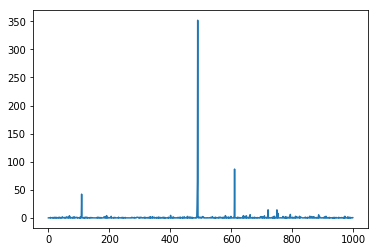

In [170]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [171]:
entropy(values)

tensor(5.50)

In [172]:
distance_from_uniform(values)

tensor(37.16)

In [177]:
#resnet33
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(645,
 [(904, 92.00),
  (646, 33.70),
  (611, 14.80),
  (750, 13.50),
  (506, 12.10),
  (971, 10.70),
  (741, 10.20),
  (808, 10.10),
  (916, 9.20),
  (721, 7.70),
  (824, 7.40),
  (769, 6.60),
  (489, 6.50),
  (580, 5.50),
  (703, 5.40),
  (893, 5.20),
  (692, 5.10),
  (582, 5.00),
  (496, 4.50),
  (905, 4.40),
  (411, 4.20),
  (806, 4.20),
  (922, 3.90),
  (84, 3.70),
  (752, 3.70),
  (565, 3.60),
  (754, 3.60),
  (963, 3.60),
  (621, 3.40),
  (55, 3.30),
  (911, 3.30),
  (982, 3.30),
  (549, 3.20),
  (94, 3.10),
  (709, 3.10),
  (879, 3.10),
  (151, 3.00),
  (128, 2.80),
  (273, 2.80),
  (562, 2.80),
  (850, 2.80),
  (890, 2.80),
  (230, 2.70),
  (987, 2.70),
  (313, 2.50),
  (454, 2.50),
  (474, 2.50),
  (134, 2.40),
  (417, 2.40),
  (533, 2.40),
  (46, 2.30),
  (595, 2.30),
  (641, 2.30),
  (645, 2.30),
  (854, 2.30),
  (864, 2.30),
  (310, 2.20),
  (472, 2.20),
  (783, 2.20),
  (826, 2.20),
  (284, 2.10),
  (292, 2.10),
  (539, 2.10),
  (616, 2.10),
  (633, 2.10),
  (805, 2.10),


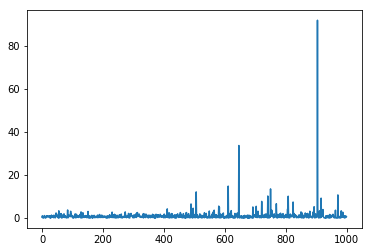

In [178]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [179]:
entropy(values)

tensor(8.62)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [ ]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 1-1: modified investigate_z
z_investigate_path = '/root/Derakhshani/adversarial/textual_notes/investigate_z_{}.txt'.format(env.save_filename)
if Path(z_investigate_path).exists(): raise FileExistsError("file already exists")
file = open(str(z_investigate_path), 'w')
        
for i, (z, noise) in enumerate(zip(pruned_z_s, pruned_noises)):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  print("result {}:".format(i))
  print(big_vector_to_str(z))
  print(labeled_hist[:6])
  print("\n\n")
  
  file.write("result {}:\n".format(i))
  file.write(big_vector_to_str(z) + "\n")
  file.write(str(labeled_hist[:6]))
  file.write("\n\n\n")
  file.flush()

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [ ]:
#experiment 3
import itertools
dimension_values = [[-0.9, 0.9]] * z_dim
for i in range(z_dim):
  if i % 100 != 0:
    dimension_values[i] = [0.]
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3: for the targeted-attack case
pruned_z_s = []
for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3-1: noises for 
pruned_z_s = []
# for i in range(z_dim):
#   new_z = torch.empty(z_dim).uniform_(0,1).cuda().detach()
#   pruned_z_s.append(new_z)

for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda().detach()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
for noise in pruned_noises[0:200]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)